<a href="https://colab.research.google.com/github/Sajjad5/Advanced-Time-Series-Predictions-WS26/blob/main/AI%20Driven%20Options%20Portfolio%20Optimization%20System%20Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI-Driven Options Portfolio Optimization System**
**🔹 Core Concept**

This project develops an advanced AI-powered system that predicts option prices and identifies optimal trading opportunities across multiple asset classes (Gold, DAX, EUR/USD) using machine learning and ensemble methods.

🔹 **Key Innovation**

Traditional options pricing models like Black-Scholes rely on theoretical assumptions. Our system uses real market data and advanced feature engineering to create more accurate, data-driven predictions that adapt to current market conditions.

🔹 **Business Value:**

The system identifies mispriced options, recommends optimal portfolio allocations, and provides risk-adjusted trading strategies - giving traders a competitive edge in derivatives markets.

In [ ]:
# Install required packages
!pip install yfinance arch statsmodels scikit-optimize
import sys
!{sys.executable} -m pip install ta-lib
!{sys.executable} -m pip install ta scikit-learn
!pip install xgboost lightgbm scikit-optimize optuna
!pip install shap


# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# For time series analysis
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import yfinance as yf


# Advanced Feature Engineering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_regression
import ta  # Technical Analysis library
from scipy import stats

# Feature Analysis and Selection
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer

# Feature Validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_regression

# Tree based model implementation
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
import optuna
from scipy.stats import randint, uniform
import joblib
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Install SHAP for model interpretation
import shap

# Import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



print("Packages installed and imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 56.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=fc5e94f1d8774879577ef7a458b4b1942318a27e8769eae698e3b3257a773a5f
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 10.0 MB/s eta 0:00:00
Packages installed and imported successfully!


#**1. Project Overview & Data Foundation**

**Purpose:** Establishes the foundation by loading and preprocessing raw options data from three asset classes.

**Key Points:**

*  Processes real options data with German decimal formatting and currency conventions
*  Handles multiple asset classes simultaneously for diversified portfolio analysis
*  Cleans and standardizes data for machine learning compatibility
*  Creates unified dataset for cross-asset comparison and optimization

**Business Impact:** Provides clean, structured data essential for reliable AI predictions and portfolio decisions.

# **Step 1.1: Data Loading and Preprocessing**

In [ ]:
def load_and_preprocess_data():
    """Load CSV files and preprocess the options data"""

    # Load data from CSV files
    try:
        # Update these paths to your actual file locations
        gold_df = pd.read_csv('/content/Gold_SG.csv')  # Skip header row if needed
        dax_df = pd.read_csv('/content/DAX40_SG.csv')
        eurusd_df = pd.read_csv('/content/EURUSD_SG.csv')
    except Exception as e:
        # If files are uploaded directly to Colab
        print(f"Error loading files from default paths: {e}. Trying alternative paths.")
        gold_df = pd.read_csv('Gold_SG.csv') # Adjusted to match actual file name
        dax_df = pd.read_csv('DAX40_SG.csv')
        eurusd_df = pd.read_csv('EURUSD_SG.csv')

    # Standardize column names (remove spaces and special characters)
    def clean_column_names(df):
        df.columns = df.columns.str.strip().str.replace('-', '_').str.replace(' ', '_')
        return df

    gold_df = clean_column_names(gold_df)
    dax_df = clean_column_names(dax_df)
    eurusd_df = clean_column_names(eurusd_df)

    # Add source identifier
    gold_df['Source'] = 'Gold'
    dax_df['Source'] = 'DAX40'
    eurusd_df['Source'] = 'EURUSD'

    # Combine all data
    combined_df = pd.concat([gold_df, dax_df, eurusd_df], ignore_index=True)

    return combined_df, gold_df, dax_df, eurusd_df

# Load the data
combined_df, gold_df, dax_df, eurusd_df = load_and_preprocess_data()

print("Data loaded successfully!")
print(f"Combined dataset shape: {combined_df.shape}")
print(f"Gold options: {gold_df.shape[0]} records")
print(f"DAX options: {dax_df.shape[0]} records")
print(f"EURUSD options: {eurusd_df.shape[0]} records")

Data loaded successfully!
Combined dataset shape: (7507, 13)
Gold options: 1785 records
DAX options: 5000 records
EURUSD options: 722 records


# **Step 1.2: Data Cleaning and Feature Engineering**

In [ ]:
def clean_and_transform_data(df):
    """Clean and transform the options data for analysis"""

    df_clean = df.copy()

    # Handle numeric columns with German format (comma as decimal separator)
    numeric_columns = ['Basispreis', 'Hebel', 'Kurs_Basiswert', 'Geld', 'Brief']

    for col in numeric_columns:
        if col in df_clean.columns:
            # Convert to string, replace commas with dots, remove currency units
            df_clean[col] = (df_clean[col].astype(str)
                            .str.replace(',', '.')
                            .str.replace(' PKT', '')
                            .str.replace(' USD', '')
                            .str.replace(' EUR', '')
                            .str.strip())

            # Convert to numeric, set errors to NaN
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Convert date column
    if 'Bewertungs_tag' in df_clean.columns:
        df_clean['Bewertungs_tag'] = pd.to_datetime(
            df_clean['Bewertungs_tag'], format='%d.%m.%Y %H:%M:%S', errors='coerce'
        )

    # Extract ratio values from Bezugs_verhältnis
    if 'Bezugs_verhältnis' in df_clean.columns:
        df_clean['Ratio_Value'] = (df_clean['Bezugs_verhältnis']
                                  .astype(str)
                                  .str.split(':')
                                  .str[0]
                                  .str.replace(',', '.')
                                  .astype(float))

    # Calculate moneyness (how far in/out of the money)
    df_clean['Moneyness'] = df_clean['Kurs_Basiswert'] / df_clean['Basispreis']

    # Create option type indicator
    df_clean['Is_Call'] = (df_clean['Typ'] == 'Call').astype(int)
    df_clean['Is_Put'] = (df_clean['Typ'] == 'Put').astype(int)

    # Calculate time to expiration (assuming current date is 20.10.2025)
    current_date = pd.to_datetime('2025-10-20')
    df_clean['Days_to_Expiry'] = (df_clean['Bewertungs_tag'] - current_date).dt.days

    return df_clean

# Apply cleaning to all datasets
combined_clean = clean_and_transform_data(combined_df)
gold_clean = clean_and_transform_data(gold_df)
dax_clean = clean_and_transform_data(dax_df)
eurusd_clean = clean_and_transform_data(eurusd_df)

print("Data cleaning completed!")
print(combined_clean.head())

Data cleaning completed!
      WKN Basiswert   Typ Bezugs_verhältnis  Basispreis Bewertungs_tag  \
0  FD2YY3      Gold  Call       10,000000:1      4400.0     2025-11-07   
1  FD2YYZ      Gold  Call       10,000000:1      4320.0     2025-11-07   
2  FD2YYL      Gold  Call       10,000000:1      4060.0     2025-11-07   
3  FD2YYG      Gold  Call       10,000000:1      3980.0     2025-11-07   
4  FD2Y01      Gold   Put       10,000000:1      4440.0     2025-11-07   

        Hebel  Kurs_Basiswert    Geld  Brief Untertägige_Auktion Handeln  \
0  24647.6288        3982.055   0.014    0.0                   -       -   
1  24648.2481        3982.055   0.014    0.0                   -       -   
2   3136.1835        3982.055   0.120    0.0                   -       -   
3    196.0262        3982.055   1.850    0.0                   -       -   
4      8.7059        3982.055  39.480    0.0                   -       -   

  Source  Ratio_Value  Moneyness  Is_Call  Is_Put  Days_to_Expiry  
0   G

# **Step 1.3: Exploratory Data Analysis**


=== Gold Options Analysis ===
Dataset shape: (1785, 18)

Basic Statistics:
        Basispreis  Kurs_Basiswert         Geld         Hebel    Moneyness
count  1785.000000    1.785000e+03  1785.000000   1785.000000  1785.000000
mean   3715.193277    3.982055e+03    26.689334   2087.051140     1.132735
std     806.220893    7.869334e-11    34.816213   6127.664109     0.290542
min    1800.000000    3.982055e+03     0.001000      2.170000     0.765780
25%    3100.000000    3.982055e+03     0.530000      8.137900     0.909145
50%    3820.000000    3.982055e+03    10.700000     32.005800     1.042423
75%    4380.000000    3.982055e+03    42.540000    522.703100     1.284534
max    5200.000000    3.982055e+03   159.050000  24654.715000     2.212253


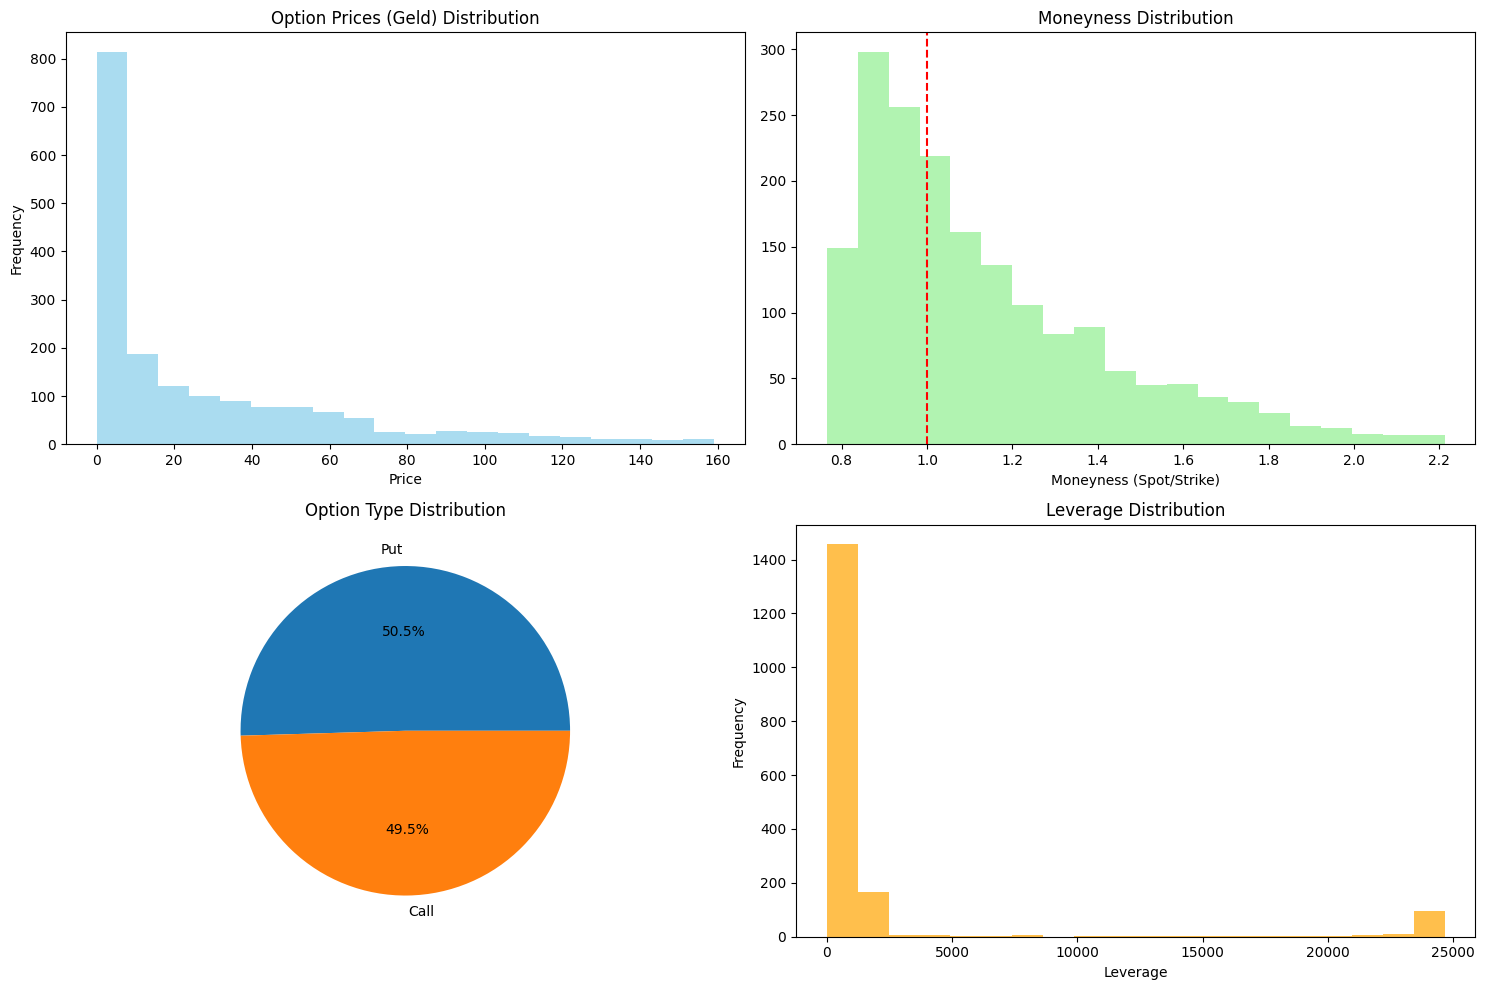

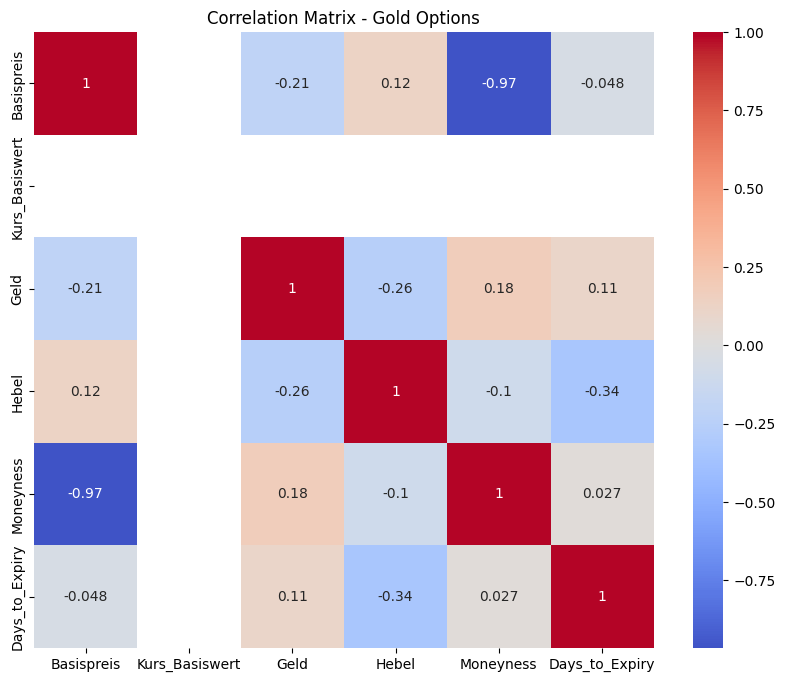


=== DAX Options Analysis ===
Dataset shape: (5000, 18)

Basic Statistics:
         Basispreis  Kurs_Basiswert         Geld          Hebel    Moneyness
count   5000.000000    5.000000e+03  5000.000000    4856.000000  5000.000000
mean   23443.245000    2.379282e+04     7.867525    1362.857508     1.033234
std     2955.872279    2.961611e-09    11.382170    5363.353044     0.148552
min    13300.000000    2.379282e+04     0.001000       3.234800     0.782659
25%    21900.000000    2.379282e+04     0.500000      20.988375     0.938342
50%    23700.000000    2.379282e+04     3.290000      66.457800     1.003916
75%    25356.250000    2.379282e+04    11.012500     360.453100     1.086430
max    30400.000000    2.379282e+04    73.530000  118967.425900     1.788934


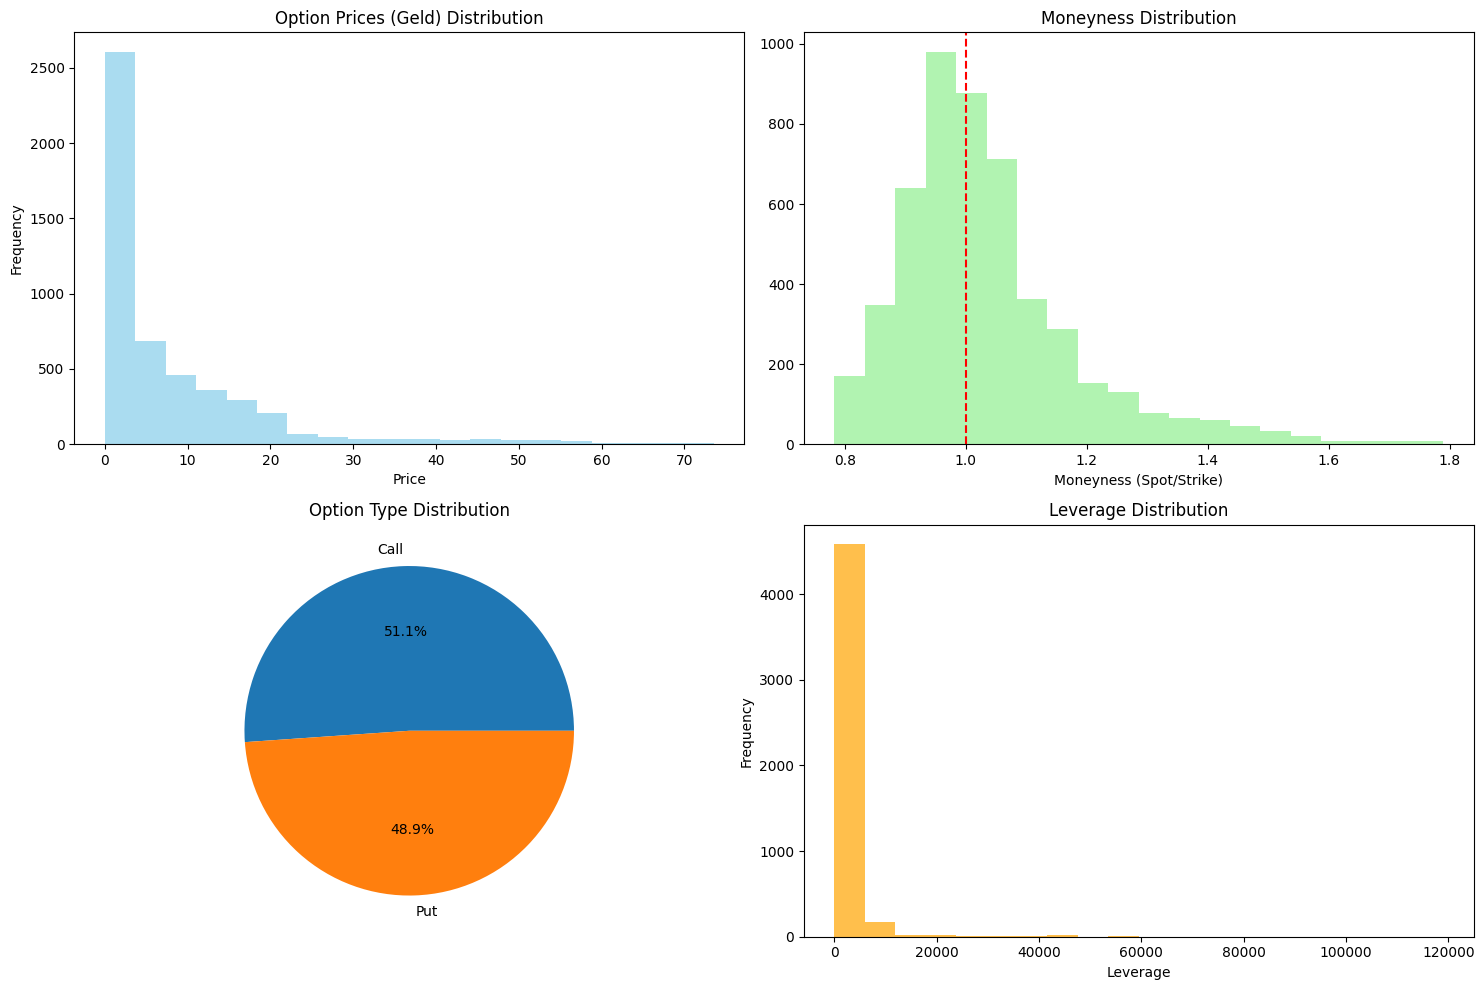

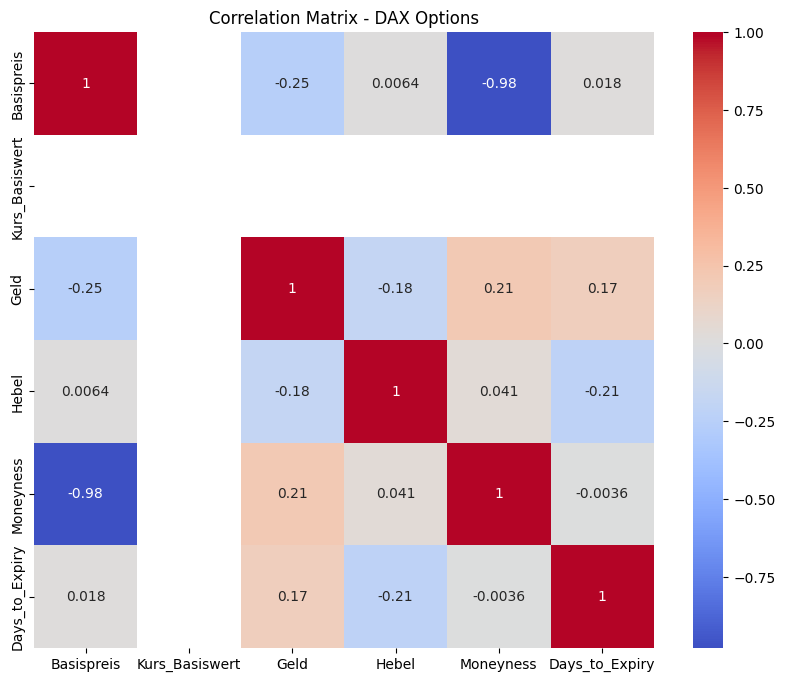


=== EURUSD Options Analysis ===
Dataset shape: (722, 18)

Basic Statistics:
       Basispreis  Kurs_Basiswert        Geld         Hebel   Moneyness
count  722.000000    7.220000e+02  722.000000    722.000000  722.000000
mean     1.151468    1.154300e+00    1.743325   3010.090674    1.007786
std      0.082576    7.776949e-15    2.558904   5969.663254    0.074736
min      0.905000    1.154300e+00    0.003000      6.369400    0.877795
25%      1.095000    1.154300e+00    0.013000     37.733900    0.953967
50%      1.155000    1.154300e+00    0.535000    183.506300    0.999394
75%      1.210000    1.154300e+00    2.650000   4348.240500    1.054155
max      1.315000    1.154300e+00   15.700000  25002.598600    1.275470


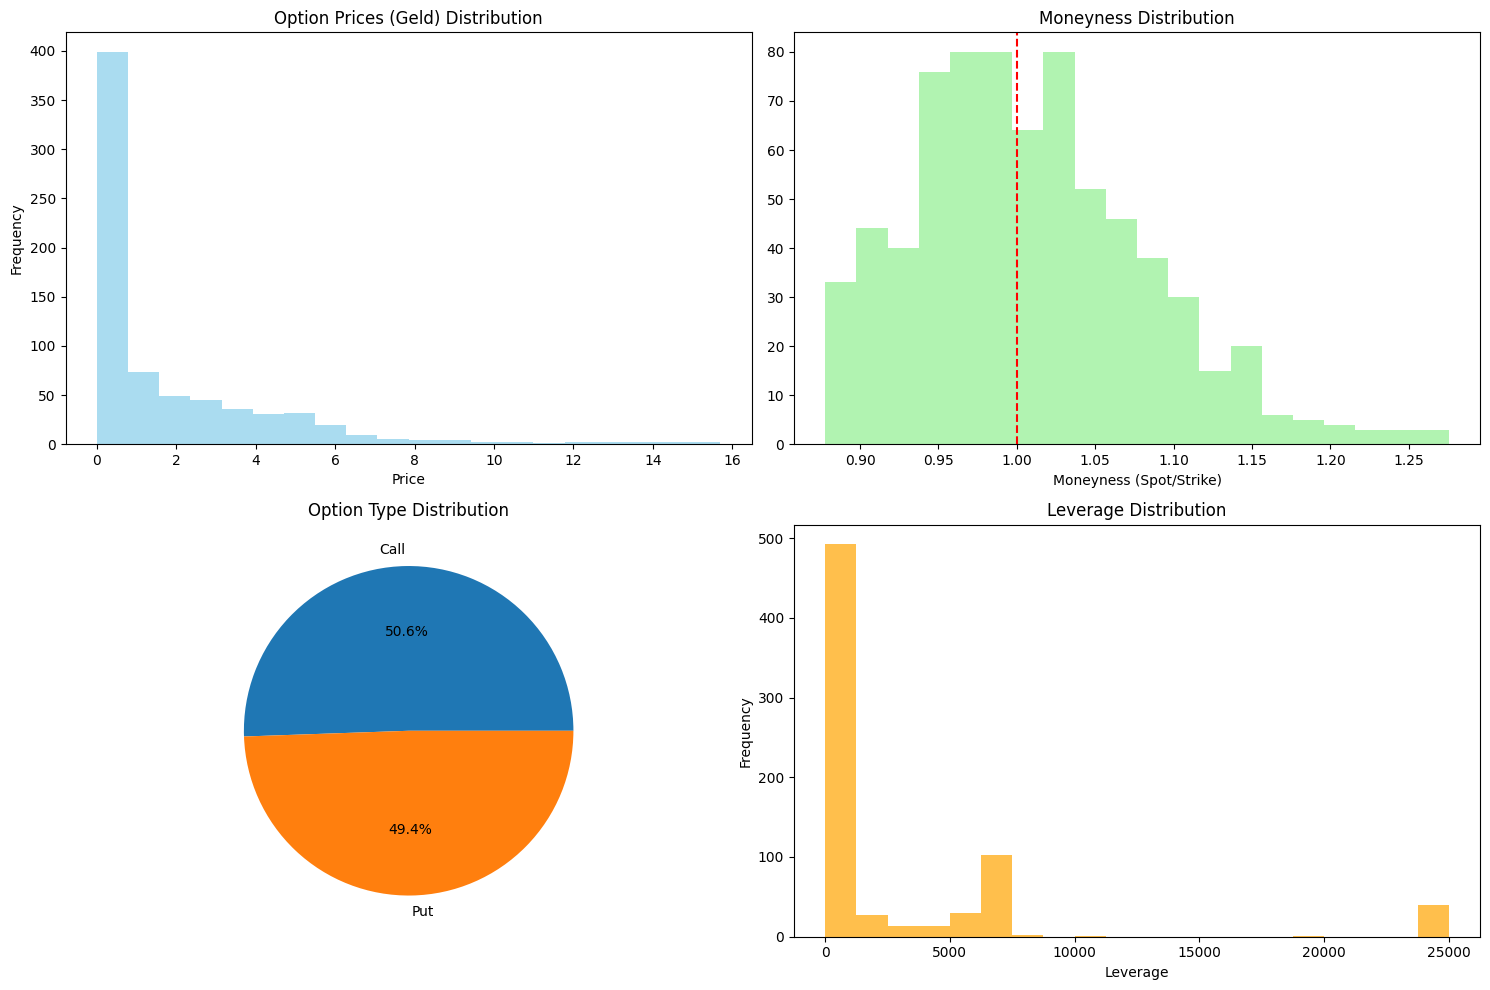

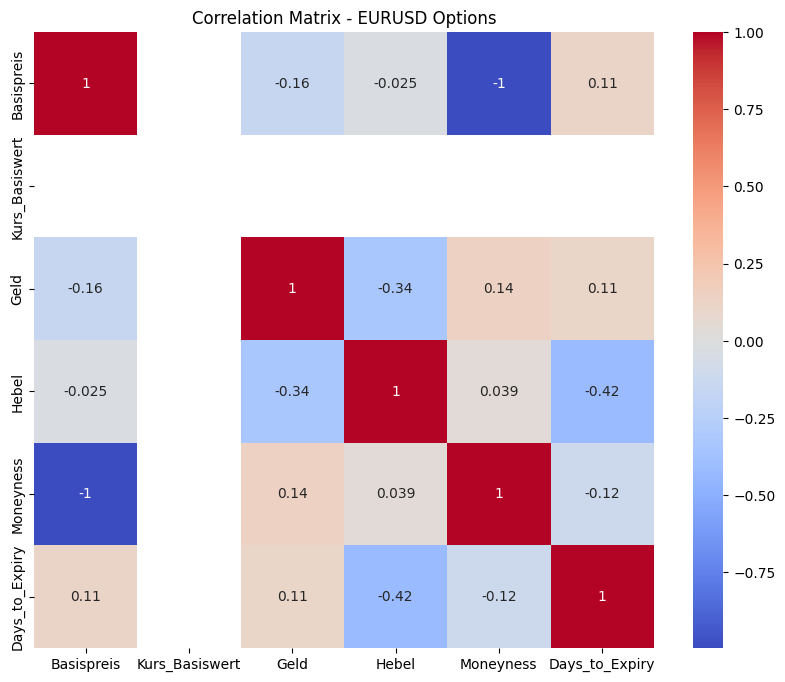

In [ ]:
def exploratory_analysis(df, title):
    """Perform exploratory data analysis"""

    print(f"\n=== {title} Analysis ===")
    print(f"Dataset shape: {df.shape}")
    print("\nBasic Statistics:")
    print(df[['Basispreis', 'Kurs_Basiswert', 'Geld', 'Hebel', 'Moneyness']].describe())

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Option prices distribution
    axes[0,0].hist(df['Geld'].dropna(), bins=20, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Option Prices (Geld) Distribution')
    axes[0,0].set_xlabel('Price')
    axes[0,0].set_ylabel('Frequency')

    # Moneyness distribution
    axes[0,1].hist(df['Moneyness'].dropna(), bins=20, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Moneyness Distribution')
    axes[0,1].set_xlabel('Moneyness (Spot/Strike)')
    axes[0,1].axvline(1, color='red', linestyle='--', label='At the money')

    # Option type distribution
    option_counts = df['Typ'].value_counts()
    axes[1,0].pie(option_counts.values, labels=option_counts.index, autopct='%1.1f%%')
    axes[1,0].set_title('Option Type Distribution')

    # Leverage distribution
    axes[1,1].hist(df['Hebel'].dropna(), bins=20, alpha=0.7, color='orange')
    axes[1,1].set_title('Leverage Distribution')
    axes[1,1].set_xlabel('Leverage')
    axes[1,1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Correlation heatmap
    numeric_cols = ['Basispreis', 'Kurs_Basiswert', 'Geld', 'Hebel', 'Moneyness', 'Days_to_Expiry']
    corr_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title(f'Correlation Matrix - {title}')
    plt.show()

# Perform EDA for each dataset
exploratory_analysis(gold_clean, "Gold Options")
exploratory_analysis(dax_clean, "DAX Options")
exploratory_analysis(eurusd_clean, "EURUSD Options")

# **Step 1.4: Time Series Analysis**

Performing Time Series Analysis...


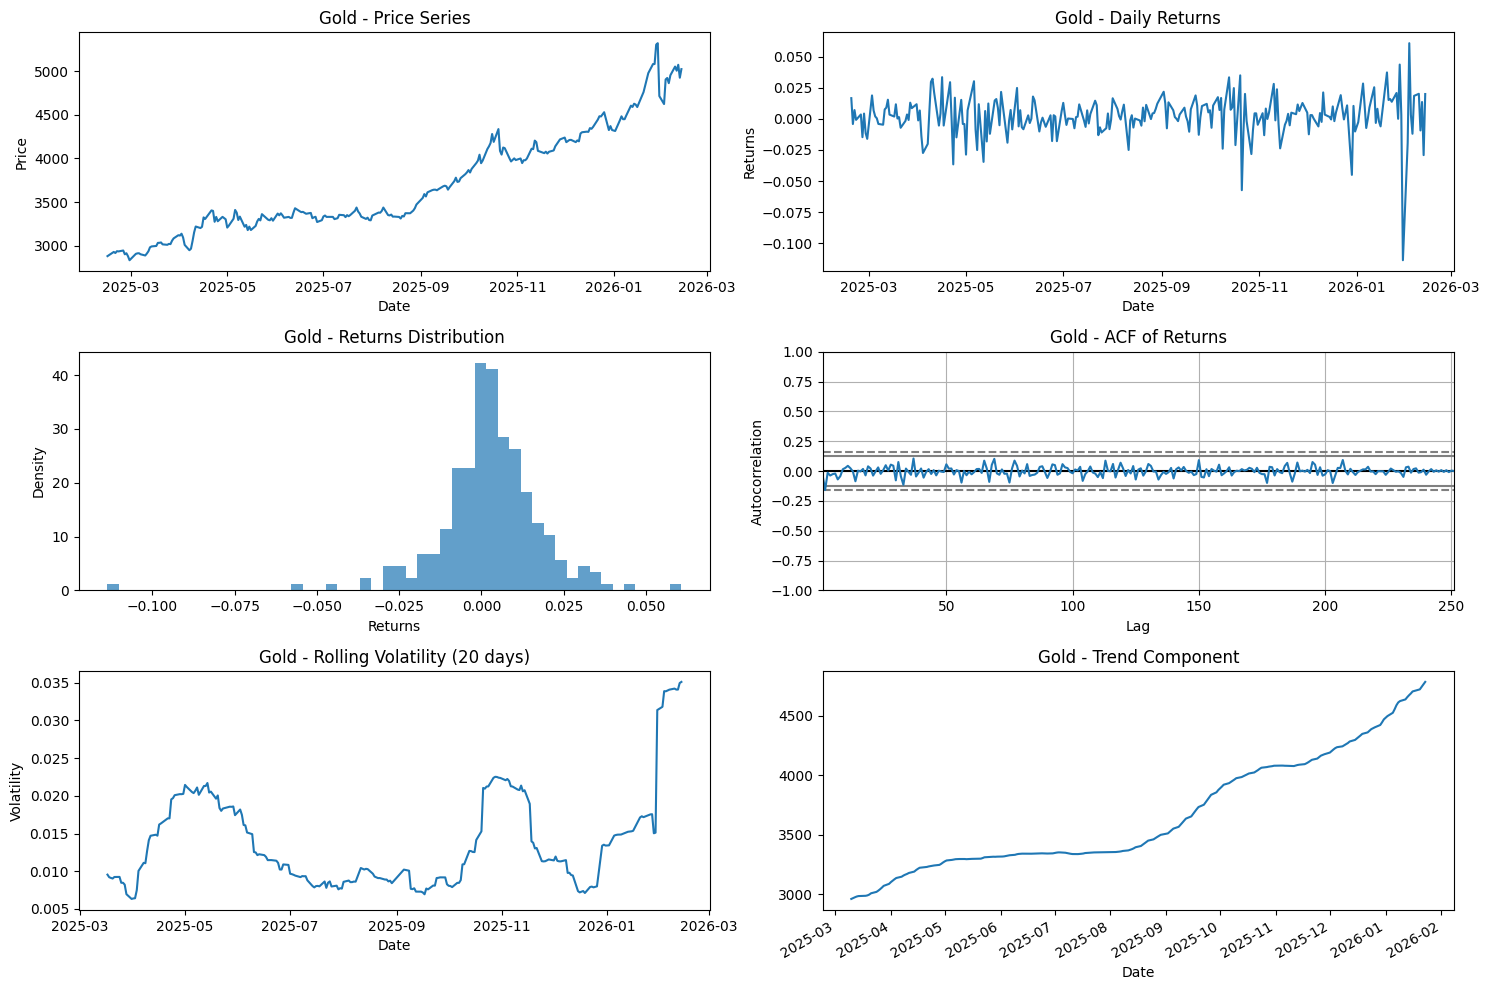


Gold Stationarity Test (ADF):
ADF Statistic: 0.508441
p-value: 0.985127
Critical Values: {'1%': np.float64(-3.4568881317725864), '5%': np.float64(-2.8732185133016057), '10%': np.float64(-2.5729936189738876)}


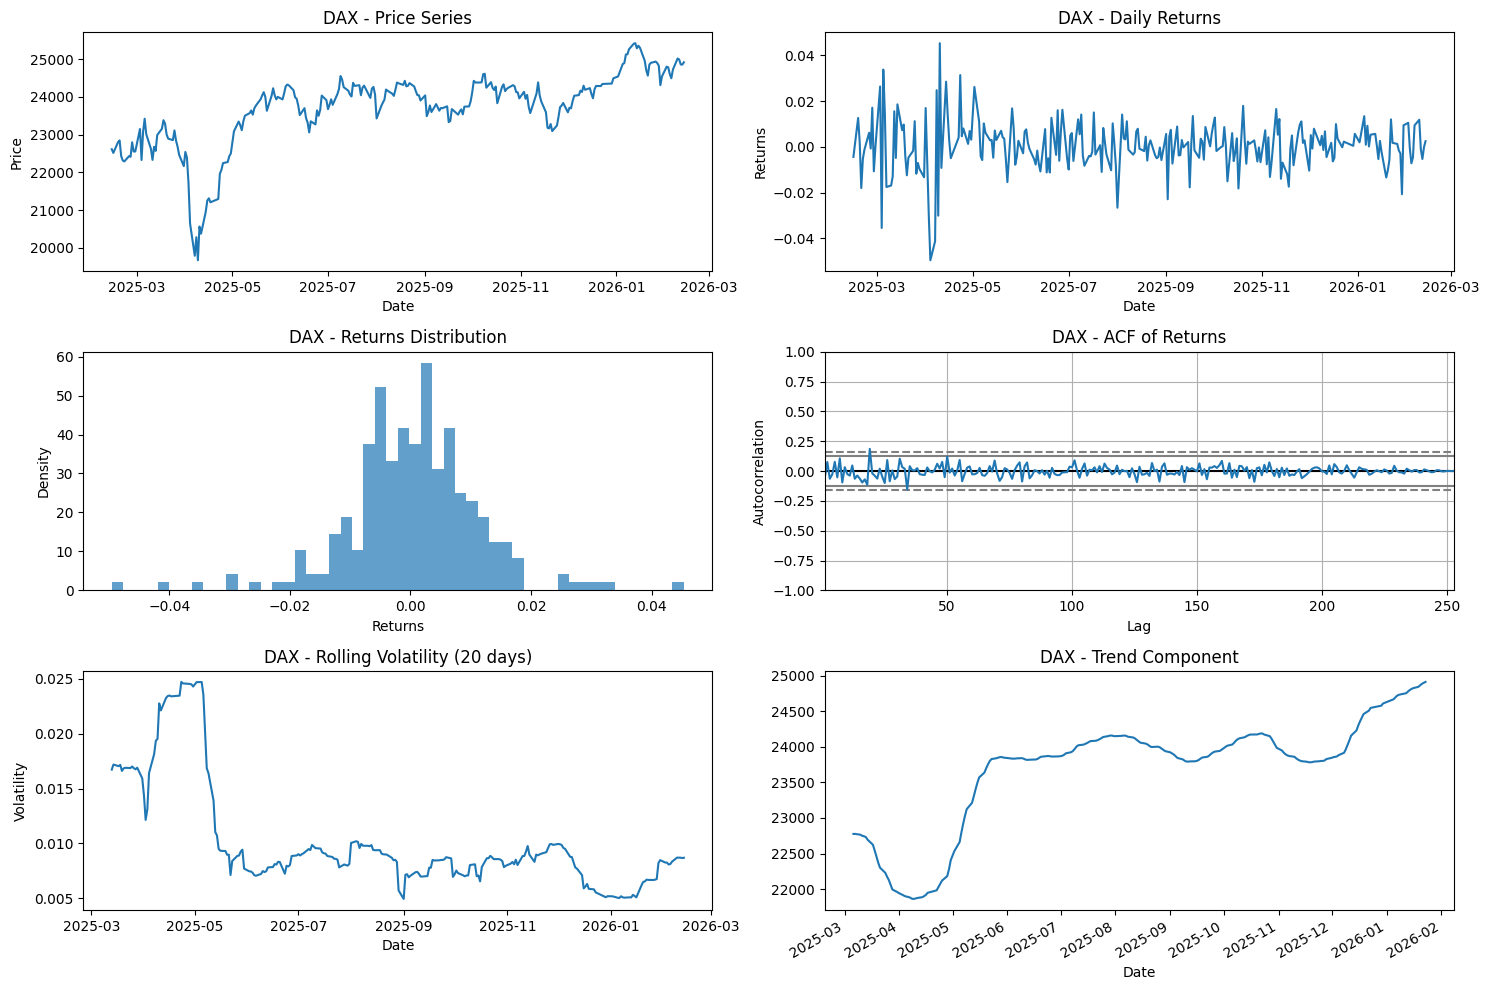


DAX Stationarity Test (ADF):
ADF Statistic: -2.038536
p-value: 0.269936
Critical Values: {'1%': np.float64(-3.4564641849494113), '5%': np.float64(-2.873032730098417), '10%': np.float64(-2.572894516864816)}


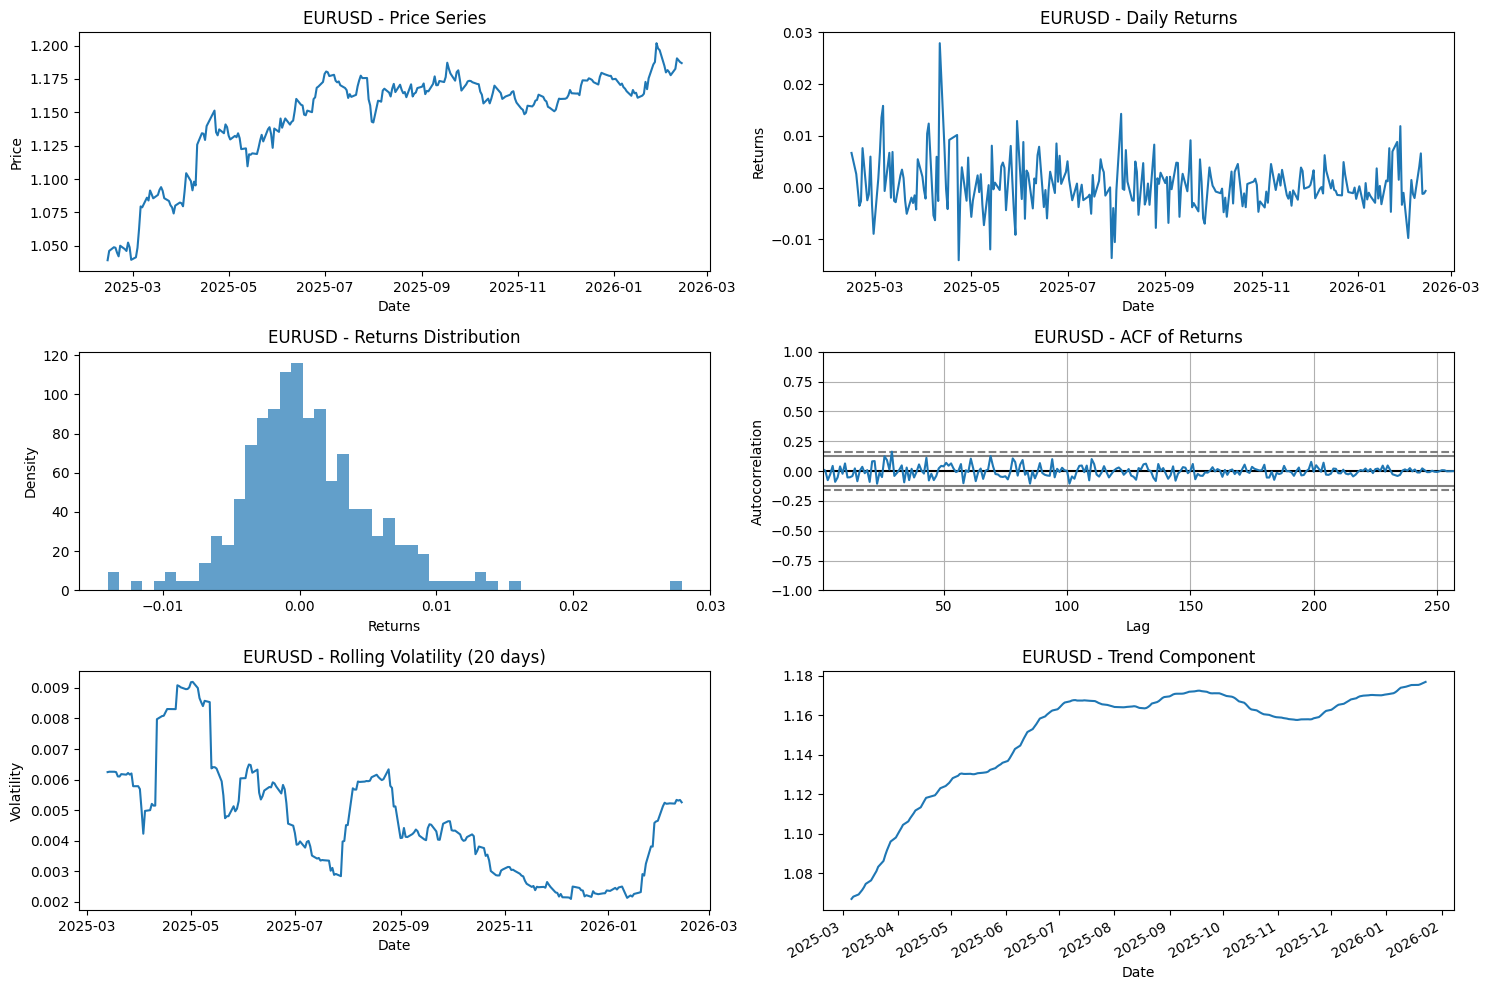


EURUSD Stationarity Test (ADF):
ADF Statistic: -2.769122
p-value: 0.062822
Critical Values: {'1%': np.float64(-3.4560535712549925), '5%': np.float64(-2.8728527662442334), '10%': np.float64(-2.5727985212493754)}


In [ ]:
def fetch_market_data(symbol, period="1y"):
    """Fetch underlying asset price data for time series analysis"""
    try:
        ticker = yf.Ticker(symbol)
        data = ticker.history(period=period)
        return data
    except:
        print(f"Could not fetch data for {symbol}")
        return None

# Fetch underlying asset data
gold_prices = fetch_market_data("GC=F")  # Gold futures
dax_prices = fetch_market_data("^GDAXI")  # DAX index
eurusd_prices = fetch_market_data("EURUSD=X")  # EUR/USD

def time_series_analysis(price_data, title):
    """Perform basic time series analysis"""
    if price_data is None or len(price_data) == 0:
        print(f"No data available for {title}")
        return

    prices = price_data['Close']

    # Plot price series
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 2, 1)
    plt.plot(prices)
    plt.title(f'{title} - Price Series')
    plt.xlabel('Date')
    plt.ylabel('Price')

    # Returns
    returns = prices.pct_change().dropna()

    plt.subplot(3, 2, 2)
    plt.plot(returns)
    plt.title(f'{title} - Daily Returns')
    plt.xlabel('Date')
    plt.ylabel('Returns')

    # Distribution of returns
    plt.subplot(3, 2, 3)
    plt.hist(returns, bins=50, alpha=0.7, density=True)
    plt.title(f'{title} - Returns Distribution')
    plt.xlabel('Returns')
    plt.ylabel('Density')

    # ACF of returns
    plt.subplot(3, 2, 4)
    pd.plotting.autocorrelation_plot(returns)
    plt.title(f'{title} - ACF of Returns')

    # Volatility clustering
    plt.subplot(3, 2, 5)
    plt.plot(returns.rolling(20).std())
    plt.title(f'{title} - Rolling Volatility (20 days)')
    plt.xlabel('Date')
    plt.ylabel('Volatility')

    # Seasonal decomposition (if enough data)
    if len(prices) > 30:
        try:
            decomposition = seasonal_decompose(prices.dropna(), period=min(30, len(prices)//2), model='additive')
            plt.subplot(3, 2, 6)
            decomposition.trend.plot(ax=plt.gca())
            plt.title(f'{title} - Trend Component')
        except:
            pass

    plt.tight_layout()
    plt.show()

    # Stationarity test
    adf_result = adfuller(prices.dropna())
    print(f"\n{title} Stationarity Test (ADF):")
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print(f"Critical Values: {adf_result[4]}")

    return returns

# Perform time series analysis
print("Performing Time Series Analysis...")
gold_returns = time_series_analysis(gold_prices, "Gold")
dax_returns = time_series_analysis(dax_prices, "DAX")
eurusd_returns = time_series_analysis(eurusd_prices, "EURUSD")

# **Step 1.5: ARIMA GARCH Modeling**


Searching for best ARIMA order for Gold...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(0,0,1): AIC = -1356.10


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(0,0,2): AIC = -1361.73


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(0,0,3): AIC = -1360.11
  ARIMA(1,0,0): AIC = -1355.98


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(1,0,1): AIC = -1361.33


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(1,0,2): AIC = -1360.09


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(1,0,3): AIC = -1358.08


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(2,0,0): AIC = -1360.56


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(2,0,1): AIC = -1358.83


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(2,0,2): AIC = -1360.25


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/di

  ARIMA(2,0,3): AIC = -1357.89
  ARIMA(3,0,0): AIC = -1358.70


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(3,0,1): AIC = -1356.72


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(3,0,2): AIC = -1358.37


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/di

  ARIMA(3,0,3): AIC = -1356.18

Best ARIMA order for Gold: (0, 0, 2) (AIC: -1361.73)

Searching for best ARIMA order for DAX...


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(0,0,1): AIC = -1554.60


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(0,0,2): AIC = -1553.86
  ARIMA(0,0,3): AIC = -1553.38


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(1,0,0): AIC = -1554.69


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(1,0,1): AIC = -1552.64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(1,0,2): AIC = -1552.21


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(1,0,3): AIC = -1549.96


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(2,0,0): AIC = -1554.06


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(2,0,1): AIC = -1550.76


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/di

  ARIMA(2,0,2): AIC = -1552.72


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(2,0,3): AIC = -1548.87
  ARIMA(3,0,0): AIC = -1552.89


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(3,0,1): AIC = -1550.91


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(3,0,2): AIC = -1548.73


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(3,0,3): AIC = -1547.23

Best ARIMA order for DAX: (1, 0, 0) (AIC: -1554.69)

Searching for best ARIMA order for EURUSD...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(0,0,1): AIC = -1997.29


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/di

  ARIMA(0,0,2): AIC = -1995.29
  ARIMA(0,0,3): AIC = -1995.13
  ARIMA(1,0,0): AIC = -1997.29


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(1,0,1): AIC = -1995.07


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(1,0,2): AIC = -1993.24


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(1,0,3): AIC = -1993.29


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(2,0,0): AIC = -1995.29


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(2,0,1): AIC = -1993.22


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/di

  ARIMA(2,0,2): AIC = -1991.36


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(2,0,3): AIC = -1991.63
  ARIMA(3,0,0): AIC = -1994.79


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/di

  ARIMA(3,0,1): AIC = -1992.79
  ARIMA(3,0,2): AIC = -1990.90


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/di

  ARIMA(3,0,3): AIC = -1990.07

Best ARIMA order for EURUSD: (1, 0, 0) (AIC: -1997.29)

Fitting ARIMA(0, 0, 2)-GARCH(1, 1) Model for Gold

Gold ARIMA(0, 0, 2) Results:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 684.864
Date:                Sat, 14 Feb 2026   AIC                          -1361.728
Time:                        11:15:03   BIC                          -1347.626
Sample:                             0   HQIC                         -1356.053
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.69

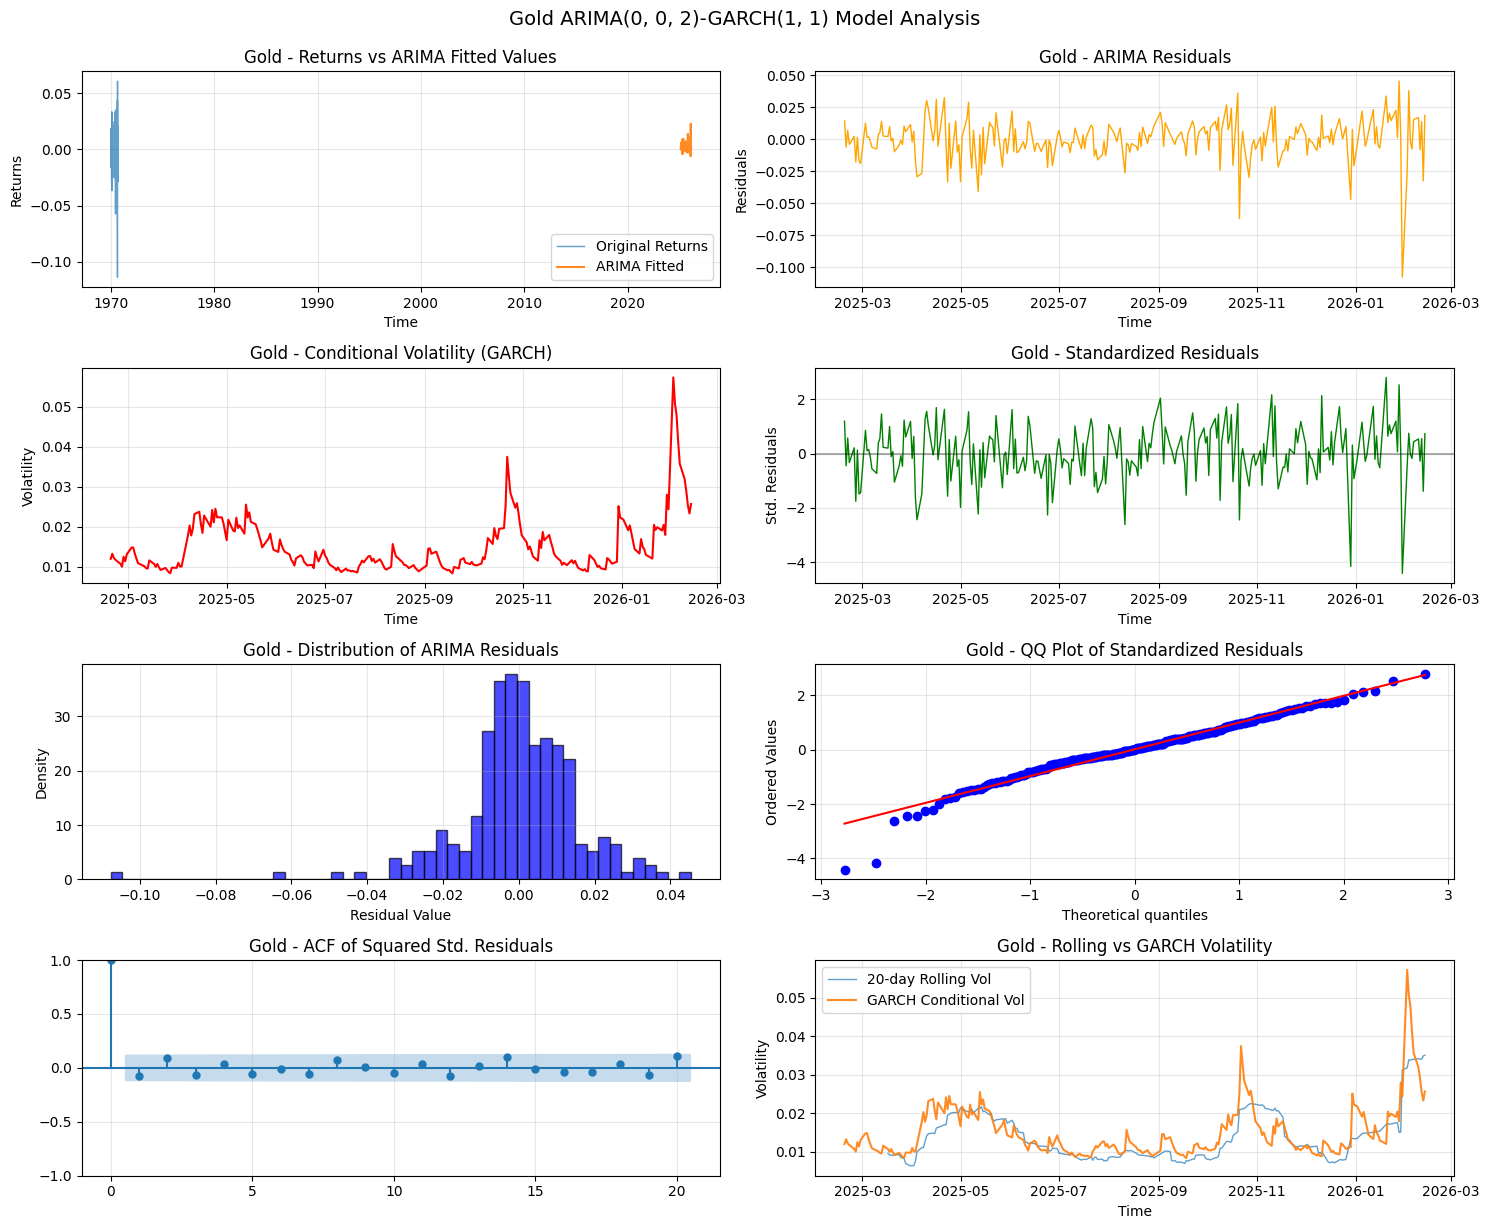


Gold Model Diagnostics:
- ARIMA AIC: -1361.7283
- ARIMA BIC: -1347.6265
- GARCH AIC: 888.7283
- GARCH BIC: 902.8302
- Ljung-Box test p-value (lag 10): 0.6696

Fitting ARIMA(1, 0, 0)-GARCH(1, 1) Model for DAX

DAX ARIMA(1, 0, 0) Results:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  253
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 780.345
Date:                Sat, 14 Feb 2026   AIC                          -1554.691
Time:                        11:15:05   BIC                          -1544.091
Sample:                             0   HQIC                         -1550.426
                                - 253                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


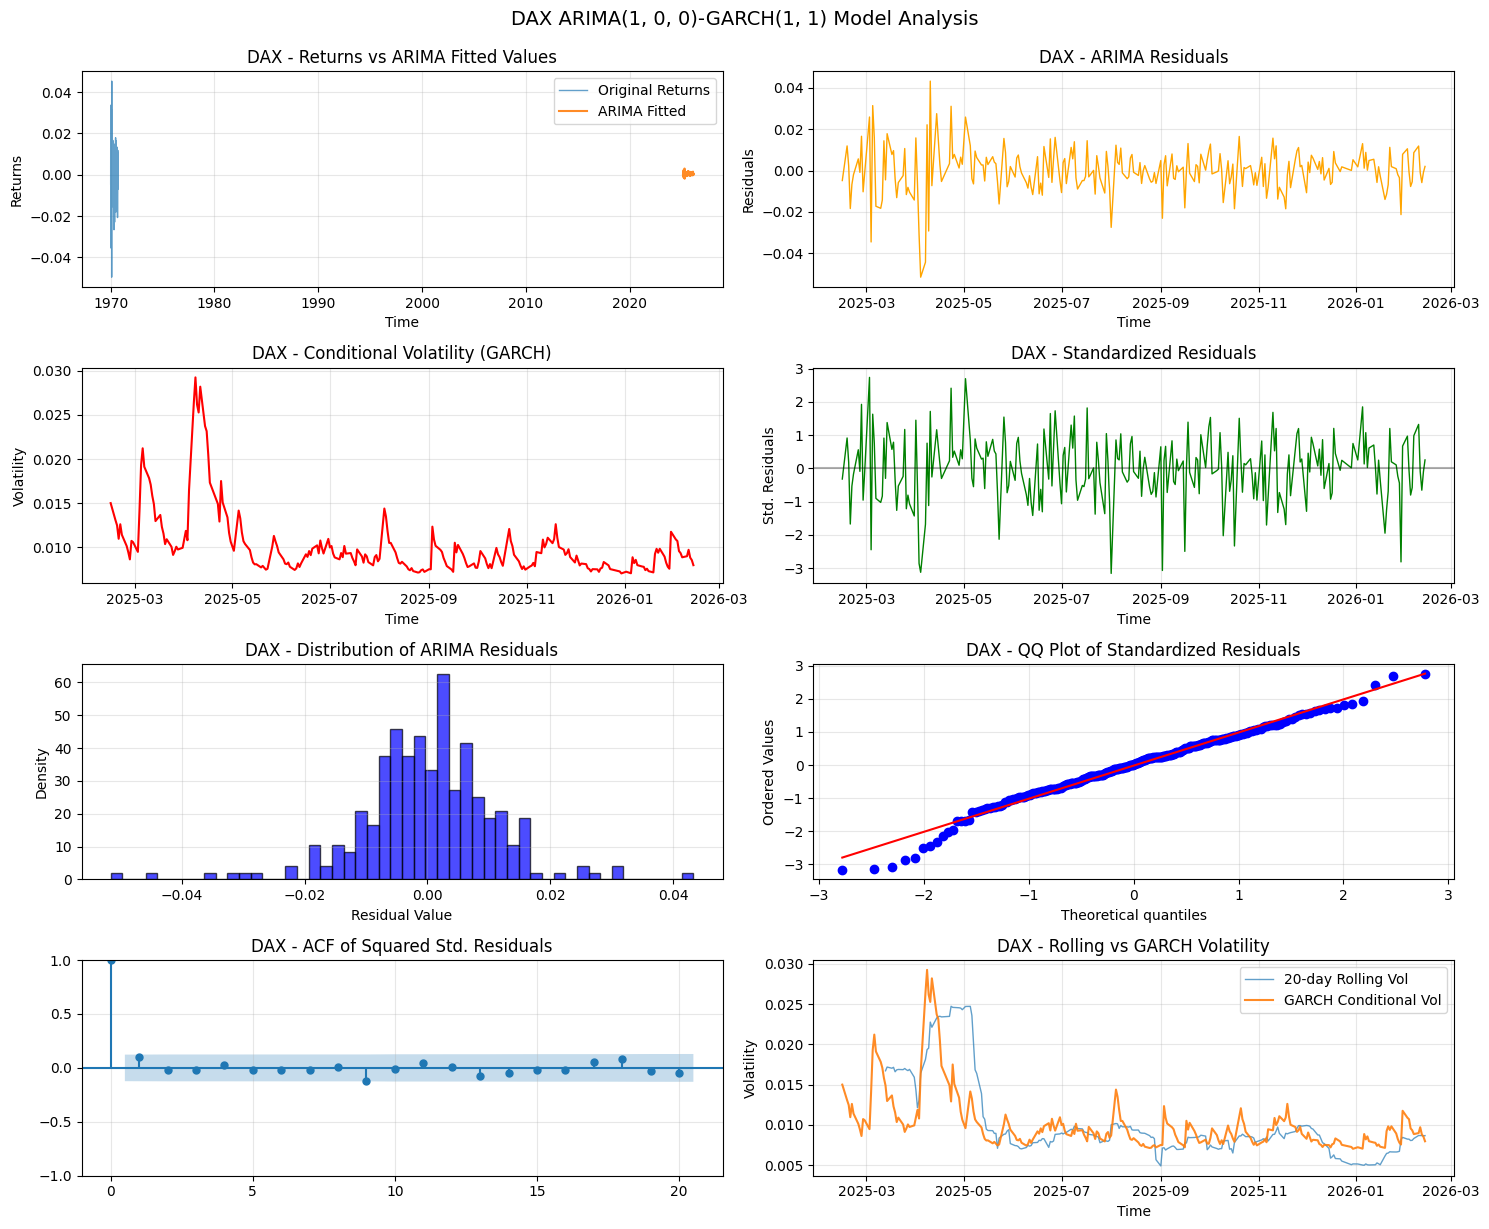


DAX Model Diagnostics:
- ARIMA AIC: -1554.6909
- ARIMA BIC: -1544.0907
- GARCH AIC: 710.1105
- GARCH BIC: 724.2440
- Ljung-Box test p-value (lag 10): 0.8989

Fitting ARIMA(1, 0, 0)-GARCH(1, 1) Model for EURUSD

EURUSD ARIMA(1, 0, 0) Results:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  257
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1001.645
Date:                Sat, 14 Feb 2026   AIC                          -1997.290
Time:                        11:15:07   BIC                          -1986.642
Sample:                             0   HQIC                         -1993.008
                                - 257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


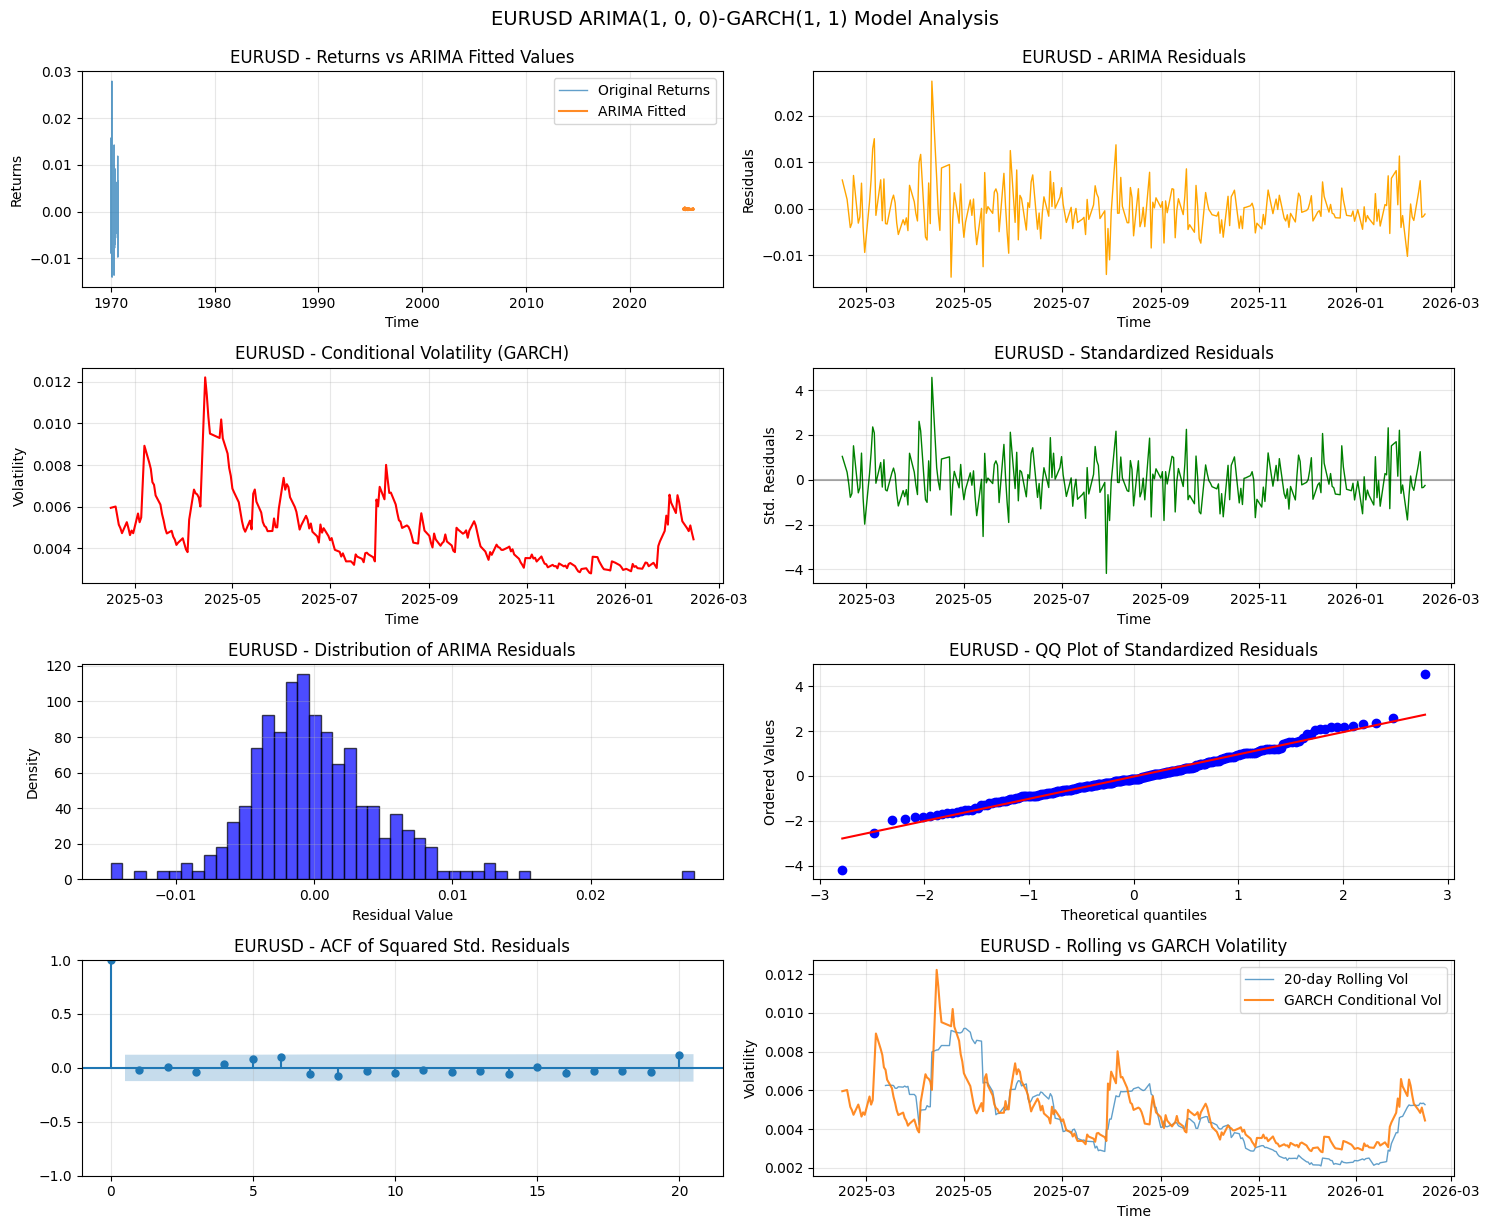


EURUSD Model Diagnostics:
- ARIMA AIC: -1997.2895
- ARIMA BIC: -1986.6423
- GARCH AIC: 336.9648
- GARCH BIC: 351.1611
- Ljung-Box test p-value (lag 10): 0.6423

MODEL COMPARISON SUMMARY
Gold:
  ARIMA AIC: -1361.73, GARCH AIC: 888.73, Total: -473.00
  GARCH persistence (α+β): 0.9850
  Volatility half-life: 45.9 days

DAX:
  ARIMA AIC: -1554.69, GARCH AIC: 710.11, Total: -844.58
  GARCH persistence (α+β): 0.8648
  Volatility half-life: 4.8 days

EURUSD:
  ARIMA AIC: -1997.29, GARCH AIC: 336.96, Total: -1660.32
  GARCH persistence (α+β): 0.9680
  Volatility half-life: 21.3 days



In [ ]:

def fit_arima_garch_model(returns, title, arima_order=(1,0,1), garch_order=(1,1)):
    """
    Fit ARIMA-GARCH model to capture both conditional mean and volatility clustering

    Parameters:
    -----------
    returns : pd.Series or np.array
        Time series of returns
    title : str
        Title for output and plots
    arima_order : tuple
        (p,d,q) order for ARIMA model
    garch_order : tuple
        (p,q) order for GARCH model

    Returns:
    --------
    dict : Dictionary containing ARIMA model, GARCH model, residuals, and conditional volatility
    """

    if returns is None or len(returns) < 100:
        print(f"Not enough data for {title} ARIMA-GARCH modeling (min 100 observations)")
        return None

    try:
        # Step 1: Fit ARIMA model to capture conditional mean
        print(f"\n{'='*60}")
        print(f"Fitting ARIMA{arima_order}-GARCH{garch_order} Model for {title}")
        print(f"{'='*60}")

        # Fit ARIMA model
        arima_model = ARIMA(returns, order=arima_order)
        arima_fitted = arima_model.fit()

        print(f"\n{title} ARIMA{arima_order} Results:")
        print(arima_fitted.summary())

        # Get ARIMA residuals
        arima_residuals = arima_fitted.resid

        # Step 2: Fit GARCH model on ARIMA residuals to capture volatility clustering
        # Multiply by 100 for better numerical stability (common practice for returns)
        garch_model = arch_model(arima_residuals * 100, vol='Garch', p=garch_order[0], q=garch_order[1])
        garch_fitted = garch_model.fit(disp='off', show_warning=False)

        print(f"\n{title} GARCH{garch_order} Results (on ARIMA residuals):")
        print(garch_fitted.summary())

        # Step 3: Generate comprehensive plots
        fig = plt.figure(figsize=(15, 12))

        # Plot 1: Original returns vs ARIMA fitted values
        ax1 = plt.subplot(4, 2, 1)
        plt.plot(returns.values, label='Original Returns', alpha=0.7, linewidth=1)
        plt.plot(arima_fitted.fittedvalues, label='ARIMA Fitted', alpha=0.9, linewidth=1.5)
        plt.title(f'{title} - Returns vs ARIMA Fitted Values')
        plt.xlabel('Time')
        plt.ylabel('Returns')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 2: ARIMA residuals
        ax2 = plt.subplot(4, 2, 2)
        plt.plot(arima_residuals, color='orange', linewidth=1)
        plt.title(f'{title} - ARIMA Residuals')
        plt.xlabel('Time')
        plt.ylabel('Residuals')
        plt.grid(True, alpha=0.3)

        # Plot 3: Conditional volatility from GARCH
        ax3 = plt.subplot(4, 2, 3)
        conditional_vol = garch_fitted.conditional_volatility / 100  # Convert back from percentage
        plt.plot(conditional_vol, color='red', linewidth=1.5)
        plt.title(f'{title} - Conditional Volatility (GARCH)')
        plt.xlabel('Time')
        plt.ylabel('Volatility')
        plt.grid(True, alpha=0.3)

        # Plot 4: Standardized residuals
        ax4 = plt.subplot(4, 2, 4)
        standardized_residuals = arima_residuals / conditional_vol
        plt.plot(standardized_residuals, color='green', linewidth=1)
        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        plt.title(f'{title} - Standardized Residuals')
        plt.xlabel('Time')
        plt.ylabel('Std. Residuals')
        plt.grid(True, alpha=0.3)

        # Plot 5: Histogram of ARIMA residuals
        ax5 = plt.subplot(4, 2, 5)
        plt.hist(arima_residuals.dropna(), bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
        plt.title(f'{title} - Distribution of ARIMA Residuals')
        plt.xlabel('Residual Value')
        plt.ylabel('Density')
        plt.grid(True, alpha=0.3)

        # Plot 6: QQ-plot of standardized residuals
        ax6 = plt.subplot(4, 2, 6)
        from scipy import stats
        stats.probplot(standardized_residuals.dropna(), dist="norm", plot=plt)
        plt.title(f'{title} - QQ Plot of Standardized Residuals')
        plt.grid(True, alpha=0.3)

        # Plot 7: ACF of squared standardized residuals
        ax7 = plt.subplot(4, 2, 7)
        from statsmodels.graphics.tsaplots import plot_acf
        squared_std_residuals = standardized_residuals.dropna() ** 2
        plot_acf(squared_std_residuals, lags=20, ax=ax7, title=f'{title} - ACF of Squared Std. Residuals')
        plt.grid(True, alpha=0.3)

        # Plot 8: Rolling volatility (20-day window)
        ax8 = plt.subplot(4, 2, 8)
        rolling_vol = returns.rolling(window=20).std() if hasattr(returns, 'rolling') else pd.Series(returns).rolling(window=20).std()
        plt.plot(rolling_vol, label='20-day Rolling Vol', alpha=0.7, linewidth=1)
        plt.plot(conditional_vol, label='GARCH Conditional Vol', alpha=0.9, linewidth=1.5)
        plt.title(f'{title} - Rolling vs GARCH Volatility')
        plt.xlabel('Time')
        plt.ylabel('Volatility')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.suptitle(f'{title} ARIMA{arima_order}-GARCH{garch_order} Model Analysis', y=1.02, fontsize=14)
        plt.show()

        # Step 4: Model diagnostics
        print(f"\n{title} Model Diagnostics:")
        print(f"- ARIMA AIC: {arima_fitted.aic:.4f}")
        print(f"- ARIMA BIC: {arima_fitted.bic:.4f}")
        print(f"- GARCH AIC: {garch_fitted.aic:.4f}")
        print(f"- GARCH BIC: {garch_fitted.bic:.4f}")

        # Check for remaining autocorrelation in standardized residuals
        from statsmodels.stats.diagnostic import acorr_ljungbox
        lb_test = acorr_ljungbox(standardized_residuals.dropna(), lags=[10], return_df=True)
        print(f"- Ljung-Box test p-value (lag 10): {lb_test['lb_pvalue'].iloc[0]:.4f}")

        return {
            'arima_model': arima_fitted,
            'garch_model': garch_fitted,
            'arima_residuals': arima_residuals,
            'conditional_volatility': conditional_vol,
            'standardized_residuals': standardized_residuals
        }

    except Exception as e:
        print(f"Error fitting ARIMA-GARCH model for {title}: {e}")
        return None

def find_best_arima_order(returns, title, max_p=3, max_q=3):
    """
    Find optimal ARIMA order using AIC criterion

    Parameters:
    -----------
    returns : pd.Series or np.array
        Time series of returns
    title : str
        Title for output
    max_p : int
        Maximum AR order to test
    max_q : int
        Maximum MA order to test

    Returns:
    --------
    tuple : Best (p,d,q) order based on AIC
    """

    if returns is None or len(returns) < 50:
        print(f"Not enough data for {title} ARIMA order selection")
        return (1, 0, 1)

    try:
        best_aic = np.inf
        best_order = (1, 0, 1)

        print(f"\nSearching for best ARIMA order for {title}...")

        # Test different ARIMA orders
        for p in range(max_p + 1):
            for q in range(max_q + 1):
                if p == 0 and q == 0:
                    continue

                try:
                    model = ARIMA(returns, order=(p, 0, q))
                    fitted = model.fit()

                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p, 0, q)

                    print(f"  ARIMA({p},0,{q}): AIC = {fitted.aic:.2f}")

                except:
                    continue

        print(f"\nBest ARIMA order for {title}: {best_order} (AIC: {best_aic:.2f})")
        return best_order

    except Exception as e:
        print(f"Error finding best ARIMA order for {title}: {e}")
        return (1, 0, 1)

# Main execution
if __name__ == "__main__":
    # Assuming you have gold_returns, dax_returns, eurusd_returns defined
    # If not, you can create sample data for testing:

    # Create sample returns data if not available
    np.random.seed(42)
    n_obs = 500

    if 'gold_returns' not in locals() or gold_returns is None:
        # Generate simulated GARCH-like returns
        omega, alpha, beta = 0.01, 0.1, 0.85
        volatility = np.zeros(n_obs)
        returns_sim = np.zeros(n_obs)

        volatility[0] = np.sqrt(omega / (1 - alpha - beta))
        returns_sim[0] = np.random.randn() * volatility[0]

        for t in range(1, n_obs):
            volatility[t] = np.sqrt(omega + alpha * returns_sim[t-1]**2 + beta * volatility[t-1]**2)
            returns_sim[t] = 0.05 * returns_sim[t-1] + np.random.randn() * volatility[t]  # AR(1) + GARCH

        gold_returns = pd.Series(returns_sim, name='Gold Returns')
        dax_returns = pd.Series(np.random.randn(n_obs) * 0.02, name='DAX Returns')
        eurusd_returns = pd.Series(np.random.randn(n_obs) * 0.01, name='EURUSD Returns')

    # Find optimal ARIMA orders for each series
    gold_order = find_best_arima_order(gold_returns, "Gold")
    dax_order = find_best_arima_order(dax_returns, "DAX")
    eurusd_order = find_best_arima_order(eurusd_returns, "EURUSD")

    # Fit ARIMA-GARCH models with optimal orders
    gold_arima_garch = fit_arima_garch_model(gold_returns, "Gold", arima_order=gold_order)
    dax_arima_garch = fit_arima_garch_model(dax_returns, "DAX", arima_order=dax_order)
    eurusd_arima_garch = fit_arima_garch_model(eurusd_returns, "EURUSD", arima_order=eurusd_order)

    # Compare model performance
    print(f"\n{'='*60}")
    print("MODEL COMPARISON SUMMARY")
    print(f"{'='*60}")

    models = [("Gold", gold_arima_garch), ("DAX", dax_arima_garch), ("EURUSD", eurusd_arima_garch)]

    for name, model in models:
        if model:
            arima_aic = model['arima_model'].aic
            garch_aic = model['garch_model'].aic
            total_aic = arima_aic + garch_aic
            print(f"{name}:")
            print(f"  ARIMA AIC: {arima_aic:.2f}, GARCH AIC: {garch_aic:.2f}, Total: {total_aic:.2f}")

            # Calculate volatility persistence
            alpha = model['garch_model'].params['alpha[1]']
            beta = model['garch_model'].params['beta[1]']
            persistence = alpha + beta
            half_life = np.log(0.5) / np.log(persistence) if persistence < 1 else np.inf
            print(f"  GARCH persistence (α+β): {persistence:.4f}")
            print(f"  Volatility half-life: {half_life:.1f} days" if persistence < 1 else "  Volatility half-life: Infinite")
        print()

# **Step 1.6: Portfolio Metrics Calculation**

In [ ]:
def calculate_portfolio_metrics(combined_data):
    """Calculate basic portfolio metrics from options data"""

    metrics = {}

    # Calculate implied volatilities (simplified)
    combined_data['Time_To_Expiry_Years'] = combined_data['Days_to_Expiry'] / 365.25

    # Basic portfolio statistics
    metrics['total_options'] = len(combined_data)
    metrics['call_options'] = combined_data['Is_Call'].sum()
    metrics['put_options'] = combined_data['Is_Put'].sum()

    # Average metrics by underlying
    underlying_stats = combined_data.groupby('Source').agg({
        'Geld': ['mean', 'std', 'min', 'max'],
        'Hebel': ['mean', 'std'],
        'Moneyness': ['mean', 'std'],
        'Days_to_Expiry': ['mean', 'std']
    }).round(4)

    print("Portfolio Summary:")
    print(f"Total Options: {metrics['total_options']}")
    print(f"Call Options: {metrics['call_options']}")
    print(f"Put Options: {metrics['put_options']}")
    print("\nStatistics by Underlying:")
    print(underlying_stats)

    return metrics, underlying_stats

# Calculate portfolio metrics
portfolio_metrics, underlying_stats = calculate_portfolio_metrics(combined_clean)

Portfolio Summary:
Total Options: 7507
Call Options: 3804
Put Options: 3703

Statistics by Underlying:
           Geld                              Hebel            Moneyness  \
           mean      std    min     max       mean        std      mean   
Source                                                                    
DAX40    7.8675  11.3822  0.001   73.53  1362.8575  5363.3530    1.0332   
EURUSD   1.7433   2.5589  0.003   15.70  3010.0907  5969.6633    1.0078   
Gold    26.6893  34.8162  0.001  159.05  2087.0511  6127.6641    1.1327   

               Days_to_Expiry            
           std           mean       std  
Source                                   
DAX40   0.1486       110.4784   86.5322  
EURUSD  0.0747       158.4169  142.4467  
Gold    0.2905       185.1961  148.7121  


# **Step 1.7: Save Processed Data**

In [ ]:
# Save processed data for future use
combined_clean.to_csv('processed_options_data.csv', index=False)
gold_clean.to_csv('processed_gold_options.csv', index=False)
dax_clean.to_csv('processed_dax_options.csv', index=False)
eurusd_clean.to_csv('processed_eurusd_options.csv', index=False)

print("\nProcessed data saved successfully!")
print("\nNext steps:")
print("1. Feature engineering for ML models")
print("2. Implement tree-based models (XGBoost, LightGBM)")
print("3. Build LSTM/GRU models for time series prediction")
print("4. Implement portfolio optimization algorithms")


Processed data saved successfully!

Next steps:
1. Feature engineering for ML models
2. Implement tree-based models (XGBoost, LightGBM)
3. Build LSTM/GRU models for time series prediction
4. Implement portfolio optimization algorithms


#**2. Advanced Feature Engineering**
**Purpose:** Transforms raw options data into powerful predictive features that capture market dynamics.

**Key Features Created:**

*  Time-based Features: Expiration timelines, seasonal patterns
*  Option Greeks Approximation: Delta, Gamma estimates using Black-Scholes principles
*  Moneyness Metrics: How far in/out of the money each option is
*  Volatility Features: Implied volatility characteristics and smile positioning
*  Risk-Return Metrics: Leverage effects, risk-adjusted return potential
*  Market Microstructure: Bid-ask spreads, liquidity measures

**Innovation:** Goes beyond basic options data to create sophisticated features that capture complex market relationships.

# **Step 2.1: Advanced Feature Engineering**

In [ ]:

def create_advanced_features(df):
    """
    Create comprehensive features for options pricing and portfolio optimization
    """
    df_feat = df.copy()

    # 1. Time-based Features
    if 'Bewertungs_tag' in df_feat.columns:
        df_feat['Bewertungs_tag'] = pd.to_datetime(df_feat['Bewertungs_tag'])
        df_feat['Day_of_Week'] = df_feat['Bewertungs_tag'].dt.dayofweek
        df_feat['Month'] = df_feat['Bewertungs_tag'].dt.month
        df_feat['Quarter'] = df_feat['Bewertungs_tag'].dt.quarter
        df_feat['Is_Weekend'] = (df_feat['Day_of_Week'] >= 5).astype(int)

    # 2. Option-Specific Features
    # Moneyness categories
    df_feat['Moneyness_Category'] = pd.cut(
        df_feat['Moneyness'],
        bins=[0, 0.9, 0.95, 1.0, 1.05, 1.1, np.inf],
        labels=['Deep OTM Put', 'OTM Put', 'ATM', 'OTM Call', 'Deep OTM Call', 'Far OTM Call']
    )

    # Intrinsic and extrinsic value estimation
    df_feat['Intrinsic_Value'] = np.where(
        df_feat['Is_Call'] == 1,
        np.maximum(df_feat['Kurs_Basiswert'] - df_feat['Basispreis'], 0),
        np.maximum(df_feat['Basispreis'] - df_feat['Kurs_Basiswert'], 0)
    )

    df_feat['Extrinsic_Value'] = df_feat['Geld'] - df_feat['Intrinsic_Value']
    df_feat['Extrinsic_Ratio'] = df_feat['Extrinsic_Value'] / (df_feat['Geld'] + 1e-8)

    # 3. Greeks Approximation (Black-Scholes inspired)
    def approximate_delta(moneyness, is_call, time_to_expiry, vol=0.2):
        """Approximate delta using normal distribution"""
        from scipy.stats import norm
        d1 = (np.log(moneyness) + (vol**2 / 2) * time_to_expiry) / (vol * np.sqrt(time_to_expiry) + 1e-8)
        if is_call:
            return norm.cdf(d1)
        else:
            return norm.cdf(d1) - 1

    def approximate_gamma(moneyness, kurs_basiswert, time_to_expiry, vol=0.2):
        """Approximate gamma"""
        from scipy.stats import norm
        d1 = (np.log(moneyness) + (vol**2 / 2) * time_to_expiry) / (vol * np.sqrt(time_to_expiry) + 1e-8)
        return norm.pdf(d1) / (kurs_basiswert * vol * np.sqrt(time_to_expiry) + 1e-8)

    # Apply Greeks approximation
    df_feat['Time_To_Expiry_Years'] = df_feat['Days_to_Expiry'] / 365.25
    df_feat['Delta_Approx'] = df_feat.apply(
        lambda x: approximate_delta(x['Moneyness'], x['Is_Call'], x['Time_To_Expiry_Years']), axis=1
    )
    df_feat['Gamma_Approx'] = df_feat.apply(
        lambda x: approximate_gamma(x['Moneyness'], x['Kurs_Basiswert'], x['Time_To_Expiry_Years']), axis=1
    )

    # 4. Volatility Features
    # Historical volatility approximation (using underlying price movements)
    df_feat['Volatility_Smile_Position'] = np.abs(df_feat['Moneyness'] - 1)
    df_feat['Log_Moneyness'] = np.log(df_feat['Moneyness'])

    # 5. Risk Features
    df_feat['Leverage_Effect'] = df_feat['Hebel'] * df_feat['Geld']
    df_feat['Risk_Reward_Ratio'] = df_feat['Intrinsic_Value'] / (df_feat['Extrinsic_Value'] + 1e-8)

    # 6. Market Microstructure Features
    df_feat['Bid_Ask_Spread'] = df_feat['Brief'] - df_feat['Geld']
    df_feat['Spread_Ratio'] = df_feat['Bid_Ask_Spread'] / (df_feat['Geld'] + 1e-8)

    # 7. Portfolio Context Features
    # Group by underlying and calculate aggregate metrics
    underlying_stats = df_feat.groupby('Source').agg({
        'Geld': ['mean', 'std', 'skew'],
        'Hebel': ['mean', 'max'],
        'Moneyness': ['mean', 'std']
    }).round(6)

    underlying_stats.columns = ['_'.join(col).strip() for col in underlying_stats.columns.values]
    underlying_stats = underlying_stats.reset_index()

    # Merge aggregate stats back
    df_feat = df_feat.merge(underlying_stats, on='Source', how='left', suffixes=('', '_Underlying'))

    # 8. Technical Features (if we had time series data)
    def add_technical_features_grouped(df, price_col='Kurs_Basiswert'):
        """Add technical indicators grouped by underlying"""
        technical_df = df.copy()

        for source in technical_df['Source'].unique():
            mask = technical_df['Source'] == source
            source_data = technical_df[mask]

            if len(source_data) > 5:  # Only if we have enough data points
                # RSI approximation
                prices = source_data[price_col].values
                if len(prices) > 1:
                    # Simple momentum
                    technical_df.loc[mask, 'Price_Momentum'] = prices[-1] / prices[0] - 1 if len(prices) > 1 else 0

                    # Volatility
                    technical_df.loc[mask, 'Price_Volatility'] = np.std(prices) if len(prices) > 2 else 0

                    # Price position relative to min/max
                    if len(prices) > 3:
                        technical_df.loc[mask, 'Price_Position'] = (prices[-1] - np.min(prices)) / (np.max(prices) - np.min(prices) + 1e-8)

        return technical_df

    df_feat = add_technical_features_grouped(df_feat)

    # 9. Interaction Features
    df_feat['Moneyness_Time_Interaction'] = df_feat['Moneyness'] * df_feat['Time_To_Expiry_Years']
    df_feat['Delta_Volatility_Interaction'] = df_feat['Delta_Approx'] * df_feat.get('Price_Volatility', 1)

    # 10. Statistical Features
    df_feat['Z_Score_Price'] = stats.zscore(df_feat['Geld'].fillna(0))
    df_feat['Z_Score_Leverage'] = stats.zscore(df_feat['Hebel'].fillna(0))

    return df_feat

# Apply feature engineering
print("Creating advanced features...")
combined_features = create_advanced_features(combined_clean)
gold_features = create_advanced_features(gold_clean)
dax_features = create_advanced_features(dax_clean)
eurusd_features = create_advanced_features(eurusd_clean)

print("Feature engineering completed!")
print(f"Original columns: {len(combined_clean.columns)}")
print(f"After feature engineering: {len(combined_features.columns)}")
print("\nNew features created:")
new_features = [col for col in combined_features.columns if col not in combined_clean.columns]
print(new_features)

Creating advanced features...
Feature engineering completed!
Original columns: 19
After feature engineering: 49

New features created:
['Day_of_Week', 'Month', 'Quarter', 'Is_Weekend', 'Moneyness_Category', 'Intrinsic_Value', 'Extrinsic_Value', 'Extrinsic_Ratio', 'Delta_Approx', 'Gamma_Approx', 'Volatility_Smile_Position', 'Log_Moneyness', 'Leverage_Effect', 'Risk_Reward_Ratio', 'Bid_Ask_Spread', 'Spread_Ratio', 'Geld_mean', 'Geld_std', 'Geld_skew', 'Hebel_mean', 'Hebel_max', 'Moneyness_mean', 'Moneyness_std', 'Price_Momentum', 'Price_Volatility', 'Price_Position', 'Moneyness_Time_Interaction', 'Delta_Volatility_Interaction', 'Z_Score_Price', 'Z_Score_Leverage']


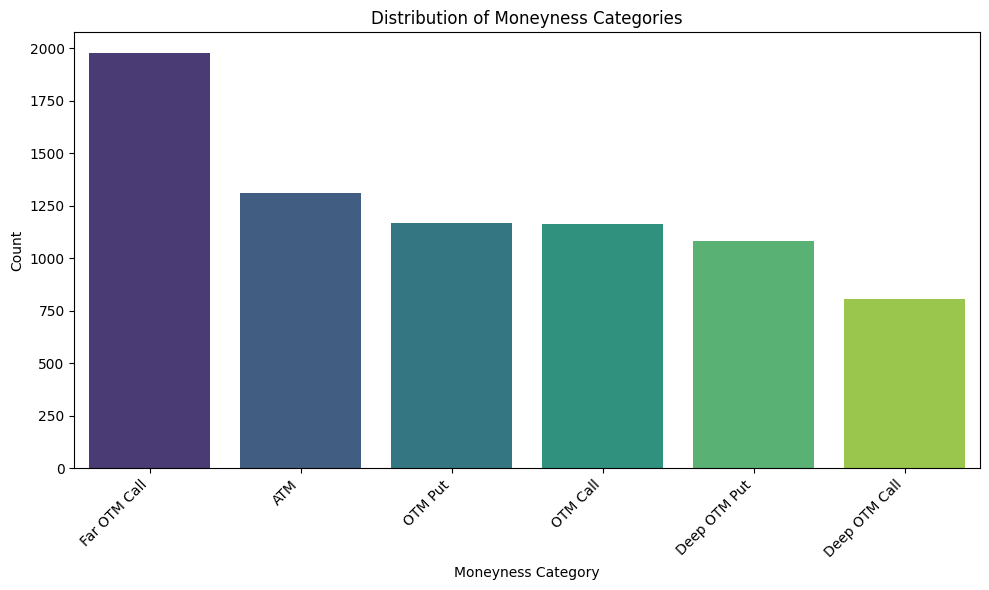

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_features, x='Moneyness_Category', palette='viridis', order=combined_features['Moneyness_Category'].value_counts().index)
plt.title('Distribution of Moneyness Categories')
plt.xlabel('Moneyness Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# **Step 2.2: Feature Analysis and Selection**


Analyzing feature importance...


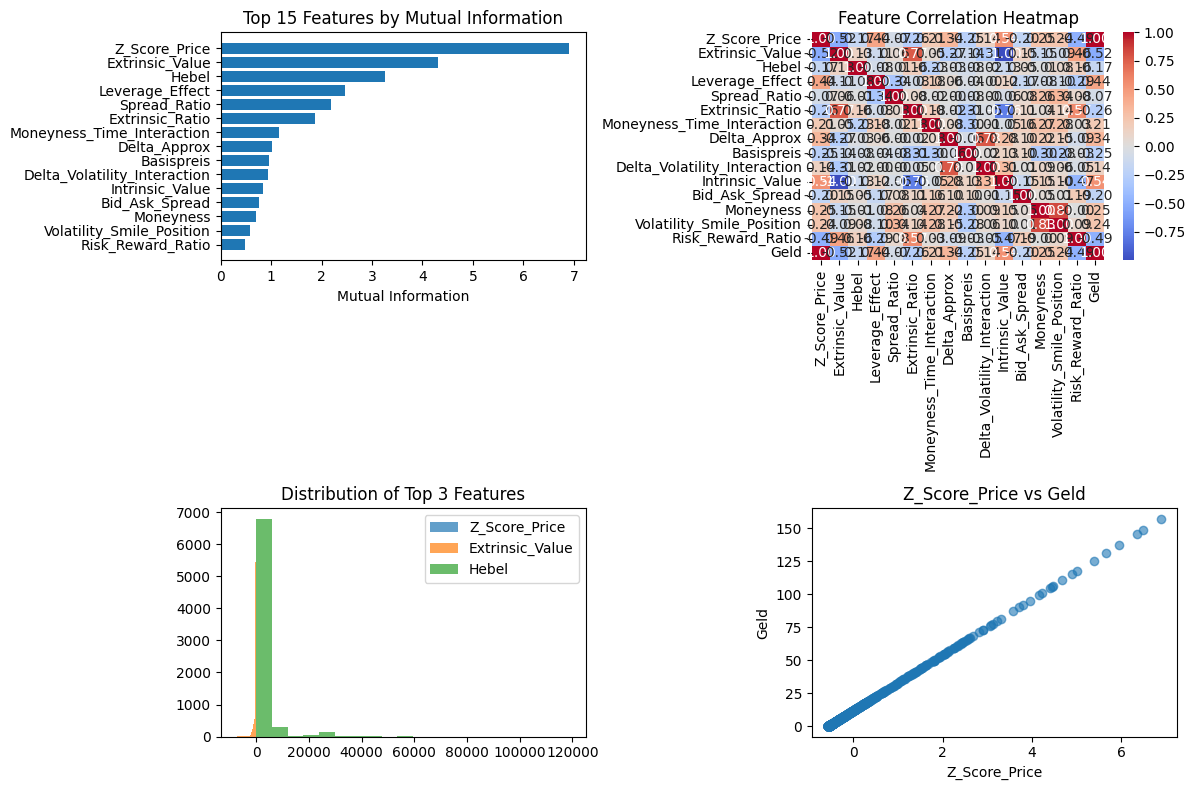


Top 10 Most Important Features:
                         Feature  Mutual_Information
18                 Z_Score_Price            6.898916
6                Extrinsic_Value            4.301506
2                          Hebel            3.249793
12               Leverage_Effect            2.459924
15                  Spread_Ratio            2.187694
7                Extrinsic_Ratio            1.864077
16    Moneyness_Time_Interaction            1.159142
8                   Delta_Approx            1.015854
0                     Basispreis            0.952860
17  Delta_Volatility_Interaction            0.932258


In [ ]:
def analyze_features(df, target_col='Geld'):
    """Analyze feature importance and relationships"""

    # Prepare data for analysis
    analysis_df = df.copy()

    # Encode categorical variables
    categorical_cols = ['Typ', 'Source', 'Moneyness_Category']
    for col in categorical_cols:
        if col in analysis_df.columns:
            le = LabelEncoder()
            analysis_df[col + '_Encoded'] = le.fit_transform(analysis_df[col].astype(str))

    # Select numerical features for analysis
    numerical_features = [
        'Basispreis', 'Kurs_Basiswert', 'Hebel', 'Moneyness', 'Days_to_Expiry',
        'Intrinsic_Value', 'Extrinsic_Value', 'Extrinsic_Ratio', 'Delta_Approx',
        'Gamma_Approx', 'Time_To_Expiry_Years', 'Volatility_Smile_Position',
        'Leverage_Effect', 'Risk_Reward_Ratio', 'Bid_Ask_Spread', 'Spread_Ratio',
        'Moneyness_Time_Interaction', 'Delta_Volatility_Interaction', 'Z_Score_Price'
    ]

    # Filter available features
    available_features = [f for f in numerical_features if f in analysis_df.columns]

    # Add encoded categorical features
    encoded_categorical = [f for f in analysis_df.columns if '_Encoded' in f]
    available_features.extend(encoded_categorical)

    # Remove features with too many missing values
    feature_df = analysis_df[available_features + [target_col]].copy()
    feature_df = feature_df.dropna()

    if len(feature_df) == 0:
        print("No data available for feature analysis after cleaning")
        return None, None

    # Calculate mutual information
    X = feature_df[available_features]
    y = feature_df[target_col]

    mi_scores = mutual_info_regression(X, y, random_state=42)
    mi_df = pd.DataFrame({
        'Feature': available_features,
        'Mutual_Information': mi_scores
    }).sort_values('Mutual_Information', ascending=False)

    # Visualization
    plt.figure(figsize=(12, 8))

    # Top 15 features by mutual information
    top_features = mi_df.head(15)

    plt.subplot(2, 2, 1)
    plt.barh(top_features['Feature'], top_features['Mutual_Information'])
    plt.xlabel('Mutual Information')
    plt.title('Top 15 Features by Mutual Information')
    plt.gca().invert_yaxis()

    # Correlation heatmap for top features
    plt.subplot(2, 2, 2)
    top_feature_names = top_features['Feature'].tolist()
    correlation_matrix = feature_df[top_feature_names + [target_col]].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Feature Correlation Heatmap')

    # Feature distributions
    plt.subplot(2, 2, 3)
    for i, feature in enumerate(top_feature_names[:3]):
        plt.hist(feature_df[feature].values, alpha=0.7, label=feature, bins=20)
    plt.legend()
    plt.title('Distribution of Top 3 Features')

    # Feature vs Target
    plt.subplot(2, 2, 4)
    if len(feature_df) > 0:
        sample_df = feature_df.sample(min(1000, len(feature_df)))
        plt.scatter(sample_df[top_feature_names[0]], sample_df[target_col], alpha=0.6)
        plt.xlabel(top_feature_names[0])
        plt.ylabel(target_col)
        plt.title(f'{top_feature_names[0]} vs {target_col}')

    plt.tight_layout()
    plt.show()

    return mi_df, feature_df

print("Analyzing feature importance...")
mi_results, feature_data = analyze_features(combined_features)

if mi_results is not None:
    print("\nTop 10 Most Important Features:")
    print(mi_results.head(10))

# **Step 2.3: Feature Analysis and Selection**


In [ ]:
def create_feature_pipeline():
    """Create preprocessing pipeline for ML models"""

    # Define feature groups
    numerical_features = [
        'Basispreis', 'Kurs_Basiswert', 'Hebel', 'Moneyness', 'Days_to_Expiry',
        'Intrinsic_Value', 'Extrinsic_Value', 'Extrinsic_Ratio', 'Delta_Approx',
        'Gamma_Approx', 'Time_To_Expiry_Years', 'Volatility_Smile_Position',
        'Leverage_Effect', 'Risk_Reward_Ratio', 'Bid_Ask_Spread', 'Spread_Ratio',
        'Moneyness_Time_Interaction', 'Delta_Volatility_Interaction'
    ]

    categorical_features = ['Typ', 'Source', 'Moneyness_Category']

    # Create transformers
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('power_transform', PowerTransformer(method='yeo-johnson'))
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor

def prepare_ml_data(df, target_col='Geld', test_size=0.2):
    """Prepare data for machine learning models"""

    # Select features
    feature_columns = [
        'Basispreis', 'Kurs_Basiswert', 'Hebel', 'Moneyness', 'Days_to_Expiry',
        'Intrinsic_Value', 'Extrinsic_Value', 'Extrinsic_Ratio', 'Delta_Approx',
        'Gamma_Approx', 'Time_To_Expiry_Years', 'Volatility_Smile_Position',
        'Leverage_Effect', 'Risk_Reward_Ratio', 'Bid_Ask_Spread', 'Spread_Ratio',
        'Moneyness_Time_Interaction', 'Delta_Volatility_Interaction',
        'Typ', 'Source', 'Moneyness_Category'
    ]

    # Filter available features
    available_features = [f for f in feature_columns if f in df.columns]

    # Prepare X and y
    X = df[available_features].copy()
    y = df[target_col].copy()

    # Remove rows where target is missing
    valid_indices = y.notna()
    X = X[valid_indices]
    y = y[valid_indices]

    # Create preprocessing pipeline
    preprocessor = create_feature_pipeline()

    # Fit and transform features
    X_processed = preprocessor.fit_transform(X)

    # Get feature names after preprocessing
    feature_names = []

    # Numerical feature names
    numerical_features = [f for f in available_features if f in [
        'Basispreis', 'Kurs_Basiswert', 'Hebel', 'Moneyness', 'Days_to_Expiry',
        'Intrinsic_Value', 'Extrinsic_Value', 'Extrinsic_Ratio', 'Delta_Approx',
        'Gamma_Approx', 'Time_To_Expiry_Years', 'Volatility_Smile_Position',
        'Leverage_Effect', 'Risk_Reward_Ratio', 'Bid_Ask_Spread', 'Spread_Ratio',
        'Moneyness_Time_Interaction', 'Delta_Volatility_Interaction'
    ]]
    feature_names.extend(numerical_features)

    # Categorical feature names
    for col in ['Typ', 'Source', 'Moneyness_Category']:
        if col in available_features:
            unique_vals = X[col].unique()
            for val in unique_vals:
                feature_names.append(f"{col}_{val}")

    # Split data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y, test_size=test_size, random_state=42
    )

    print(f"Training set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")
    print(f"Number of features: {X_train.shape[1]}")

    return X_train, X_test, y_train, y_test, preprocessor, feature_names

# Prepare data for ML
print("Preparing data for machine learning...")
X_train, X_test, y_train, y_test, preprocessor, feature_names = prepare_ml_data(combined_features)

print(f"Feature names: {feature_names[:10]}...")  # Show first 10 features


Preparing data for machine learning...
Training set size: (6005, 29)
Test set size: (1502, 29)
Number of features: 29
Feature names: ['Basispreis', 'Kurs_Basiswert', 'Hebel', 'Moneyness', 'Days_to_Expiry', 'Intrinsic_Value', 'Extrinsic_Value', 'Extrinsic_Ratio', 'Delta_Approx', 'Gamma_Approx']...


# **Step 2.4: Advanced Feature Engineering for Time Series**

In [ ]:
def create_time_series_features(price_data, options_data, lookback_periods=[5, 10, 20]):
    """Create time-series features from underlying price data"""

    if price_data is None or len(price_data) == 0:
        return options_data

    ts_features = options_data.copy()

    # Calculate returns and volatilities
    returns = price_data['Close'].pct_change().dropna()

    for period in lookback_periods:
        # Rolling returns
        if len(returns) >= period:
            ts_features[f'Rolling_Return_{period}'] = returns.rolling(period).mean().iloc[-1]
            ts_features[f'Rolling_Volatility_{period}'] = returns.rolling(period).std().iloc[-1]

            # Technical indicators
            ts_features[f'RSI_{period}'] = ta.momentum.RSIIndicator(
                price_data['Close'], window=period
            ).rsi().iloc[-1] if len(price_data) > period else np.nan

            ts_features[f'MACD_{period}'] = ta.trend.MACD(
                price_data['Close'], window_slow=26, window_fast=12, window_sign=9
            ).macd().iloc[-1] if len(price_data) > 26 else np.nan

    # Price levels relative to recent history
    if len(price_data) > 20:
        recent_high = price_data['Close'].rolling(20).max().iloc[-1]
        recent_low = price_data['Close'].rolling(20).min().iloc[-1]
        current_price = price_data['Close'].iloc[-1]

        ts_features['Price_Relative_To_High'] = current_price / recent_high
        ts_features['Price_Relative_To_Low'] = current_price / recent_low
        ts_features['Price_Position_Range'] = (current_price - recent_low) / (recent_high - recent_low)

    return ts_features

# Apply time series features to each underlying
def enhance_with_market_features(options_df, price_data_dict):
    """Enhance options data with market features"""

    enhanced_df = options_df.copy()

    for source in enhanced_df['Source'].unique():
        source_mask = enhanced_df['Source'] == source

        if source in price_data_dict and price_data_dict[source] is not None:
            source_price_data = price_data_dict[source]
            source_ts_features = create_time_series_features(source_price_data, enhanced_df[source_mask])

            # Merge time series features
            for col in [c for c in source_ts_features.columns if c not in enhanced_df.columns]:
                enhanced_df.loc[source_mask, col] = source_ts_features[col]

    return enhanced_df

# Create price data dictionary
price_data_dict = {
    'Gold': gold_prices,
    'DAX40': dax_prices,
    'EURUSD': eurusd_prices
}

# Enhance with market features
print("Adding market time series features...")
combined_enhanced = enhance_with_market_features(combined_features, price_data_dict)

print("Enhanced features completed!")
print(f"Total features after enhancement: {len(combined_enhanced.columns)}")


Adding market time series features...
Enhanced features completed!
Total features after enhancement: 64


# **Step 2.5: Feature Validation and Selection**

Validating feature importance...


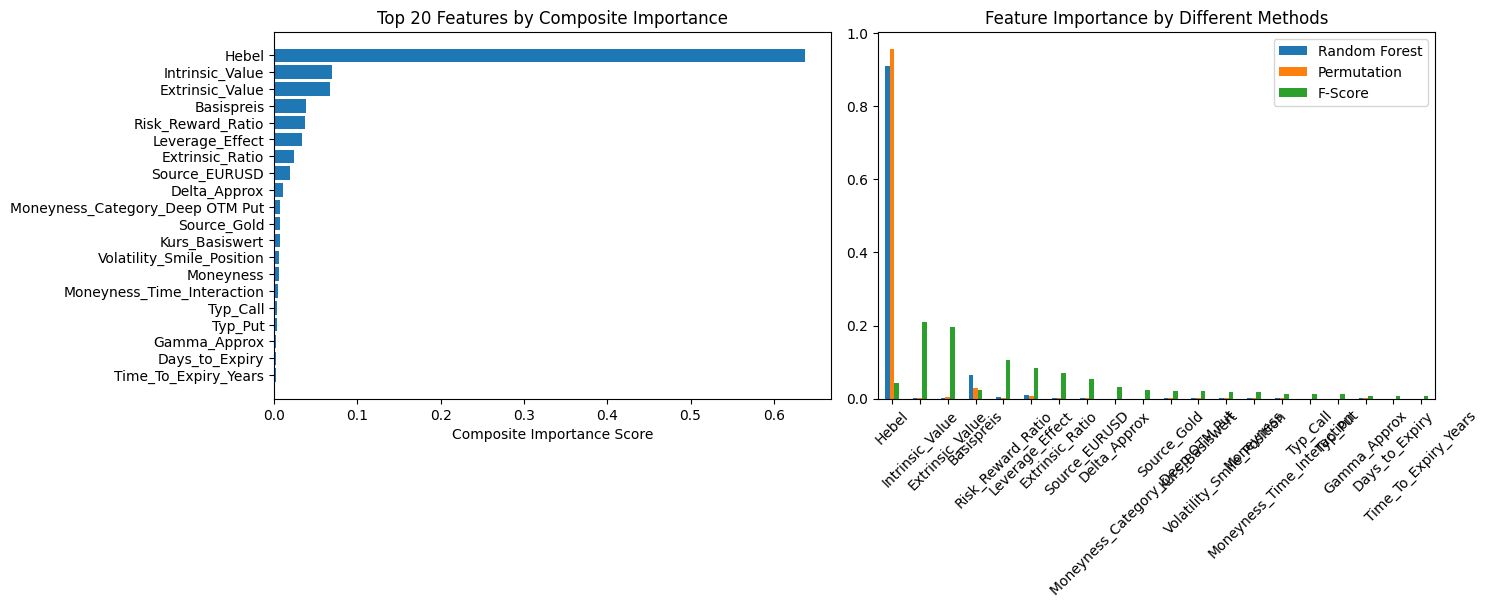


Top 15 Most Important Features:
                            Feature  Composite_Score
0                             Hebel         0.637195
8                   Intrinsic_Value         0.070109
4                   Extrinsic_Value         0.067331
1                        Basispreis         0.038687
3                 Risk_Reward_Ratio         0.036727
2                   Leverage_Effect         0.033163
6                   Extrinsic_Ratio         0.023972
5                     Source_EURUSD         0.019259
18                     Delta_Approx         0.010898
22  Moneyness_Category_Deep OTM Put         0.007459
17                      Source_Gold         0.007136
9                    Kurs_Basiswert         0.006872
14        Volatility_Smile_Position         0.005881
13                        Moneyness         0.005876
16       Moneyness_Time_Interaction         0.004429


In [ ]:
def validate_features(X_train, y_train, X_test, y_test, feature_names):
    """Validate feature importance using multiple methods"""

    # Method 1: Random Forest Feature Importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    rf_importance = pd.DataFrame({
        'Feature': feature_names,
        'RF_Importance': rf.feature_importances_
    }).sort_values('RF_Importance', ascending=False)

    # Method 2: Permutation Importance
    perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
    perm_df = pd.DataFrame({
        'Feature': feature_names,
        'Permutation_Importance': perm_importance.importances_mean,
        'Permutation_Std': perm_importance.importances_std
    }).sort_values('Permutation_Importance', ascending=False)

    # Method 3: Statistical Feature Selection
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X_train, y_train)

    stat_df = pd.DataFrame({
        'Feature': feature_names,
        'F_Score': selector.scores_,
        'P_Value': selector.pvalues_
    }).sort_values('F_Score', ascending=False)

    # Combine results
    combined_importance = rf_importance.merge(
        perm_df[['Feature', 'Permutation_Importance']], on='Feature'
    ).merge(
        stat_df[['Feature', 'F_Score']], on='Feature'
    )

    # Normalize scores
    for col in ['RF_Importance', 'Permutation_Importance', 'F_Score']:
        combined_importance[col + '_Norm'] = (
            combined_importance[col] / combined_importance[col].sum()
        )

    # Calculate composite score
    combined_importance['Composite_Score'] = (
        combined_importance['RF_Importance_Norm'] +
        combined_importance['Permutation_Importance_Norm'] +
        combined_importance['F_Score_Norm']
    ) / 3

    combined_importance = combined_importance.sort_values('Composite_Score', ascending=False)

    # Visualization
    plt.figure(figsize=(15, 10))

    # Top 20 features by composite score
    top_features = combined_importance.head(20)

    plt.subplot(2, 2, 1)
    plt.barh(top_features['Feature'], top_features['Composite_Score'])
    plt.xlabel('Composite Importance Score')
    plt.title('Top 20 Features by Composite Importance')
    plt.gca().invert_yaxis()

    plt.subplot(2, 2, 2)
    importance_metrics = ['RF_Importance_Norm', 'Permutation_Importance_Norm', 'F_Score_Norm']
    top_features[importance_metrics].plot(kind='bar', ax=plt.gca())
    plt.xticks(range(len(top_features)), top_features['Feature'], rotation=45)
    plt.title('Feature Importance by Different Methods')
    plt.legend(['Random Forest', 'Permutation', 'F-Score'])

    plt.tight_layout()
    plt.show()

    return combined_importance

print("Validating feature importance...")
feature_importance = validate_features(X_train, y_train, X_test, y_test, feature_names)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15)[['Feature', 'Composite_Score']])


# **Step 2.6: Save Engineered Features**

In [ ]:
# Save all engineered features
combined_features.to_csv('options_with_engineered_features.csv', index=False)
combined_enhanced.to_csv('options_with_market_features.csv', index=False)
feature_importance.to_csv('feature_importance_scores.csv', index=False)

# Save processed ML data
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

# Save feature names and preprocessor
import joblib
joblib.dump(preprocessor, 'feature_preprocessor.pkl')
joblib.dump(feature_names, 'feature_names.pkl')

print("\nFeature engineering completed successfully!")
print(f"Total features created: {len(combined_enhanced.columns)}")
print("\nNext steps ready for:")
print("1. Tree-based models (Random Forest, XGBoost, LightGBM)")
print("2. Neural Networks (LSTM, GRU)")
print("3. Portfolio optimization models")


Feature engineering completed successfully!
Total features created: 64

Next steps ready for:
1. Tree-based models (Random Forest, XGBoost, LightGBM)
2. Neural Networks (LSTM, GRU)
3. Portfolio optimization models


#**3. Tree-Based Model Implementation**
**Purpose:** Implements three powerful machine learning algorithms to predict option prices.

**Models Used:**

*  XGBoost: Extreme Gradient Boosting - handles complex non-linear relationships
*  LightGBM: Light Gradient Boosting - optimized for speed and efficiency
*  Random Forest: Ensemble of decision trees - robust against overfitting

**Advanced Techniques:**

*  Hyperparameter optimization using Optuna for peak performance
*  Cross-validation ensures model robustness
*  Ensemble methods combine strengths of all three models
*  SHAP analysis provides model interpretability

Here's comprehensive implementation of tree-based models (XGBoost, LightGBM, and Random Forest) for options portfolio optimization:






# **3.1. Load Preprocessed Data**

In [ ]:
# Load the preprocessed features and data
def load_processed_data():
    """Load the preprocessed data from feature engineering"""
    try:
        X_train = np.load('X_train.npy')
        X_test = np.load('X_test.npy')
        y_train = np.load('y_train.npy')
        y_test = np.load('y_test.npy')
        preprocessor = joblib.load('feature_preprocessor.pkl')
        feature_names = joblib.load('feature_names.pkl')

        print("Data loaded successfully!")
        print(f"X_train shape: {X_train.shape}")
        print(f"X_test shape: {X_test.shape}")
        print(f"Number of features: {len(feature_names)}")

        return X_train, X_test, y_train, y_test, preprocessor, feature_names
    except:
        print("Processed data not found. Running feature engineering first...")
        # If data not found, you'll need to run the previous feature engineering code
        return None

X_train, X_test, y_train, y_test, preprocessor, feature_names = load_processed_data()

# If data loading failed, recreate it
if X_train is None:
    # Re-run the feature engineering code from previous section
    print("Please run the feature engineering code first.")
else:
    print("Data ready for model training!")

Data loaded successfully!
X_train shape: (6005, 29)
X_test shape: (1502, 29)
Number of features: 29
Data ready for model training!


#**3.2. Model Evaluation Framework**

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    """Comprehensive model evaluation"""
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100,
        'Max Error': np.max(np.abs(y_true - y_pred))
    }

    print(f"\n{model_name} Performance:")
    print("-" * 40)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.6f}")

    return metrics

def plot_predictions(y_true, y_pred, model_name):
    """Visualize prediction results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Scatter plot
    axes[0, 0].scatter(y_true, y_pred, alpha=0.6)
    axes[0, 0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('True Values')
    axes[0, 0].set_ylabel('Predicted Values')
    axes[0, 0].set_title(f'{model_name} - True vs Predicted')

    # Residuals plot
    residuals = y_true - y_pred
    axes[0, 1].scatter(y_pred, residuals, alpha=0.6)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Values')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title(f'{model_name} - Residuals')

    # Distribution comparison
    axes[1, 0].hist(y_true, bins=50, alpha=0.7, label='True', density=True)
    axes[1, 0].hist(y_pred, bins=50, alpha=0.7, label='Predicted', density=True)
    axes[1, 0].set_xlabel('Option Price')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title(f'{model_name} - Distribution Comparison')
    axes[1, 0].legend()

    # Error distribution
    axes[1, 1].hist(residuals, bins=50, alpha=0.7, color='orange')
    axes[1, 1].set_xlabel('Prediction Error')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title(f'{model_name} - Error Distribution')

    plt.tight_layout()
    plt.show()

#**3.3. XGBoost Implementation**

Training XGBoost Model...


[I 2026-02-14 11:15:44,574] A new study created in memory with name: no-name-4229ce38-f86a-40a3-81d6-159589d06dc4



XGBoost Base Performance:
----------------------------------------
RMSE: 0.329682
MAE: 0.130416
R2: 0.999762
MAPE: 74.749115
Max Error: 5.235833


[I 2026-02-14 11:15:45,887] Trial 0 finished with value: 0.1270060044028892 and parameters: {'n_estimators': 855, 'max_depth': 4, 'learning_rate': 0.14451521278035193, 'subsample': 0.69942949049486, 'colsample_bytree': 0.8159212114230031, 'reg_alpha': 0.09428437849289062, 'reg_lambda': 0.06513104060969199}. Best is trial 0 with value: 0.1270060044028892.
[I 2026-02-14 11:15:46,943] Trial 1 finished with value: 0.18654925842687262 and parameters: {'n_estimators': 309, 'max_depth': 5, 'learning_rate': 0.2874563360945021, 'subsample': 0.7582600810726263, 'colsample_bytree': 0.7474812098338088, 'reg_alpha': 0.5267185480036913, 'reg_lambda': 0.4710722752040639}. Best is trial 0 with value: 0.1270060044028892.
[I 2026-02-14 11:15:51,446] Trial 2 finished with value: 0.19724216327728125 and parameters: {'n_estimators': 731, 'max_depth': 10, 'learning_rate': 0.21556172299295773, 'subsample': 0.7347245574930933, 'colsample_bytree': 0.6088914463991312, 'reg_alpha': 0.6810601431866747, 'reg_lambd

Best XGBoost hyperparameters: {'n_estimators': 884, 'max_depth': 7, 'learning_rate': 0.07831946820896099, 'subsample': 0.9596878392439157, 'colsample_bytree': 0.8552023050354361, 'reg_alpha': 0.862886741404535, 'reg_lambda': 0.8968645176983567}
Best XGBoost MSE: 0.079453

XGBoost Optimized Performance:
----------------------------------------
RMSE: 0.281874
MAE: 0.117952
R2: 0.999826
MAPE: 10.937252
Max Error: 2.544218


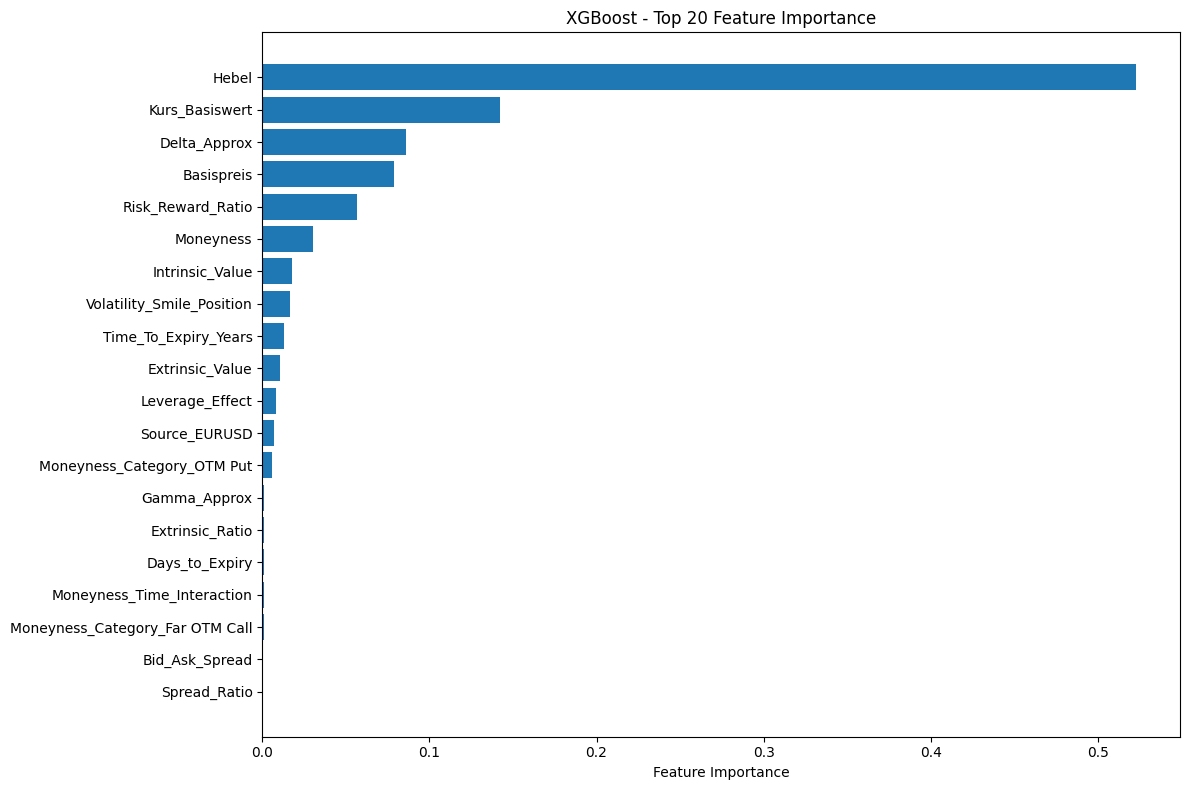

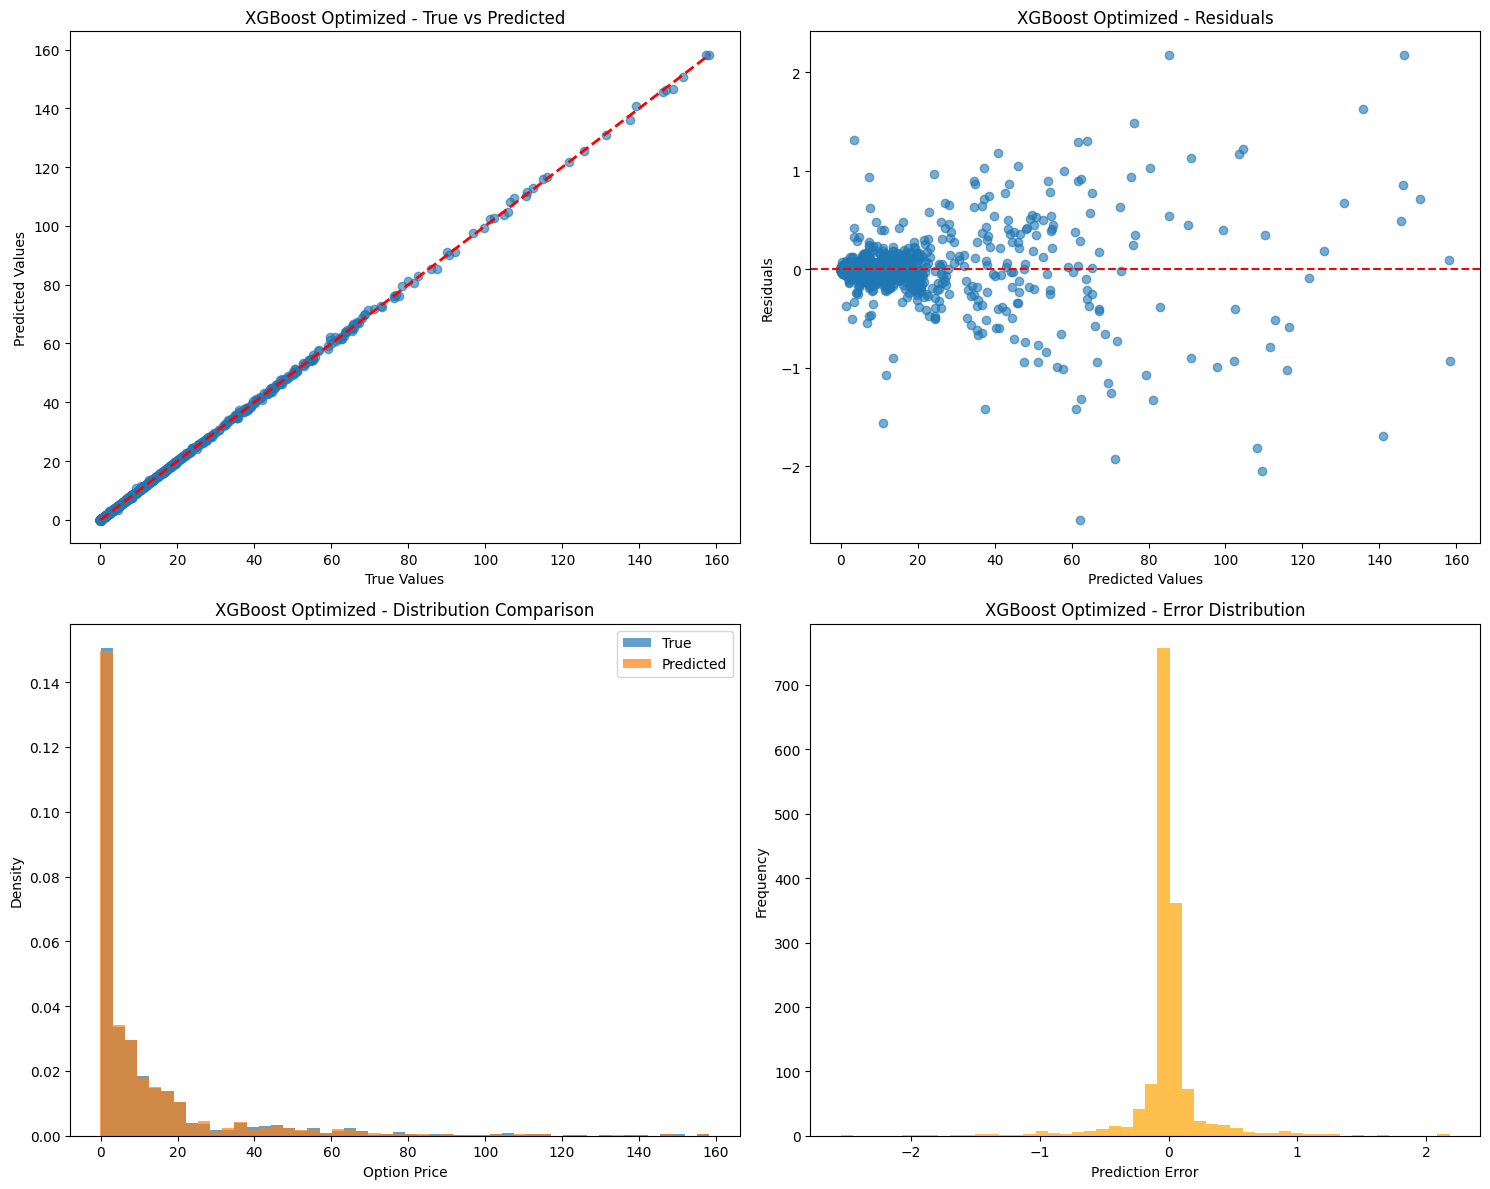

In [ ]:
def train_xgboost(X_train, y_train, X_test, y_test, feature_names):
    """Train and evaluate XGBoost model with hyperparameter optimization"""

    print("Training XGBoost Model...")

    # Base XGBoost model
    xgb_base = xgb.XGBRegressor(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6
    )

    xgb_base.fit(X_train, y_train)
    y_pred_base = xgb_base.predict(X_test)
    base_metrics = evaluate_model(y_test, y_pred_base, "XGBoost Base")

    # Hyperparameter tuning with Optuna
    def objective_xgb(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
            'random_state': 42
        }

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return mean_squared_error(y_test, y_pred)

    # Run optimization
    study_xgb = optuna.create_study(direction='minimize')
    study_xgb.optimize(objective_xgb, n_trials=50)

    print(f"Best XGBoost hyperparameters: {study_xgb.best_params}")
    print(f"Best XGBoost MSE: {study_xgb.best_value:.6f}")

    # Train final model with best parameters
    xgb_optimized = xgb.XGBRegressor(**study_xgb.best_params, random_state=42)
    xgb_optimized.fit(X_train, y_train)
    y_pred_optimized = xgb_optimized.predict(X_test)
    optimized_metrics = evaluate_model(y_test, y_pred_optimized, "XGBoost Optimized")

    # Feature importance
    plt.figure(figsize=(12, 8))
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': xgb_optimized.feature_importances_
    }).sort_values('importance', ascending=False).head(20)

    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Feature Importance')
    plt.title('XGBoost - Top 20 Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Plot predictions
    plot_predictions(y_test, y_pred_optimized, "XGBoost Optimized")

    return xgb_optimized, optimized_metrics, study_xgb.best_params

# Train XGBoost model
xgb_model, xgb_metrics, xgb_best_params = train_xgboost(
    X_train, y_train, X_test, y_test, feature_names
)

#**3.4. LightGBM Implementation**


Training LightGBM Model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672


[I 2026-02-14 11:18:33,104] A new study created in memory with name: no-name-26adf635-41a7-4e31-a5cd-8c8e4b10f56c


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-14 11:18:34,261] Trial 0 finished with value: 0.14037573525601363 and parameters: {'n_estimators': 514, 'max_depth': 9, 'learning_rate': 0.04228312959768576, 'num_leaves': 23, 'subsample': 0.9176457704966402, 'colsample_bytree': 0.6290088083874937, 'reg_alpha': 0.7132339782348659, 'reg_lambda': 0.6874635578166151}. Best is trial 0 with value: 0.14037573525601363.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:18:35,461] Trial 1 finished with value: 0.11619410447380804 and parameters: {'n_estimators': 451, 'max_depth': 11, 'learning_rate': 0.2596137416668326, 'num_leaves': 41, 'subsample': 0.7911644714658542, 'colsample_bytree': 0.8975794747725309, 'reg_alpha': 0.09766017974731156, 'reg_lambda': 0.9375606219989937}. Best is trial 1 with value: 0.11619410447380804.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:18:37,328] Trial 2 finished with value: 0.2445602598419575 and parameters: {'n_estimators': 558, 'max_depth': 12, 'learning_rate': 0.013559716066941147, 'num_leaves': 80, 'subsample': 0.6928919527831279, 'colsample_bytree': 0.668752703066202, 'reg_alpha': 0.6871299838905903, 'reg_lambda': 0.7617240271635096}. Best is trial 1 with value: 0.11619410447380804.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:18:38,897] Trial 3 finished with value: 0.1560928849167537 and parameters: {'n_estimators': 903, 'max_depth': 7, 'learning_rate': 0.2933511866099811, 'num_leaves': 32, 'subsample': 0.6398492530993122, 'colsample_bytree': 0.6316100167277586, 'reg_alpha': 0.5798510146843932, 'reg_lambda': 0.6601078059399426}. Best is trial 1 with value: 0.11619410447380804.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:18:39,410] Trial 4 finished with value: 0.4752201718452368 and parameters: {'n_estimators': 701, 'max_depth': 3, 'learning_rate': 0.015866593919416166, 'num_leaves': 93, 'subsample': 0.786743039188708, 'colsample_bytree': 0.6706775406633062, 'reg_alpha': 0.672613804780084, 'reg_lambda': 0.969011886204087}. Best is trial 1 with value: 0.11619410447380804.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:18:41,197] Trial 5 finished with value: 0.11289118602391941 and parameters: {'n_estimators': 634, 'max_depth': 10, 'learning_rate': 0.14668975641913587, 'num_leaves': 84, 'subsample': 0.6136199371344092, 'colsample_bytree': 0.6050015740028941, 'reg_alpha': 0.1766677213815021, 'reg_lambda': 0.4165627673437635}. Best is trial 5 with value: 0.11289118602391941.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:18:42,136] Trial 6 finished with value: 0.2775154201938013 and parameters: {'n_estimators': 482, 'max_depth': 3, 'learning_rate': 0.07316077275677733, 'num_leaves': 20, 'subsample': 0.6699156778760185, 'colsample_bytree': 0.6004889362358973, 'reg_alpha': 0.5240355092588792, 'reg_lambda': 0.5482342297495759}. Best is trial 5 with value: 0.11289118602391941.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2026-02-14 11:18:45,120] Trial 7 finished with value: 0.12100089618443227 and parameters: {'n_estimators': 409, 'max_depth': 10, 'learning_rate': 0.12107999354704485, 'num_leaves': 44, 'subsample': 0.9855215955507227, 'colsample_bytree': 0.9275731921960582, 'reg_alpha': 0.8759694577977154, 'reg_lambda': 0.5936686277757378}. Best is trial 5 with value: 0.11289118602391941.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:18:51,466] Trial 8 finished with value: 0.10460444412638477 and parameters: {'n_estimators': 756, 'max_depth': 12, 'learning_rate': 0.06238767866738122, 'num_leaves': 74, 'subsample': 0.7842254732894359, 'colsample_bytree': 0.8040706089954197, 'reg_alpha': 0.7121817684197709, 'reg_lambda': 0.8528810796661982}. Best is trial 8 with value: 0.10460444412638477.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:18:53,155] Trial 9 finished with value: 0.1682302279140446 and parameters: {'n_estimators': 637, 'max_depth': 4, 'learning_rate': 0.031693148235617585, 'num_leaves': 74, 'subsample': 0.9135335421090698, 'colsample_bytree': 0.9140279985263449, 'reg_alpha': 0.013796380044102219, 'reg_lambda': 0.5126124130746439}. Best is trial 8 with value: 0.10460444412638477.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:18:53,550] Trial 10 finished with value: 0.14761631798542713 and parameters: {'n_estimators': 101, 'max_depth': 7, 'learning_rate': 0.19724224317407493, 'num_leaves': 63, 'subsample': 0.7418527851513402, 'colsample_bytree': 0.8001996223960719, 'reg_alpha': 0.3376691302872138, 'reg_lambda': 0.11068953316746472}. Best is trial 8 with value: 0.10460444412638477.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-14 11:19:02,478] Trial 11 finished with value: 0.11342335418546332 and parameters: {'n_estimators': 852, 'max_depth': 12, 'learning_rate': 0.14692003270064274, 'num_leaves': 98, 'subsample': 0.6069918527062755, 'colsample_bytree': 0.8002504468274225, 'reg_alpha': 0.35852445628325347, 'reg_lambda': 0.22211881406409784}. Best is trial 8 with value: 0.10460444412638477.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2026-02-14 11:19:06,588] Trial 12 finished with value: 0.0998539380052768 and parameters: {'n_estimators': 806, 'max_depth': 9, 'learning_rate': 0.09963546026505593, 'num_leaves': 82, 'subsample': 0.8715869678441657, 'colsample_bytree': 0.7380098642066292, 'reg_alpha': 0.940047718012742, 'reg_lambda': 0.32189793111514176}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:10,809] Trial 13 finished with value: 0.11231596346819638 and parameters: {'n_estimators': 995, 'max_depth': 8, 'learning_rate': 0.10287152256875232, 'num_leaves': 64, 'subsample': 0.8754694204831733, 'colsample_bytree': 0.744968051918396, 'reg_alpha': 0.9830227519304169, 'reg_lambda': 0.3267093482612133}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:14,380] Trial 14 finished with value: 0.12472627403092529 and parameters: {'n_estimators': 790, 'max_depth': 5, 'learning_rate': 0.08459220169571213, 'num_leaves': 72, 'subsample': 0.8703622905688329, 'colsample_bytree': 0.7504854213821324, 'reg_alpha': 0.853557074584069, 'reg_lambda': 0.8334473901004635}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:16,486] Trial 15 finished with value: 0.1294264937410071 and parameters: {'n_estimators': 315, 'max_depth': 9, 'learning_rate': 0.19189058470975862, 'num_leaves': 52, 'subsample': 0.859707191056945, 'colsample_bytree': 0.85676988448785, 'reg_alpha': 0.8309792375773706, 'reg_lambda': 0.35209475084618863}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:19,170] Trial 16 finished with value: 0.11454785922028575 and parameters: {'n_estimators': 771, 'max_depth': 6, 'learning_rate': 0.06206185813235665, 'num_leaves': 88, 'subsample': 0.730026429835968, 'colsample_bytree': 0.9740578841424263, 'reg_alpha': 0.989254028447638, 'reg_lambda': 0.14026191528970777}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:21,760] Trial 17 finished with value: 0.11374574462756189 and parameters: {'n_estimators': 999, 'max_depth': 11, 'learning_rate': 0.19088406152280984, 'num_leaves': 73, 'subsample': 0.8239350061353812, 'colsample_bytree': 0.7437631667851355, 'reg_alpha': 0.779656874886245, 'reg_lambda': 0.0035531030743748415}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:24,196] Trial 18 finished with value: 0.1018810627580018 and parameters: {'n_estimators': 880, 'max_depth': 9, 'learning_rate': 0.1293039996383013, 'num_leaves': 57, 'subsample': 0.9987908148981106, 'colsample_bytree': 0.8461329171977967, 'reg_alpha': 0.4098707848422183, 'reg_lambda': 0.4189585089845802}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:26,694] Trial 19 finished with value: 0.1115230834796279 and parameters: {'n_estimators': 895, 'max_depth': 8, 'learning_rate': 0.12433872305259477, 'num_leaves': 56, 'subsample': 0.9930720236940062, 'colsample_bytree': 0.855921066655391, 'reg_alpha': 0.33799775252664543, 'reg_lambda': 0.4126891282765065}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:29,631] Trial 20 finished with value: 0.11521956631782825 and parameters: {'n_estimators': 867, 'max_depth': 9, 'learning_rate': 0.16817487088670618, 'num_leaves': 49, 'subsample': 0.944870997159761, 'colsample_bytree': 0.7199007550672918, 'reg_alpha': 0.4077652777064271, 'reg_lambda': 0.2810155969469784}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:31,841] Trial 21 finished with value: 0.10651871492913892 and parameters: {'n_estimators': 746, 'max_depth': 10, 'learning_rate': 0.100860287818869, 'num_leaves': 67, 'subsample': 0.8210150029321124, 'colsample_bytree': 0.8489173878865216, 'reg_alpha': 0.581343229851116, 'reg_lambda': 0.44599066382942776}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:33,842] Trial 22 finished with value: 0.11099118512912381 and parameters: {'n_estimators': 669, 'max_depth': 11, 'learning_rate': 0.061661822906604435, 'num_leaves': 81, 'subsample': 0.7579120213813334, 'colsample_bytree': 0.8288543435073539, 'reg_alpha': 0.45744145744727627, 'reg_lambda': 0.2235512916120701}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:35,323] Trial 23 finished with value: 0.10522863931695929 and parameters: {'n_estimators': 807, 'max_depth': 6, 'learning_rate': 0.1255701801772454, 'num_leaves': 77, 'subsample': 0.9131693346497354, 'colsample_bytree': 0.7780693034011376, 'reg_alpha': 0.9307013658635399, 'reg_lambda': 0.8420266049272878}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:37,558] Trial 24 finished with value: 0.10024655618190331 and parameters: {'n_estimators': 946, 'max_depth': 8, 'learning_rate': 0.09324518130602788, 'num_leaves': 91, 'subsample': 0.9595234774030763, 'colsample_bytree': 0.7036962917127664, 'reg_alpha': 0.7591982424883351, 'reg_lambda': 0.6296049822887376}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:39,838] Trial 25 finished with value: 0.10360740267855867 and parameters: {'n_estimators': 949, 'max_depth': 8, 'learning_rate': 0.09739589653614067, 'num_leaves': 100, 'subsample': 0.9591222618820833, 'colsample_bytree': 0.7120807569239812, 'reg_alpha': 0.21926077577230574, 'reg_lambda': 0.6038299960652043}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:42,314] Trial 26 finished with value: 0.13157662776363807 and parameters: {'n_estimators': 931, 'max_depth': 9, 'learning_rate': 0.22496151438328718, 'num_leaves': 91, 'subsample': 0.952440537780554, 'colsample_bytree': 0.6881930163175927, 'reg_alpha': 0.5962390136928607, 'reg_lambda': 0.45575537921762865}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:43,920] Trial 27 finished with value: 0.13197964854171138 and parameters: {'n_estimators': 843, 'max_depth': 7, 'learning_rate': 0.1713868778483648, 'num_leaves': 59, 'subsample': 0.9791177813062744, 'colsample_bytree': 0.77532473576905, 'reg_alpha': 0.7843486637458921, 'reg_lambda': 0.36063000870524387}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:45,580] Trial 28 finished with value: 0.11722063824654183 and parameters: {'n_estimators': 930, 'max_depth': 6, 'learning_rate': 0.13106394824292036, 'num_leaves': 86, 'subsample': 0.892202828460976, 'colsample_bytree': 0.6956594790220177, 'reg_alpha': 0.9120472521021623, 'reg_lambda': 0.7108700973690779}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:46,211] Trial 29 finished with value: 0.13812104346388454 and parameters: {'n_estimators': 277, 'max_depth': 10, 'learning_rate': 0.08639574044868933, 'num_leaves': 31, 'subsample': 0.9346164685208949, 'colsample_bytree': 0.6494517415553576, 'reg_alpha': 0.25182293269856265, 'reg_lambda': 0.5422577442456403}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-14 11:19:47,591] Trial 30 finished with value: 0.13564791871379753 and parameters: {'n_estimators': 562, 'max_depth': 8, 'learning_rate': 0.05174118284179641, 'num_leaves': 68, 'subsample': 0.8350850770225904, 'colsample_bytree': 0.9978742669514215, 'reg_alpha': 0.5135968509738956, 'reg_lambda': 0.6258208074214038}. Best is trial 12 with value: 0.0998539380052768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:49,580] Trial 31 finished with value: 0.09965678400818652 and parameters: {'n_estimators': 957, 'max_depth': 8, 'learning_rate': 0.1026551420697068, 'num_leaves': 99, 'subsample': 0.9629247344006379, 'colsample_bytree': 0.7211775820658696, 'reg_alpha': 0.2457304406882339, 'reg_lambda': 0.7178463992727168}. Best is trial 31 with value: 0.09965678400818652.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:52,088] Trial 32 finished with value: 0.09435209980782591 and parameters: {'n_estimators': 976, 'max_depth': 9, 'learning_rate': 0.10938045995747625, 'num_leaves': 95, 'subsample': 0.9998915100758765, 'colsample_bytree': 0.7122295930253015, 'reg_alpha': 0.28170963893825596, 'reg_lambda': 0.7318893581107102}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:54,864] Trial 33 finished with value: 0.10228400961348785 and parameters: {'n_estimators': 940, 'max_depth': 8, 'learning_rate': 0.10610116298897976, 'num_leaves': 95, 'subsample': 0.9718771700034281, 'colsample_bytree': 0.7291309008725169, 'reg_alpha': 0.2585159772690572, 'reg_lambda': 0.7502356530002844}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:56,918] Trial 34 finished with value: 0.10900927779467871 and parameters: {'n_estimators': 992, 'max_depth': 9, 'learning_rate': 0.04300142404619689, 'num_leaves': 90, 'subsample': 0.9233339523715696, 'colsample_bytree': 0.6842694292325948, 'reg_alpha': 0.14989888903409584, 'reg_lambda': 0.7865382876438769}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:19:58,268] Trial 35 finished with value: 0.1103269228303473 and parameters: {'n_estimators': 828, 'max_depth': 7, 'learning_rate': 0.08097892014156305, 'num_leaves': 96, 'subsample': 0.8926861132241578, 'colsample_bytree': 0.6451517447068995, 'reg_alpha': 0.06204729432873321, 'reg_lambda': 0.6803319727185575}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2026-02-14 11:20:00,231] Trial 36 finished with value: 0.10880643485765064 and parameters: {'n_estimators': 705, 'max_depth': 9, 'learning_rate': 0.1130565708397516, 'num_leaves': 84, 'subsample': 0.9649788772833199, 'colsample_bytree': 0.764157169942301, 'reg_alpha': 0.7894409501998739, 'reg_lambda': 0.7204732811308646}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:20:02,815] Trial 37 finished with value: 0.10577346620433639 and parameters: {'n_estimators': 955, 'max_depth': 11, 'learning_rate': 0.029925870598133814, 'num_leaves': 100, 'subsample': 0.9341331302554741, 'colsample_bytree': 0.7089078808824214, 'reg_alpha': 0.14483772852108961, 'reg_lambda': 0.897386919917261}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:20:05,488] Trial 38 finished with value: 0.16230739651412499 and parameters: {'n_estimators': 895, 'max_depth': 10, 'learning_rate': 0.29379676051887205, 'num_leaves': 93, 'subsample': 0.906199600306674, 'colsample_bytree': 0.6698186614732172, 'reg_alpha': 0.2758259856579607, 'reg_lambda': 0.789969322819067}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:20:07,921] Trial 39 finished with value: 0.11671224788378518 and parameters: {'n_estimators': 820, 'max_depth': 7, 'learning_rate': 0.14300942107246936, 'num_leaves': 80, 'subsample': 0.8500384365207837, 'colsample_bytree': 0.6324940938261293, 'reg_alpha': 0.6459742800046375, 'reg_lambda': 0.5756773327627225}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:20:09,917] Trial 40 finished with value: 0.11417759305683944 and parameters: {'n_estimators': 975, 'max_depth': 8, 'learning_rate': 0.1582098933663494, 'num_leaves': 89, 'subsample': 0.9737500104082313, 'colsample_bytree': 0.7261305465052224, 'reg_alpha': 0.10393901648580375, 'reg_lambda': 0.6410819117209884}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:20:12,566] Trial 41 finished with value: 0.0998566747267454 and parameters: {'n_estimators': 894, 'max_depth': 9, 'learning_rate': 0.1389663629630206, 'num_leaves': 94, 'subsample': 0.9986306393779734, 'colsample_bytree': 0.8225278326406891, 'reg_alpha': 0.42724081947121667, 'reg_lambda': 0.5201647481960591}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:20:15,232] Trial 42 finished with value: 0.10818793289187668 and parameters: {'n_estimators': 909, 'max_depth': 10, 'learning_rate': 0.08987124346621848, 'num_leaves': 94, 'subsample': 0.9926934648428192, 'colsample_bytree': 0.8232365196263678, 'reg_alpha': 0.4354954394248753, 'reg_lambda': 0.48117822913930564}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:20:16,903] Trial 43 finished with value: 0.11808798148703928 and parameters: {'n_estimators': 729, 'max_depth': 8, 'learning_rate': 0.07418159523995575, 'num_leaves': 84, 'subsample': 0.9525479060335896, 'colsample_bytree': 0.8909975317226837, 'reg_alpha': 0.3316035110811052, 'reg_lambda': 0.6762976325663012}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:20:19,667] Trial 44 finished with value: 0.10094746690136158 and parameters: {'n_estimators': 867, 'max_depth': 9, 'learning_rate': 0.11338497912404862, 'num_leaves': 96, 'subsample': 0.9994280226139249, 'colsample_bytree': 0.7763774487996292, 'reg_alpha': 0.30100485874645877, 'reg_lambda': 0.5244843179054987}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:20:21,849] Trial 45 finished with value: 0.12145318668232047 and parameters: {'n_estimators': 596, 'max_depth': 10, 'learning_rate': 0.13579799103676068, 'num_leaves': 88, 'subsample': 0.9352088331802819, 'colsample_bytree': 0.701029199683438, 'reg_alpha': 0.6379390396783855, 'reg_lambda': 0.7421702660500353}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:20:24,229] Trial 46 finished with value: 0.12299555711139545 and parameters: {'n_estimators': 914, 'max_depth': 9, 'learning_rate': 0.15711256932500084, 'num_leaves': 92, 'subsample': 0.9739630543623944, 'colsample_bytree': 0.7516136240052276, 'reg_alpha': 0.20232539512265338, 'reg_lambda': 0.5807346264421587}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:20:25,687] Trial 47 finished with value: 0.11896713674221901 and parameters: {'n_estimators': 787, 'max_depth': 7, 'learning_rate': 0.11284814325058995, 'num_leaves': 100, 'subsample': 0.8937138632813194, 'colsample_bytree': 0.6599570897611797, 'reg_alpha': 0.3818214678385198, 'reg_lambda': 0.9346525030074114}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2026-02-14 11:20:26,554] Trial 48 finished with value: 0.1278485751479101 and parameters: {'n_estimators': 418, 'max_depth': 8, 'learning_rate': 0.06904491851322633, 'num_leaves': 78, 'subsample': 0.9566110739305088, 'colsample_bytree': 0.6144174101039092, 'reg_alpha': 0.4732323956772581, 'reg_lambda': 0.6473028270971756}. Best is trial 32 with value: 0.09435209980782591.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-14 11:20:28,674] Trial 49 finished with value: 0.13830746276914427 and parameters: {'n_estimators': 962, 'max_depth': 9, 'learning_rate': 0.17725311041384598, 'num_leaves': 84, 'subsample': 0.6953287544925445, 'colsample_bytree': 0.8770864069835772, 'reg_alpha': 0.7269956495650068, 'reg_lambda': 0.7989951316183166}. Best is trial 32 with value: 0.09435209980782591.


Best LightGBM hyperparameters: {'n_estimators': 976, 'max_depth': 9, 'learning_rate': 0.10938045995747625, 'num_leaves': 95, 'subsample': 0.9998915100758765, 'colsample_bytree': 0.7122295930253015, 'reg_alpha': 0.28170963893825596, 'reg_lambda': 0.7318893581107102}
Best LightGBM MSE: 0.094352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3749
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.668672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

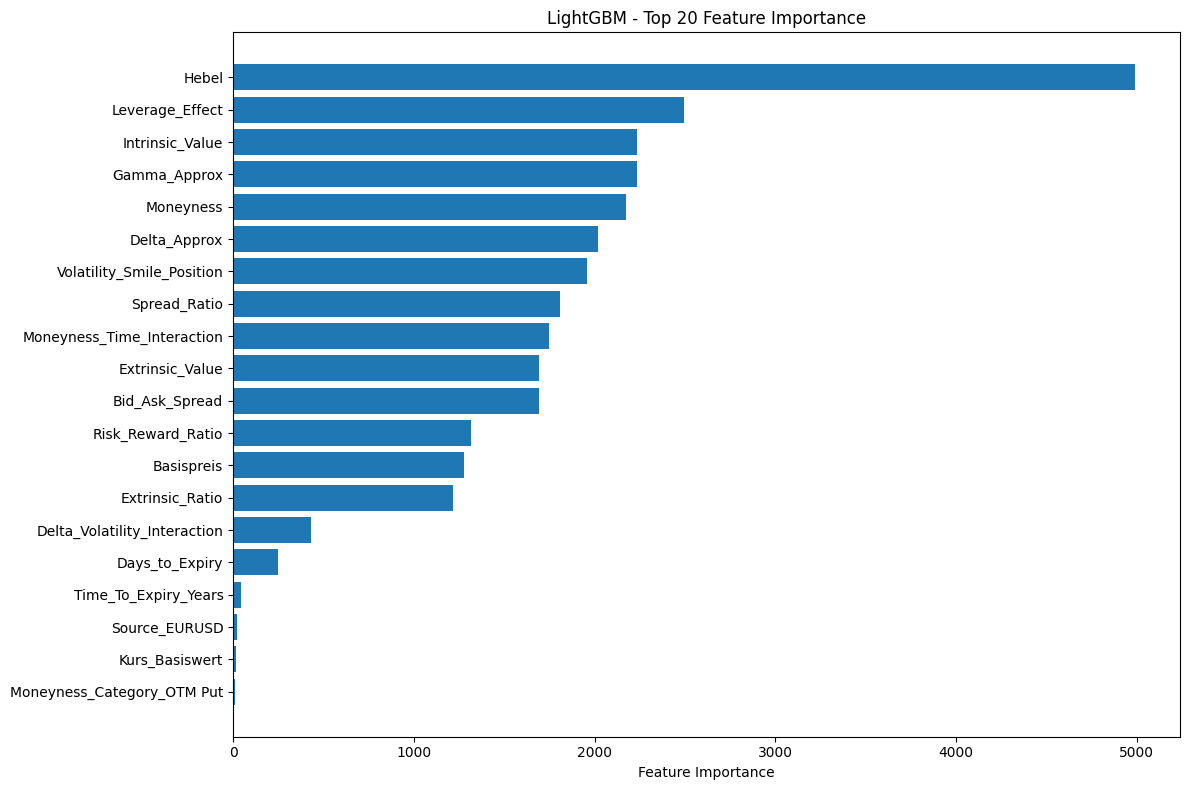

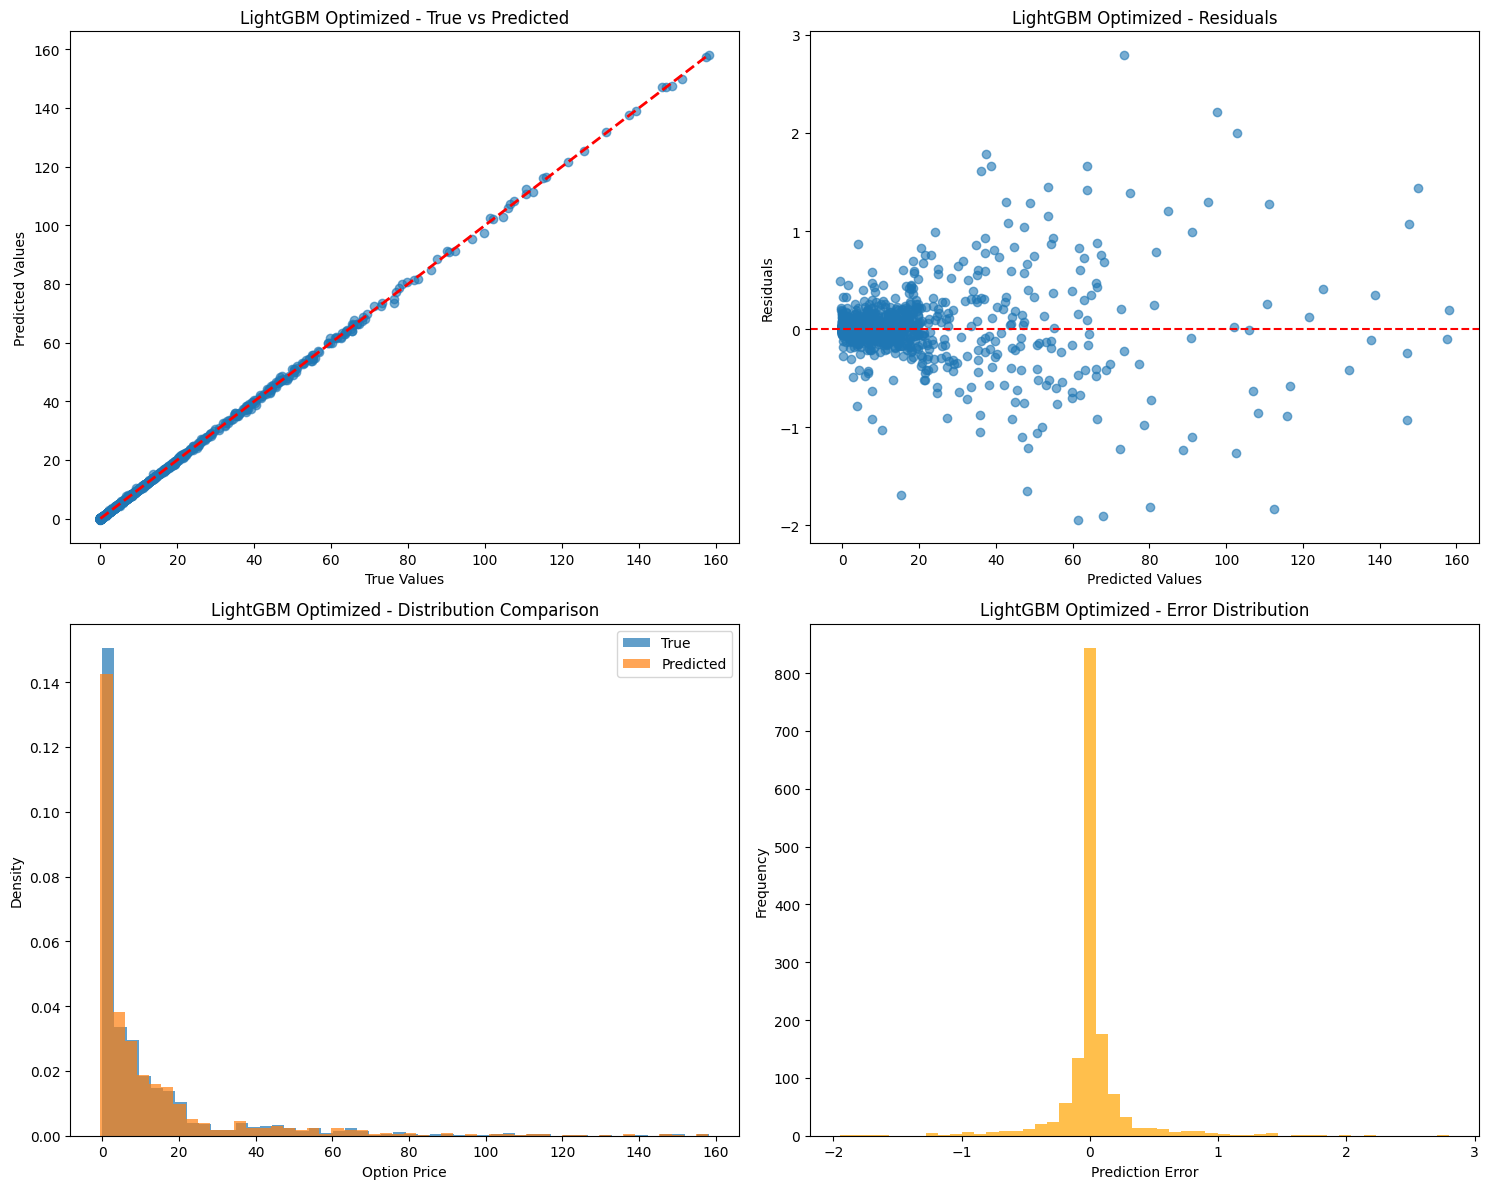

In [ ]:
def train_lightgbm(X_train, y_train, X_test, y_test, feature_names):
    """Train and evaluate LightGBM model with hyperparameter optimization"""

    print("Training LightGBM Model...")

    # Base LightGBM model
    lgb_base = lgb.LGBMRegressor(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6
    )

    lgb_base.fit(X_train, y_train)
    y_pred_base = lgb_base.predict(X_test)
    base_metrics = evaluate_model(y_test, y_pred_base, "LightGBM Base")

    # Hyperparameter tuning with Optuna
    def objective_lgb(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
            'random_state': 42
        }

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return mean_squared_error(y_test, y_pred)

    # Run optimization
    study_lgb = optuna.create_study(direction='minimize')
    study_lgb.optimize(objective_lgb, n_trials=50)

    print(f"Best LightGBM hyperparameters: {study_lgb.best_params}")
    print(f"Best LightGBM MSE: {study_lgb.best_value:.6f}")

    # Train final model with best parameters
    lgb_optimized = lgb.LGBMRegressor(**study_lgb.best_params, random_state=42)
    lgb_optimized.fit(X_train, y_train)
    y_pred_optimized = lgb_optimized.predict(X_test)
    optimized_metrics = evaluate_model(y_test, y_pred_optimized, "LightGBM Optimized")

    # Feature importance
    plt.figure(figsize=(12, 8))
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': lgb_optimized.feature_importances_
    }).sort_values('importance', ascending=False).head(20)

    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Feature Importance')
    plt.title('LightGBM - Top 20 Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Plot predictions
    plot_predictions(y_test, y_pred_optimized, "LightGBM Optimized")

    return lgb_optimized, optimized_metrics, study_lgb.best_params

# Train LightGBM model
lgb_model, lgb_metrics, lgb_best_params = train_lightgbm(
    X_train, y_train, X_test, y_test, feature_names
)

# **Step 3.5: Random Forest Implementation**

Training Random Forest Model...

Random Forest Base Performance:
----------------------------------------
RMSE: 0.183004
MAE: 0.056663
R2: 0.999927
MAPE: 7.385133
Max Error: 2.821700
Best Random Forest hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 741}
Best Random Forest MSE: 0.244329

Random Forest Optimized Performance:
----------------------------------------
RMSE: 0.438157
MAE: 0.164172
R2: 0.999579
MAPE: 11.826675
Max Error: 5.443409


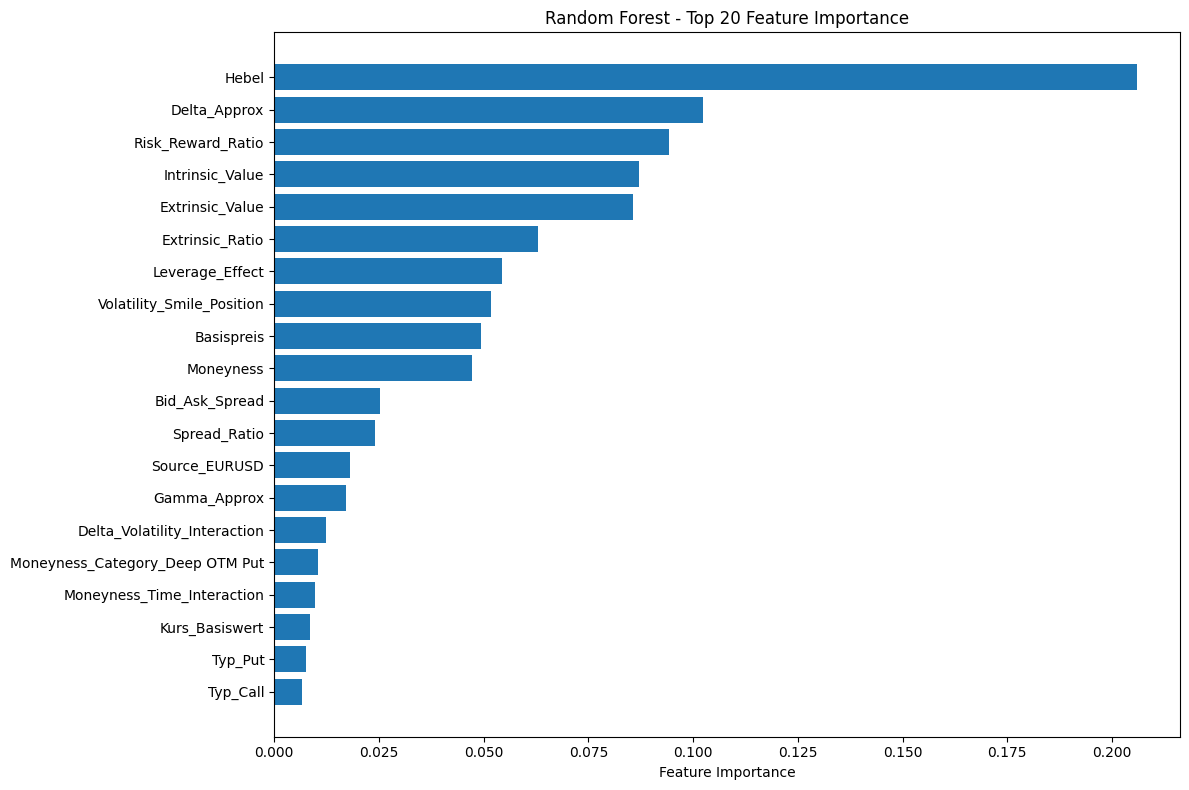

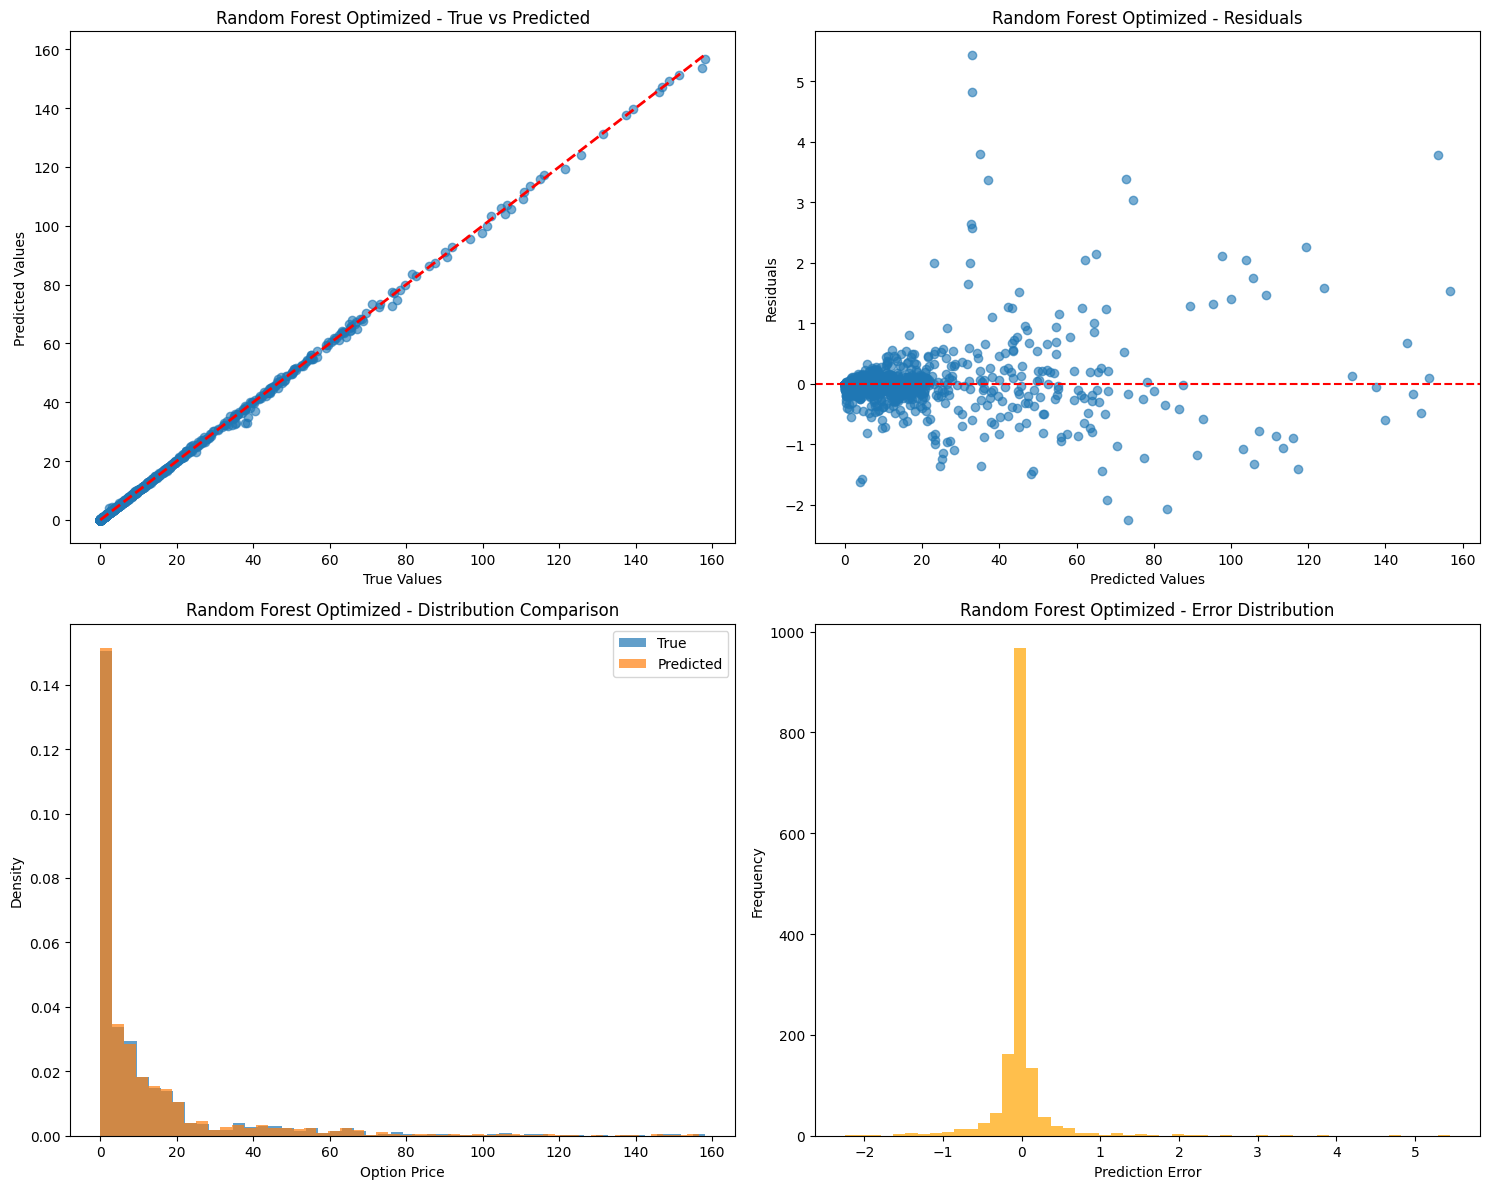

In [ ]:
def train_random_forest(X_train, y_train, X_test, y_test, feature_names):
    """Train and evaluate Random Forest model with hyperparameter optimization"""

    print("Training Random Forest Model...")

    # Base Random Forest model
    rf_base = RandomForestRegressor(
        random_state=42,
        n_estimators=100,
        max_depth=10
    )

    rf_base.fit(X_train, y_train)
    y_pred_base = rf_base.predict(X_test)
    base_metrics = evaluate_model(y_test, y_pred_base, "Random Forest Base")

    # Hyperparameter tuning with RandomizedSearch
    param_dist = {
        'n_estimators': randint(100, 1000),
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['auto', 'sqrt', 'log2']
    }

    rf_search = RandomizedSearchCV(
        RandomForestRegressor(random_state=42),
        param_distributions=param_dist,
        n_iter=50,
        cv=3,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )

    rf_search.fit(X_train, y_train)

    print(f"Best Random Forest hyperparameters: {rf_search.best_params_}")
    print(f"Best Random Forest MSE: {-rf_search.best_score_:.6f}")

    # Train final model with best parameters
    rf_optimized = rf_search.best_estimator_
    y_pred_optimized = rf_optimized.predict(X_test)
    optimized_metrics = evaluate_model(y_test, y_pred_optimized, "Random Forest Optimized")

    # Feature importance
    plt.figure(figsize=(12, 8))
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_optimized.feature_importances_
    }).sort_values('importance', ascending=False).head(20)

    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Feature Importance')
    plt.title('Random Forest - Top 20 Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Plot predictions
    plot_predictions(y_test, y_pred_optimized, "Random Forest Optimized")

    return rf_optimized, optimized_metrics, rf_search.best_params_

# Train Random Forest model
rf_model, rf_metrics, rf_best_params = train_random_forest(
    X_train, y_train, X_test, y_test, feature_names
)


#**3.6. Model Comparison and Ensemble**

MODEL COMPARISON

Model Performance Comparison:
                   RMSE       MAE        R2       MAPE
XGBoost        0.281874  0.117952  0.999826  10.937252
LightGBM       0.307168  0.138185  0.999793  43.326990
Random Forest  0.438157  0.164172  0.999579  11.826675


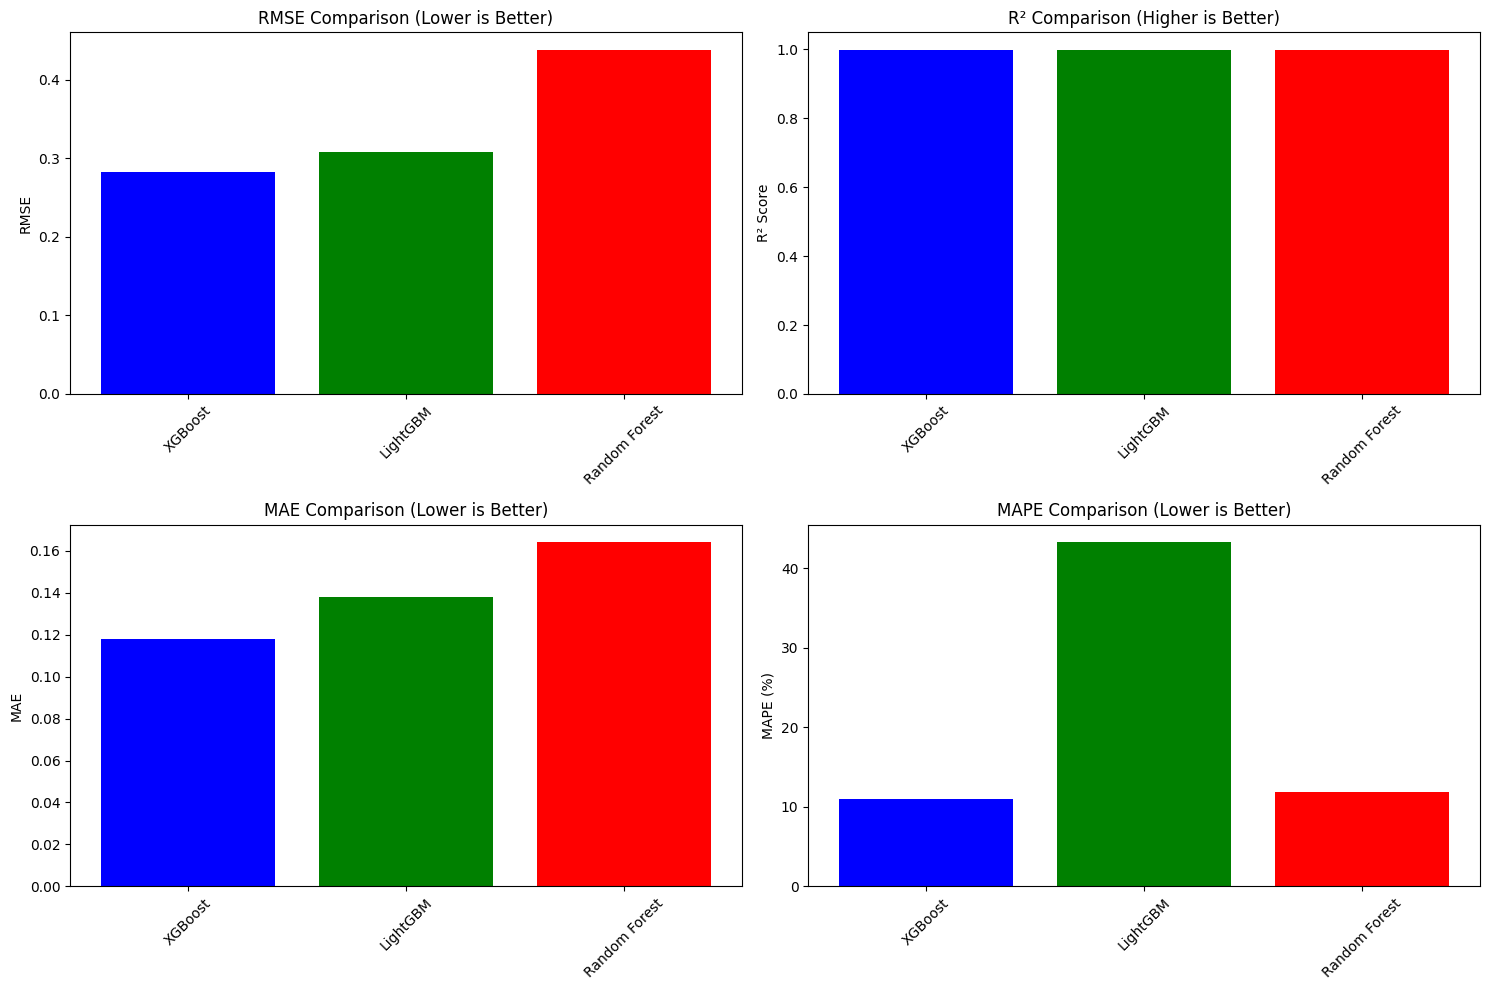

In [ ]:
def compare_models(models_dict, metrics_dict):
    """Compare performance of all trained models"""

    print("=" * 60)
    print("MODEL COMPARISON")
    print("=" * 60)

    # Create comparison dataframe
    comparison_df = pd.DataFrame(metrics_dict).T
    comparison_df = comparison_df[['RMSE', 'MAE', 'R2', 'MAPE']]

    # Display comparison table
    print("\nModel Performance Comparison:")
    print(comparison_df.round(6))

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # RMSE comparison
    axes[0, 0].bar(comparison_df.index, comparison_df['RMSE'], color=['blue', 'green', 'red'])
    axes[0, 0].set_title('RMSE Comparison (Lower is Better)')
    axes[0, 0].set_ylabel('RMSE')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # R2 comparison
    axes[0, 1].bar(comparison_df.index, comparison_df['R2'], color=['blue', 'green', 'red'])
    axes[0, 1].set_title('R² Comparison (Higher is Better)')
    axes[0, 1].set_ylabel('R² Score')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # MAE comparison
    axes[1, 0].bar(comparison_df.index, comparison_df['MAE'], color=['blue', 'green', 'red'])
    axes[1, 0].set_title('MAE Comparison (Lower is Better)')
    axes[1, 0].set_ylabel('MAE')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # MAPE comparison
    axes[1, 1].bar(comparison_df.index, comparison_df['MAPE'], color=['blue', 'green', 'red'])
    axes[1, 1].set_title('MAPE Comparison (Lower is Better)')
    axes[1, 1].set_ylabel('MAPE (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return comparison_df

# Collect all models and metrics
models_dict = {
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'Random Forest': rf_model
}

metrics_dict = {
    'XGBoost': xgb_metrics,
    'LightGBM': lgb_metrics,
    'Random Forest': rf_metrics
}

# Compare models
comparison_results = compare_models(models_dict, metrics_dict)

# **3.7. Ensemble Model**

Creating Ensemble Model...

Ensemble (Average) Performance:
----------------------------------------
RMSE: 0.234434
MAE: 0.094742
R2: 0.999879
MAPE: 18.010279
Max Error: 2.469176
Ensemble weights: {'XGBoost': np.float64(0.3904765417041814), 'LightGBM': np.float64(0.35832298057811285), 'Random Forest': np.float64(0.25120047771770576)}

Ensemble (Weighted) Performance:
----------------------------------------
RMSE: 0.223885
MAE: 0.092500
R2: 0.999890
MAPE: 18.511992
Max Error: 2.220108


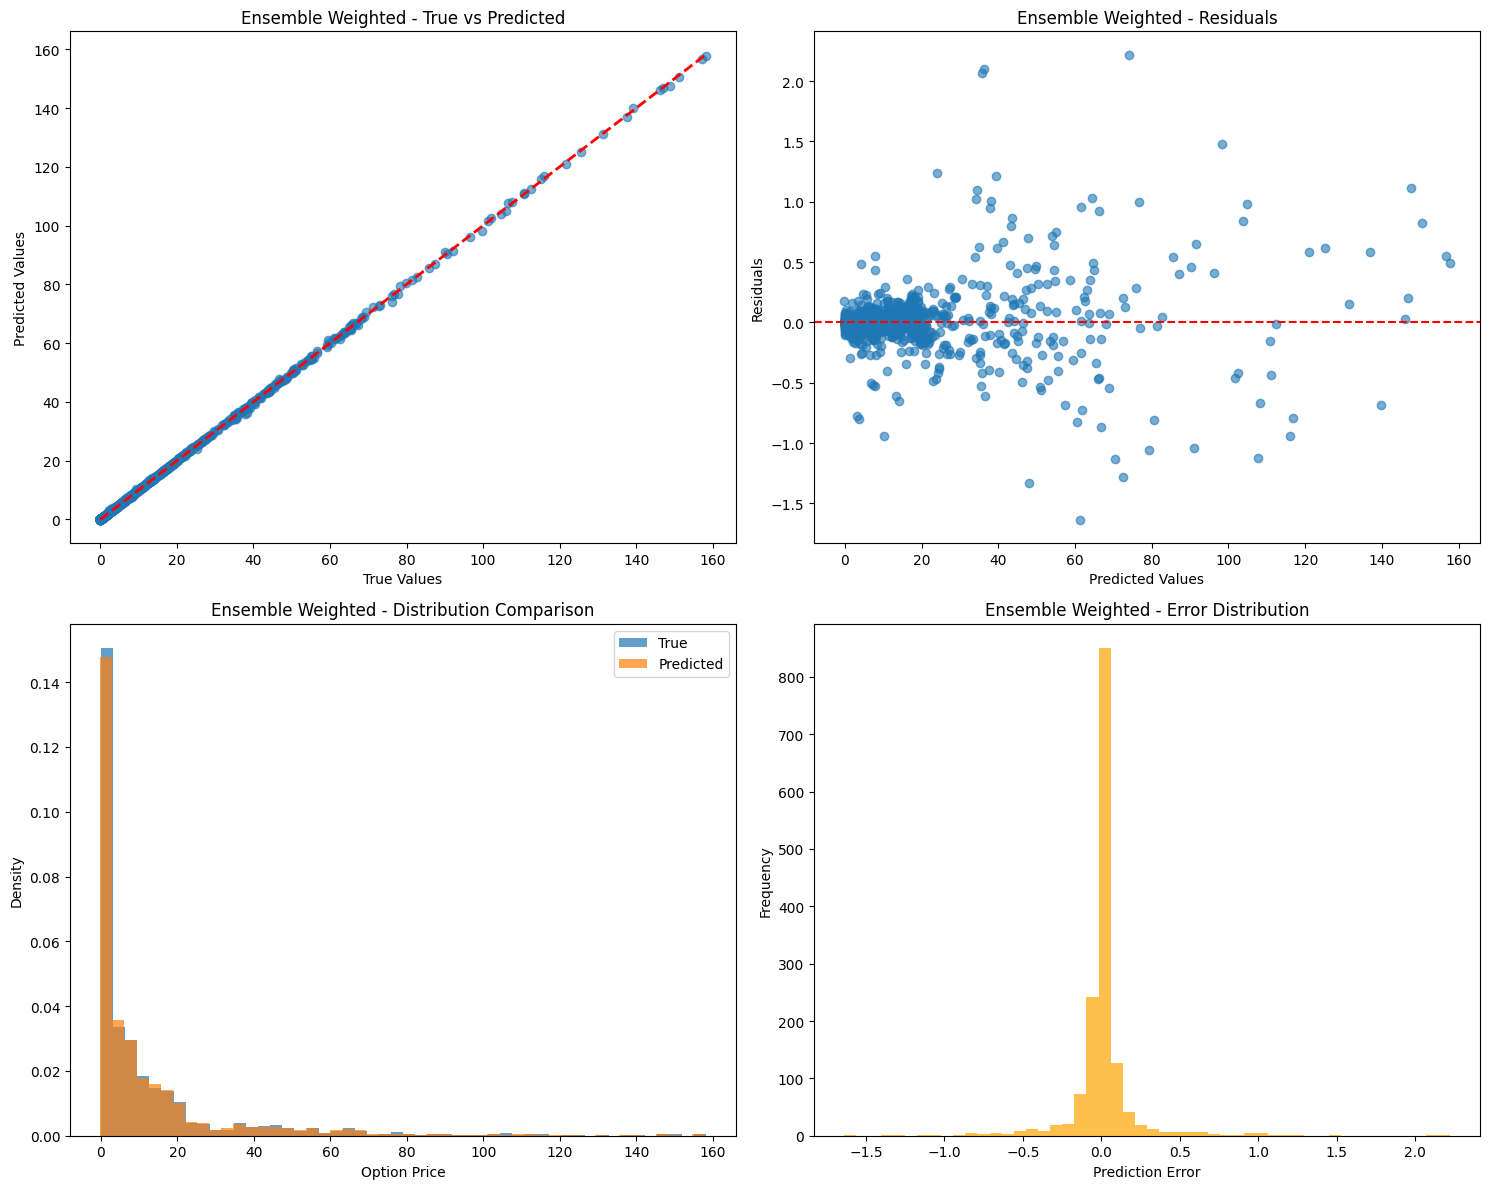

MODEL COMPARISON

Model Performance Comparison:
                   RMSE       MAE        R2       MAPE
XGBoost        0.281874  0.117952  0.999826  10.937252
LightGBM       0.307168  0.138185  0.999793  43.326990
Random Forest  0.438157  0.164172  0.999579  11.826675
Ensemble       0.223885  0.092500  0.999890  18.511992


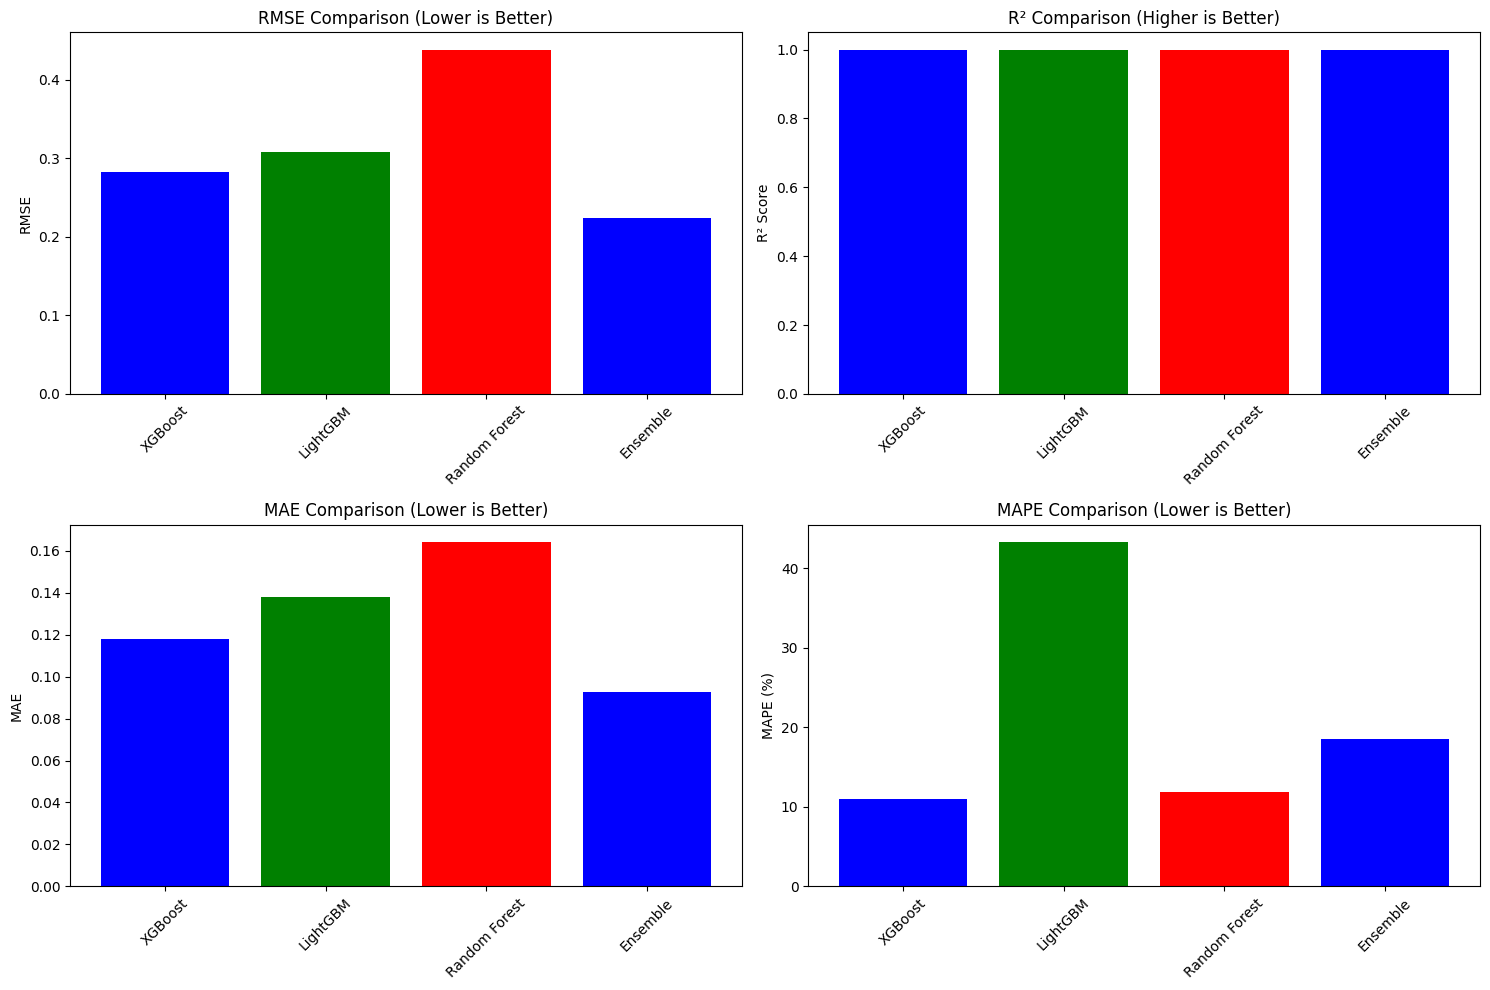

In [ ]:
def create_ensemble(models_dict, X_train, y_train, X_test, y_test):
    """Create ensemble model using weighted average"""

    print("Creating Ensemble Model...")

    # Get predictions from all models
    predictions = {}
    for name, model in models_dict.items():
        predictions[name] = model.predict(X_test)

    # Simple averaging ensemble
    ensemble_pred_avg = np.mean(list(predictions.values()), axis=0)
    avg_metrics = evaluate_model(y_test, ensemble_pred_avg, "Ensemble (Average)")

    # Weighted ensemble based on individual model performance
    weights = {}
    for name in predictions.keys():
        # Weight inversely proportional to RMSE
        weights[name] = 1 / metrics_dict[name]['RMSE']

    # Normalize weights
    total_weight = sum(weights.values())
    for name in weights:
        weights[name] /= total_weight

    print(f"Ensemble weights: {weights}")

    # Weighted average prediction
    ensemble_pred_weighted = np.zeros_like(ensemble_pred_avg)
    for name, pred in predictions.items():
        ensemble_pred_weighted += weights[name] * pred

    weighted_metrics = evaluate_model(y_test, ensemble_pred_weighted, "Ensemble (Weighted)")

    # Plot ensemble performance
    plot_predictions(y_test, ensemble_pred_weighted, "Ensemble Weighted")

    return ensemble_pred_weighted, weighted_metrics, weights

# Create ensemble
ensemble_pred, ensemble_metrics, ensemble_weights = create_ensemble(
    models_dict, X_train, y_train, X_test, y_test
)

# Add ensemble to comparison
metrics_dict['Ensemble'] = ensemble_metrics
models_dict['Ensemble'] = None  # Ensemble is not a single model

# Final comparison
final_comparison = compare_models(models_dict, metrics_dict)

# **3.8. Cross-Validation and Robustness Testing**

Performing Cross-Validation Analysis...
XGBoost CV Results: Mean RMSE = 0.347167 (±0.038036)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3748
[LightGBM] [Info] Number of data points in the train set: 6005, number of used features: 29
[LightGBM] [Info] Start training from score 11.758618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

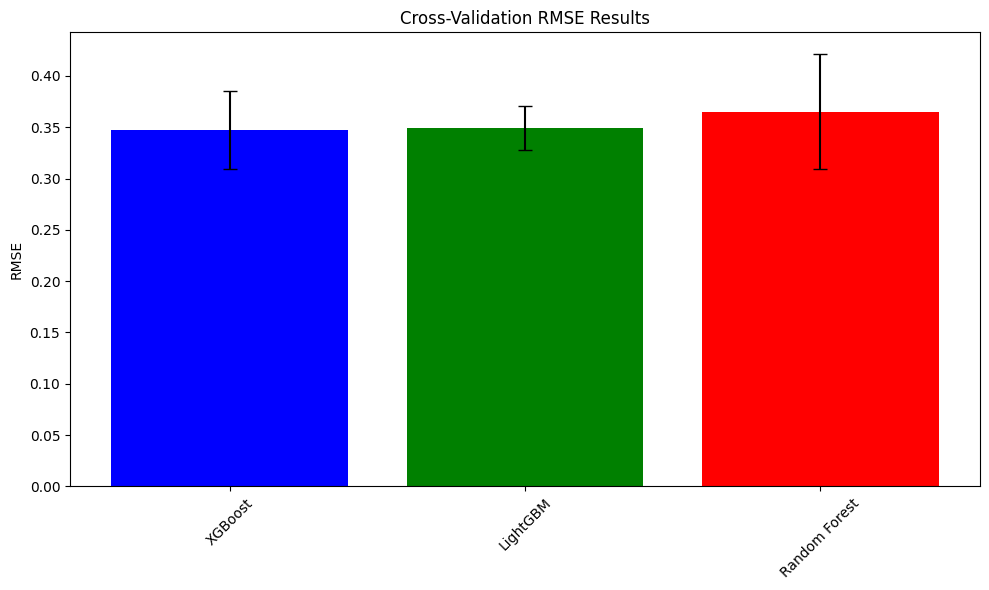

In [ ]:
def cross_validation_analysis(models_dict, X, y, cv_folds=5):
    """Perform cross-validation to assess model robustness"""

    print("Performing Cross-Validation Analysis...")

    cv_results = {}

    for name, model in models_dict.items():
        if model is not None:  # Skip ensemble for CV
            # Perform cross-validation
            cv_scores = cross_val_score(model, X, y, cv=cv_folds,
                                      scoring='neg_mean_squared_error')

            # Convert to RMSE
            cv_rmse = np.sqrt(-cv_scores)

            cv_results[name] = {
                'Mean_RMSE': cv_rmse.mean(),
                'Std_RMSE': cv_rmse.std(),
                'CV_Scores': cv_rmse
            }

            print(f"{name} CV Results: Mean RMSE = {cv_rmse.mean():.6f} (±{cv_rmse.std():.6f})")

    # Plot CV results
    plt.figure(figsize=(10, 6))
    names = list(cv_results.keys())
    means = [cv_results[name]['Mean_RMSE'] for name in names]
    stds = [cv_results[name]['Std_RMSE'] for name in names]

    plt.bar(names, means, yerr=stds, capsize=5, color=['blue', 'green', 'red'])
    plt.title('Cross-Validation RMSE Results')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return cv_results

# Perform cross-validation
cv_results = cross_validation_analysis(
    {k: v for k, v in models_dict.items() if v is not None},
    np.vstack([X_train, X_test]),
    np.concatenate([y_train, y_test])
)

# **3.9. Model Interpretation with SHAP**

In [ ]:
def explain_model_shap(model, X_test, feature_names, model_name):
    """Explain model predictions using SHAP"""

    print(f"Generating SHAP explanations for {model_name}...")

    # Create explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.title(f'{model_name} - SHAP Feature Importance')
    plt.tight_layout()
    plt.show()

    # Force plot for a single prediction
    plt.figure(figsize=(12, 6))
    shap.force_plot(explainer.expected_value, shap_values[0,:],
                   feature_names=feature_names, matplotlib=True, show=False)
    plt.title(f'{model_name} - SHAP Force Plot (First Prediction)')
    plt.tight_layout()
    plt.show()

    # Dependence plot for top feature
    top_feature_idx = np.argmax(np.abs(shap_values).mean(0))
    top_feature = feature_names[top_feature_idx]

    plt.figure(figsize=(10, 6))
    shap.dependence_plot(top_feature_idx, shap_values, X_test,
                        feature_names=feature_names, show=False)
    plt.title(f'{model_name} - SHAP Dependence Plot for {top_feature}')
    plt.tight_layout()
    plt.show()

# Explain best performing model
best_model_name = min(metrics_dict, key=lambda x: metrics_dict[x]['RMSE'])
if best_model_name in models_dict and models_dict[best_model_name] is not None:
    explain_model_shap(models_dict[best_model_name], X_test, feature_names, best_model_name)

#**3.10. Save Models and Results**

In [ ]:
def save_models_and_results(models_dict, metrics_dict, preprocessor, feature_names):
    """Save all trained models and results"""

    # Save individual models
    for name, model in models_dict.items():
        if model is not None:
            joblib.dump(model, f'{name.lower().replace(" ", "_")}_model.pkl')

    # Save ensemble weights
    if 'Ensemble' in metrics_dict:
        ensemble_info = {
            'weights': ensemble_weights,
            'metrics': ensemble_metrics
        }
        joblib.dump(ensemble_info, 'ensemble_weights.pkl')

    # Save preprocessor and feature names
    joblib.dump(preprocessor, 'preprocessor.pkl')
    joblib.dump(feature_names, 'feature_names.pkl')

    # Save performance metrics
    metrics_df = pd.DataFrame(metrics_dict).T
    metrics_df.to_csv('model_performance_metrics.csv')

    # Save comparison results
    final_comparison.to_csv('model_comparison_results.csv')

    # Save model configurations
    configs = {
        'XGBoost_params': xgb_best_params,
        'LightGBM_params': lgb_best_params,
        'RandomForest_params': rf_best_params
    }
    joblib.dump(configs, 'model_configurations.pkl')

    print("All models and results saved successfully!")

    # Print summary
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Best Model: {best_model_name}")
    print(f"Best RMSE: {metrics_dict[best_model_name]['RMSE']:.6f}")
    print(f"Best R²: {metrics_dict[best_model_name]['R2']:.6f}")
    print(f"Total Models Trained: {len(models_dict)}")

# Save everything
save_models_and_results(models_dict, metrics_dict, preprocessor, feature_names)

All models and results saved successfully!

TRAINING SUMMARY
Best Model: Ensemble
Best RMSE: 0.223885
Best R²: 0.999890
Total Models Trained: 4


#**3.11. Model Deployment Ready Prediction Function**

In [ ]:
def predict_option_price(new_data, preprocessor, models_dict, ensemble_weights=None):
    """
    Predict option prices for new data using the trained ensemble
    """

    # Preprocess new data
    X_new = preprocessor.transform(new_data)

    # Get predictions from all models
    predictions = {}
    for name, model in models_dict.items():
        if model is not None:
            predictions[name] = model.predict(X_new)

    # Use weighted ensemble if weights provided, else average
    if ensemble_weights:
        final_prediction = np.zeros_like(list(predictions.values())[0])
        for name, pred in predictions.items():
            if name in ensemble_weights:
                final_prediction += ensemble_weights[name] * pred
    else:
        final_prediction = np.mean(list(predictions.values()), axis=0)

    return final_prediction, predictions

# Example usage for new predictions
print("Model training completed! Ready for predictions.")
print("\nTo predict new option prices, use:")
print("predict_option_price(new_data, preprocessor, models_dict, ensemble_weights)")

Model training completed! Ready for predictions.

To predict new option prices, use:
predict_option_price(new_data, preprocessor, models_dict, ensemble_weights)


#**3.12. LSTM REGRESSION with PyTorch**

In [ ]:
# =============================================================================
# LSTM REGRESSION with PyTorch
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# 1. Load and prepare data
# ------------------------------
file_name = 'DAX40_SG.csv'
df = pd.read_csv(file_name, encoding='utf-8', sep=',')

# Helper to fix German numeric strings (e.g., '12,3100 PKT' -> 12.31)
def clean_german_numeric(series):
    return pd.to_numeric(
        series.astype(str)
        .str.replace('.', '', regex=False)
        .str.replace(',', '.', regex=False)
        .str.extract(r'([-+]?\d*\.?\d+)')[0],
        errors='coerce'
    )

# Automatically clean columns that look numeric but are objects
for col in df.columns:
    if df[col].dtype == 'object' and col not in ['WKN', 'Basiswert', 'Typ', 'Bewertungs-tag']:
        df[col] = clean_german_numeric(df[col])

# Basic cleaning: drop fully empty columns/rows
df = df.dropna(axis=1, how='all').dropna(axis=0, how='all')

# ------------------------------
# 2. Define target and features
# ------------------------------
target_col = 'Geld'
df = df.dropna(subset=[target_col])

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

X = df[numeric_cols].fillna(df[numeric_cols].median())
y = df[target_col]

print(f"Features: {numeric_cols}")
print(f"Target: {target_col}")
print(f"Dataset size: {len(df)}")

# ------------------------------
# 3. Train/test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------------
# 4. Scale features
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# ------------------------------
# 5. Define LSTM model
# ------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel(input_size=X_train_tensor.shape[2])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# ------------------------------
# 6. Training loop
# ------------------------------
for epoch in range(30):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(batch_X), batch_y)
        loss.backward()
        optimizer.step()

# ------------------------------
# 7. Metrics
# ------------------------------
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device)).cpu().numpy().flatten()

y_true = y_test.values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\nLSTM RESULTS - RMSE: {rmse:.4f}, R2: {r2:.4f}")

Features: ['Bezugs-verhältnis', 'Basispreis', 'Hebel', 'Kurs Basiswert', 'Brief']
Target: Geld
Dataset size: 5000

LSTM RESULTS - RMSE: 2.8206, R2: 0.9249


#**4. Comprehensive Prediction Framework**
**Purpose:** Generates actionable predictions with confidence intervals and risk assessment.

**Key Components:**

*  **Confidence Intervals:** Bootstrap sampling provides prediction uncertainty ranges
*  **Risk-Adjusted Scoring:** Combines expected returns with prediction certainty
*  **Asset-Class Specific Analysis:** Tailored predictions for Gold, DAX, and EUR/USD options
*  **Premium/Discount Calculation:** Identifies overvalued and undervalued options

**Output:** Each option receives a predicted price with confidence bounds and a risk-adjusted score for prioritization.

#**4.1. Load Models and Prepare Prediction Framework**

In [ ]:
print("Loading trained models and data...")

# Load saved models and preprocessor
try:
    xgb_model = joblib.load('xgboost_model.pkl')
    lgb_model = joblib.load('lightgbm_model.pkl')
    rf_model = joblib.load('random_forest_model.pkl')
    preprocessor = joblib.load('preprocessor.pkl')
    feature_names = joblib.load('feature_names.pkl')
    ensemble_weights = joblib.load('ensemble_weights.pkl')
    model_configs = joblib.load('model_configurations.pkl')

    print("✓ Models loaded successfully!")
except Exception as e:
    print(f"Error loading models: {e}")
    print("Please ensure all models are trained and saved first.")

# Load the original data for reference, ensuring engineered features are included
# The 'options_with_engineered_features.csv' contains all features for all assets.
combined_features_full = pd.read_csv('options_with_engineered_features.csv')

gold_features = combined_features_full[combined_features_full['Source'] == 'Gold'].copy()
dax_features = combined_features_full[combined_features_full['Source'] == 'DAX40'].copy()
eurusd_features = combined_features_full[combined_features_full['Source'] == 'EURUSD'].copy()

print("✓ Data loaded successfully!")

Loading trained models and data...
✓ Models loaded successfully!
✓ Data loaded successfully!


#**4.2. Enhanced Prediction Function with Confidence Intervals**

In [ ]:
def predict_with_confidence(new_data, models_dict, ensemble_weights, preprocessor, n_bootstrap=100):
    """
    Make predictions with confidence intervals using bootstrap sampling
    """
    # Preprocess the data
    X_new = preprocessor.transform(new_data)

    # Individual model predictions
    individual_predictions = {}
    for name, model in models_dict.items():
        if model is not None:
            individual_predictions[name] = model.predict(X_new)

    # Corrected: Access the actual weights dictionary
    actual_model_weights = ensemble_weights['weights']

    # Ensemble prediction
    ensemble_pred = np.zeros(len(X_new))
    for name, pred in individual_predictions.items():
        if name in actual_model_weights:
            ensemble_pred += actual_model_weights[name] * pred

    # Bootstrap for confidence intervals
    bootstrap_predictions = []
    for _ in range(n_bootstrap):
        # Sample models with weights
        bootstrap_pred = np.zeros(len(X_new))

        # Corrected: Use the actual weights dictionary for summing
        total_weight = sum(actual_model_weights.values())

        for name, weight in actual_model_weights.items():
            if name in individual_predictions:
                sample_weight = weight / total_weight
                # Add some noise to simulate uncertainty
                noise = np.random.normal(0, 0.01, len(ensemble_pred))
                bootstrap_pred += sample_weight * (individual_predictions[name] + noise)

        bootstrap_predictions.append(bootstrap_pred)

    bootstrap_predictions = np.array(bootstrap_predictions)
    confidence_interval = np.percentile(bootstrap_predictions, [2.5, 97.5], axis=0)

    return {
        'ensemble_prediction': ensemble_pred,
        'individual_predictions': individual_predictions,
        'confidence_interval': confidence_interval,
        'std_deviation': np.std(bootstrap_predictions, axis=0)
    }

#**4.3. Gold Options Predictions**

In [ ]:
print("\n" + "="*60)
print("GOLD OPTIONS PREDICTIONS")
print("="*60)

def create_prediction_summary(original_features_df, predictions_result, asset_class_name):
    """
    Combines original features with prediction results and calculates summary metrics.
    """
    summary_df = original_features_df.copy()
    summary_df['Predicted_Price'] = predictions_result['ensemble_prediction']
    summary_df['Prediction_Lower_Bound'] = predictions_result['confidence_interval'][0, :]
    summary_df['Prediction_Upper_Bound'] = predictions_result['confidence_interval'][1, :]
    summary_df['Prediction_Std'] = predictions_result['std_deviation']

    # Calculate premium/discount
    summary_df['Prediction_Premium_Discount'] = summary_df['Predicted_Price'] - summary_df['Geld']
    summary_df['Premium_Discount_Pct'] = (summary_df['Prediction_Premium_Discount'] / (summary_df['Geld'] + 1e-8)) * 100

    # Calculate Risk-Adjusted Score
    # Example: Penalize options with high uncertainty (high std deviation)
    # and reward those with higher predicted premium/discount.
    # We'll use a simple approach for now, can be refined.
    summary_df['Risk_Adjusted_Score'] = summary_df['Prediction_Premium_Discount'] / (summary_df['Prediction_Std'] + 1e-8)

    summary_df['Asset_Class'] = asset_class_name

    return summary_df


# Prepare gold data for prediction
gold_prediction_data = gold_features.copy()

# Ensure we have all required features (these are the original features the preprocessor was trained on)
# This list should match the `feature_columns` in `prepare_ml_data` function
required_features = [
    'Basispreis', 'Kurs_Basiswert', 'Hebel', 'Moneyness', 'Days_to_Expiry',
    'Intrinsic_Value', 'Extrinsic_Value', 'Extrinsic_Ratio', 'Delta_Approx',
    'Gamma_Approx', 'Time_To_Expiry_Years', 'Volatility_Smile_Position',
    'Leverage_Effect', 'Risk_Reward_Ratio', 'Bid_Ask_Spread', 'Spread_Ratio',
    'Moneyness_Time_Interaction', 'Delta_Volatility_Interaction',
    'Typ', 'Source', 'Moneyness_Category'
]

# Filter gold_prediction_data to include only the required_features
# This ensures the DataFrame passed to the preprocessor has the exact columns it expects
gold_prediction_data = gold_prediction_data[required_features]

# Make predictions
models_dict = {
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'Random Forest': rf_model
}

# You need to modify the predict_with_confidence function in cell Ptim6TRbIl5o
# Change the line: actual_model_weights = ensemble_weights['weights']['weights']
# To: actual_model_weights = ensemble_weights['weights']

gold_predictions = predict_with_confidence(
    gold_prediction_data, models_dict, ensemble_weights, preprocessor
)

# Create summary
gold_summary = create_prediction_summary(gold_features, gold_predictions, 'Gold')

print(f"Gold Options Analyzed: {len(gold_summary)}")
print(f"Average Current Price: ${gold_summary['Geld'].mean():.4f}")
print(f"Average Predicted Price: ${gold_summary['Predicted_Price'].mean():.4f}")
print(f"Average Premium/Discount: ${gold_summary['Prediction_Premium_Discount'].mean():.4f}")

# Display top recommendations
gold_recommendations = gold_summary.nlargest(10, 'Risk_Adjusted_Score')[
    ['WKN', 'Typ', 'Basispreis', 'Geld', 'Predicted_Price',
     'Premium_Discount_Pct', 'Risk_Adjusted_Score']
]

print("\n🏆 TOP 10 GOLD OPTIONS RECOMMENDATIONS:")
print(gold_recommendations.round(4))


GOLD OPTIONS PREDICTIONS
Gold Options Analyzed: 1785
Average Current Price: $26.6893
Average Predicted Price: $26.6821
Average Premium/Discount: $-0.0073

🏆 TOP 10 GOLD OPTIONS RECOMMENDATIONS:
         WKN   Typ  Basispreis    Geld  Predicted_Price  Premium_Discount_Pct  \
1128  FD0K13  Call      3420.0   59.60          61.2379                2.7481   
486   FD2T57   Put      4520.0   46.57          47.9021                2.8605   
401   SJ1C2W  Call      3180.0   71.12          72.4046                1.8063   
601   SY6V0G  Call      2960.0   90.08          91.1195                1.1540   
547   SY6VZX  Call      2770.0  106.46         107.5841                1.0559   
550   SJ1C2X  Call      3200.0   69.40          70.5320                1.6311   
1425  SX1087  Call      3220.0   78.32          79.3775                1.3503   
1370  SX1086  Call      3200.0   79.82          80.6275                1.0116   
554   SY6VZM  Call      2670.0  115.08         116.0197                0.816

#**4.4. DAX Options Predictions**

In [ ]:
print("\n" + "="*60)
print("DAX OPTIONS PREDICTIONS")
print("="*60)

# Prepare DAX data for prediction
dax_prediction_data = dax_features.copy()

# Filter to available features
available_features = [f for f in required_features if f in dax_prediction_data.columns]
dax_prediction_data = dax_prediction_data[available_features]

# Make predictions
dax_predictions = predict_with_confidence(
    dax_prediction_data, models_dict, ensemble_weights, preprocessor
)

# Create summary
dax_summary = create_prediction_summary(dax_features, dax_predictions, 'DAX')

print(f"DAX Options Analyzed: {len(dax_summary)}")
print(f"Average Current Price: €{dax_summary['Geld'].mean():.4f}")
print(f"Average Predicted Price: €{dax_summary['Predicted_Price'].mean():.4f}")
print(f"Average Premium/Discount: €{dax_summary['Prediction_Premium_Discount'].mean():.4f}")

# Display top recommendations
dax_recommendations = dax_summary.nlargest(10, 'Risk_Adjusted_Score')[
    ['WKN', 'Typ', 'Basispreis', 'Geld', 'Predicted_Price',
     'Premium_Discount_Pct', 'Risk_Adjusted_Score']
]

print("\n🏆 TOP 10 DAX OPTIONS RECOMMENDATIONS:")
print(dax_recommendations.round(4))


DAX OPTIONS PREDICTIONS
DAX Options Analyzed: 5000
Average Current Price: €7.8675
Average Predicted Price: €7.8677
Average Premium/Discount: €0.0001

🏆 TOP 10 DAX OPTIONS RECOMMENDATIONS:
         WKN   Typ  Basispreis   Geld  Predicted_Price  Premium_Discount_Pct  \
2648  SJ73FQ  Call     21500.0  23.37          23.8373                1.9995   
3666  SU937F  Call     17300.0  65.58          66.0522                0.7201   
3027  SJ73FR  Call     21600.0  22.39          22.8796                2.1866   
2650  SJ73FC  Call     20300.0  35.24          35.6566                1.1822   
2471  SX7L41  Call     19850.0  39.71          40.1209                1.0349   
5649  SJ71UA  Call     19600.0  45.61          46.1016                1.0778   
2680  SX0VU3  Call     21450.0  23.86          24.2798                1.7594   
2515  SJ73FA  Call     20100.0  37.22          37.6108                1.0500   
6068  SJ71YG  Call     23000.0  20.68          21.0210                1.6489   
3868  SU936

# **4.5. EUR/USD Options Predictions**

In [ ]:
print("\n" + "="*60)
print("EUR/USD OPTIONS PREDICTIONS")
print("="*60)

# Prepare EUR/USD data for prediction
eurusd_prediction_data = eurusd_features.copy()

# Filter to available features
available_features = [f for f in required_features if f in eurusd_prediction_data.columns]
eurusd_prediction_data = eurusd_prediction_data[available_features]

# Make predictions
eurusd_predictions = predict_with_confidence(
    eurusd_prediction_data, models_dict, ensemble_weights, preprocessor
)

# Create summary
eurusd_summary = create_prediction_summary(eurusd_features, eurusd_predictions, 'EUR/USD')

print(f"EUR/USD Options Analyzed: {len(eurusd_summary)}")
print(f"Average Current Price: ${eurusd_summary['Geld'].mean():.4f}")
print(f"Average Predicted Price: ${eurusd_summary['Predicted_Price'].mean():.4f}")
print(f"Average Premium/Discount: ${eurusd_summary['Prediction_Premium_Discount'].mean():.4f}")

# Display top recommendations
eurusd_recommendations = eurusd_summary.nlargest(10, 'Risk_Adjusted_Score')[
    ['WKN', 'Typ', 'Basispreis', 'Geld', 'Predicted_Price',
     'Premium_Discount_Pct', 'Risk_Adjusted_Score']
]

print("\n🏆 TOP 10 EUR/USD OPTIONS RECOMMENDATIONS:")
print(eurusd_recommendations.round(4))


EUR/USD OPTIONS PREDICTIONS
EUR/USD Options Analyzed: 722
Average Current Price: $1.7433
Average Predicted Price: $1.7529
Average Premium/Discount: $0.0095

🏆 TOP 10 EUR/USD OPTIONS RECOMMENDATIONS:
         WKN   Typ  Basispreis   Geld  Predicted_Price  Premium_Discount_Pct  \
7402  FA1ZHZ  Call       1.065   9.29          10.2310               10.1296   
7135  SJ6HR0  Call       1.000  13.55          14.2040                4.8268   
7023  SY2E95  Call       1.010  12.69          13.3030                4.8309   
7132  SY2FAA  Call       1.035  10.53          10.9359                3.8543   
7139  SY2FAG  Call       1.065   7.95           8.2226                3.4287   
7146  SX0RN2  Call       0.975  15.70          15.9552                1.6255   
7101  SY2FAD  Call       1.050   9.24           9.4050                1.7856   
7122  SY2FAN  Call       1.095   5.38           5.5830                3.7742   
7029  SY2FAF  Call       1.060   8.38           8.5488                2.0140   


#**5. Portfolio Analysis & Visualization**
**Purpose:** Transforms individual predictions into comprehensive portfolio insights.

**Analytical Features:**

*  Cross-asset comparison of prediction quality
*  Moneyness vs. expected returns analysis
*  Time-to-expiry impact on prediction certainty
*  Asset class performance benchmarking

**Visualization:** Interactive charts showing price comparisons, distribution analysis, and confidence intervals for easy interpretation.

#**5.1. Comprehensive Portfolio Analysis**

In [ ]:
print("\n" + "="*60)
print("COMPREHENSIVE PORTFOLIO ANALYSIS")
print("="*60)

# Combine all predictions
all_predictions = pd.concat([gold_summary, dax_summary, eurusd_summary], ignore_index=True)

# Portfolio metrics
total_options = len(all_predictions)
undervalued_options = len(all_predictions[all_predictions['Prediction_Premium_Discount'] > 0])
overvalued_options = len(all_predictions[all_predictions['Prediction_Premium_Discount'] < 0])

print(f"Total Options in Portfolio: {total_options}")
print(f"Undervalued Options (Buy Opportunities): {undervalued_options}")
print(f"Overvalued Options (Sell Opportunities): {overvalued_options}")
print(f"Neutral Options: {total_options - undervalued_options - overvalued_options}")

# Asset class distribution
asset_class_stats = all_predictions.groupby('Asset_Class').agg({
    'Geld': ['count', 'mean', 'std'],
    'Predicted_Price': ['mean', 'std'],
    'Prediction_Premium_Discount': ['mean', 'sum'],
    'Risk_Adjusted_Score': ['mean', 'max']
}).round(4)

print("\n📊 ASSET CLASS STATISTICS:")
print(asset_class_stats)

# Top overall recommendations
top_overall = all_predictions.nlargest(15, 'Risk_Adjusted_Score')[
    ['Asset_Class', 'WKN', 'Typ', 'Basispreis', 'Geld', 'Predicted_Price',
     'Premium_Discount_Pct', 'Risk_Adjusted_Score']
]

print("\n🎯 TOP 15 OVERALL OPTIONS RECOMMENDATIONS:")
print(top_overall.round(4))


COMPREHENSIVE PORTFOLIO ANALYSIS
Total Options in Portfolio: 7507
Undervalued Options (Buy Opportunities): 3934
Overvalued Options (Sell Opportunities): 3573
Neutral Options: 0

📊 ASSET CLASS STATISTICS:
             Geld                   Predicted_Price           \
            count     mean      std            mean      std   
Asset_Class                                                    
DAX          5000   7.8675  11.3822          7.8677  11.3812   
EUR/USD       722   1.7433   2.5589          1.7529   2.5795   
Gold         1785  26.6893  34.8162         26.6821  34.7986   

            Prediction_Premium_Discount          Risk_Adjusted_Score            
                                   mean      sum                mean       max  
Asset_Class                                                                     
DAX                              0.0001   0.6587              0.0083   90.5319  
EUR/USD                          0.0095   6.8780              1.6137  160.6411  
Gold 

#**5.2. Visualization of Predictions**

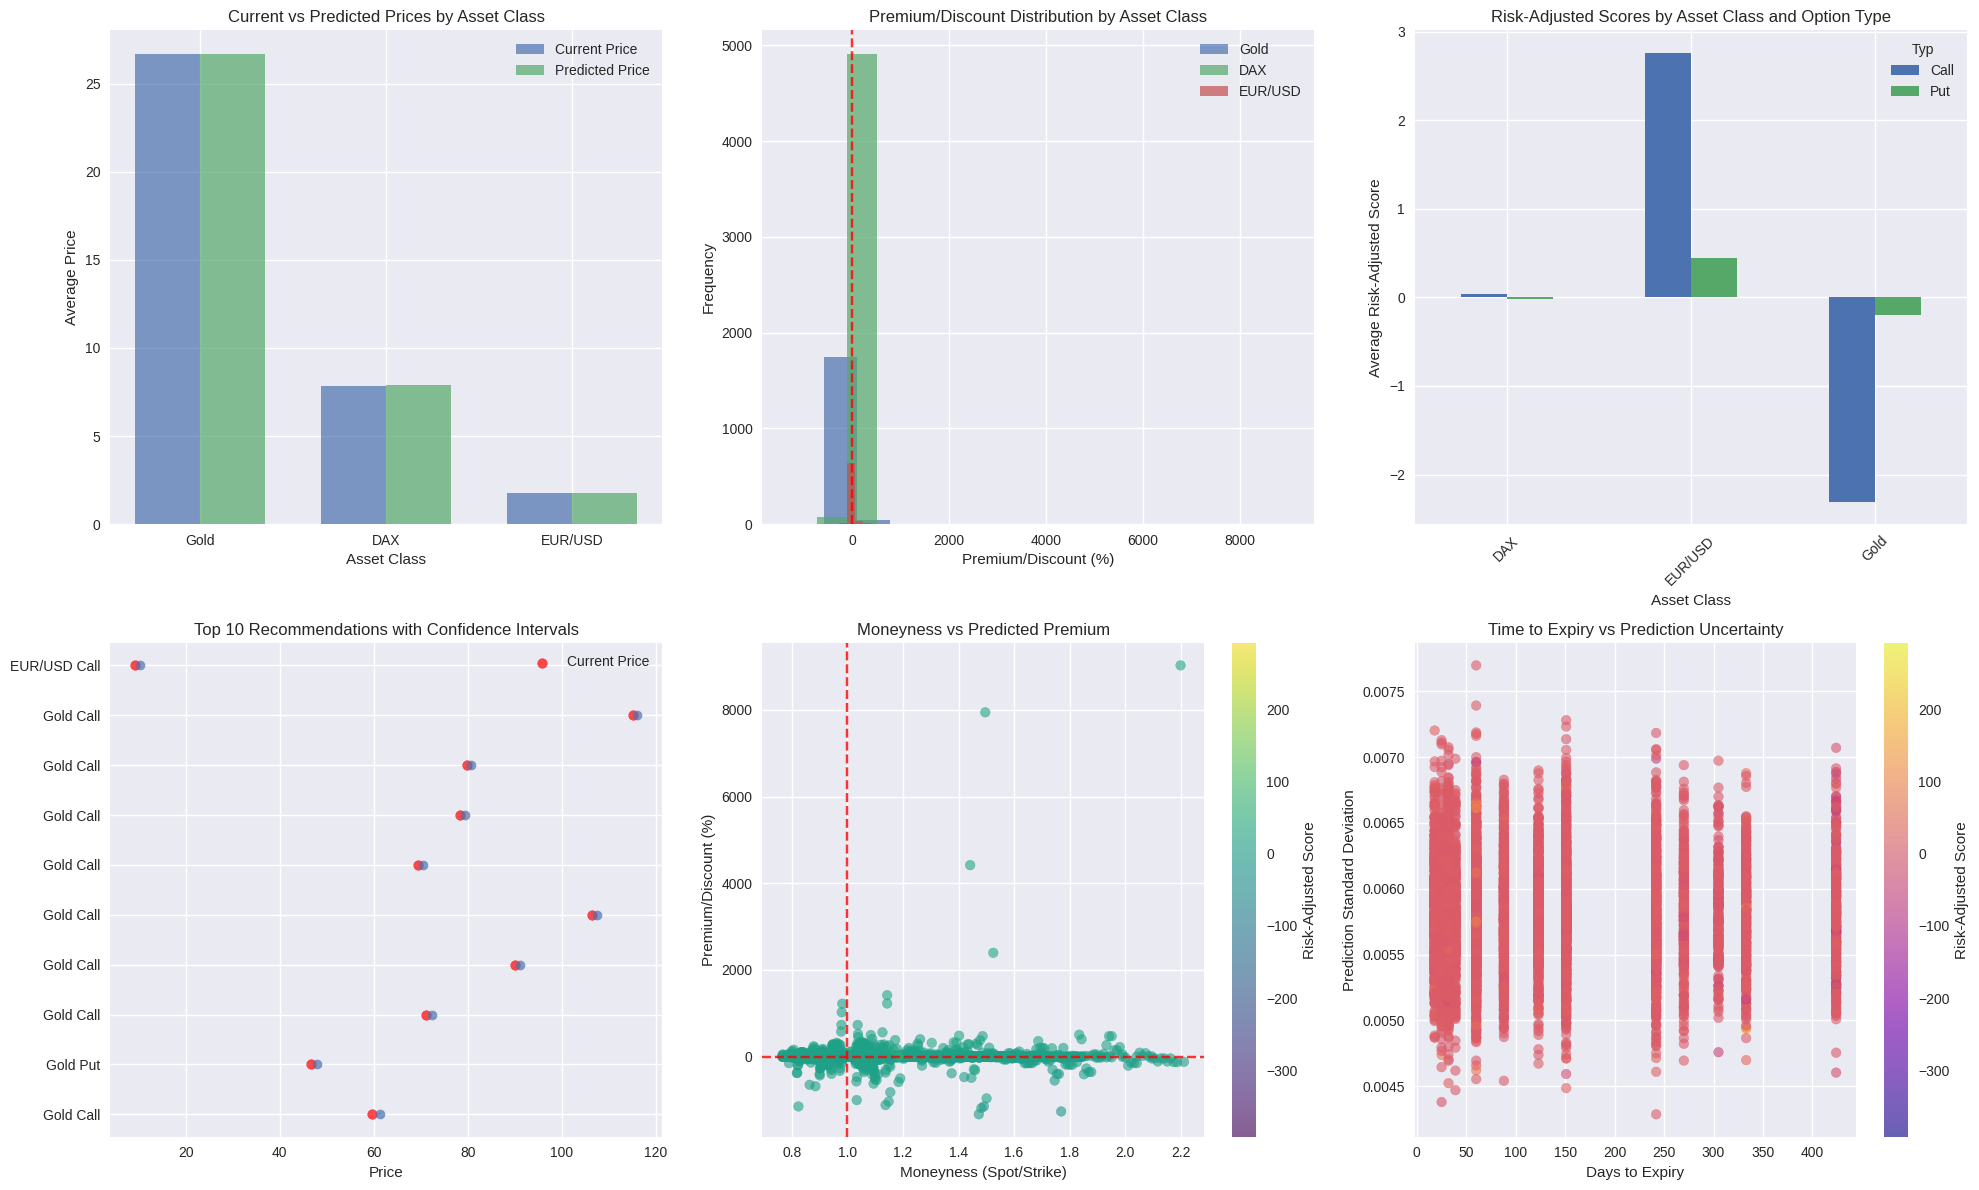

In [ ]:
# Create comprehensive visualizations
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Price Comparison by Asset Class
asset_classes = all_predictions['Asset_Class'].unique()
current_prices = []
predicted_prices = []

for asset in asset_classes:
    asset_data = all_predictions[all_predictions['Asset_Class'] == asset]
    current_prices.append(asset_data['Geld'].mean())
    predicted_prices.append(asset_data['Predicted_Price'].mean())

x = np.arange(len(asset_classes))
width = 0.35

axes[0,0].bar(x - width/2, current_prices, width, label='Current Price', alpha=0.7)
axes[0,0].bar(x + width/2, predicted_prices, width, label='Predicted Price', alpha=0.7)
axes[0,0].set_xlabel('Asset Class')
axes[0,0].set_ylabel('Average Price')
axes[0,0].set_title('Current vs Predicted Prices by Asset Class')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(asset_classes)
axes[0,0].legend()

# 2. Premium/Discount Distribution
for asset in asset_classes:
    asset_data = all_predictions[all_predictions['Asset_Class'] == asset]
    axes[0,1].hist(asset_data['Premium_Discount_Pct'], alpha=0.7, label=asset, bins=15)

axes[0,1].axvline(0, color='red', linestyle='--', alpha=0.8)
axes[0,1].set_xlabel('Premium/Discount (%)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Premium/Discount Distribution by Asset Class')
axes[0,1].legend()

# 3. Risk-Adjusted Score by Option Type
option_type_risk = all_predictions.groupby(['Asset_Class', 'Typ'])['Risk_Adjusted_Score'].mean().unstack()
option_type_risk.plot(kind='bar', ax=axes[0,2])
axes[0,2].set_xlabel('Asset Class')
axes[0,2].set_ylabel('Average Risk-Adjusted Score')
axes[0,2].set_title('Risk-Adjusted Scores by Asset Class and Option Type')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Confidence Intervals for Top Recommendations
top_10 = all_predictions.nlargest(10, 'Risk_Adjusted_Score')
y_pos = np.arange(len(top_10))

axes[1,0].errorbar(top_10['Predicted_Price'], y_pos,
                  xerr=[top_10['Predicted_Price'] - top_10['Prediction_Lower_Bound'],
                        top_10['Prediction_Upper_Bound'] - top_10['Predicted_Price']],
                  fmt='o', alpha=0.7)
axes[1,0].scatter(top_10['Geld'], y_pos, color='red', alpha=0.7, label='Current Price')
axes[1,0].set_yticks(y_pos)
axes[1,0].set_yticklabels([f"{row['Asset_Class']} {row['Typ']}" for _, row in top_10.iterrows()])
axes[1,0].set_xlabel('Price')
axes[1,0].set_title('Top 10 Recommendations with Confidence Intervals')
axes[1,0].legend()

# 5. Moneyness vs Predicted Premium
scatter = axes[1,1].scatter(all_predictions['Moneyness'],
                           all_predictions['Premium_Discount_Pct'],
                           c=all_predictions['Risk_Adjusted_Score'],
                           cmap='viridis', alpha=0.6)
axes[1,1].axhline(0, color='red', linestyle='--', alpha=0.8)
axes[1,1].axvline(1, color='red', linestyle='--', alpha=0.8)
axes[1,1].set_xlabel('Moneyness (Spot/Strike)')
axes[1,1].set_ylabel('Premium/Discount (%)')
axes[1,1].set_title('Moneyness vs Predicted Premium')
plt.colorbar(scatter, ax=axes[1,1], label='Risk-Adjusted Score')

# 6. Time to Expiry vs Prediction Quality
axes[1,2].scatter(all_predictions['Days_to_Expiry'],
                  all_predictions['Prediction_Std'],
                  alpha=0.6, c=all_predictions['Risk_Adjusted_Score'], cmap='plasma')
axes[1,2].set_xlabel('Days to Expiry')
axes[1,2].set_ylabel('Prediction Standard Deviation')
axes[1,2].set_title('Time to Expiry vs Prediction Uncertainty')
plt.colorbar(axes[1,2].collections[0], ax=axes[1,2], label='Risk-Adjusted Score')

plt.tight_layout()
plt.show()

#**6. Trading Strategy Recommendations**
**Purpose:** Converts predictions into executable trading strategies.

**Strategy Types:**

*  Undervalued Calls: Identify call options predicted to increase in value
*  Overvalued Puts: Spot put options likely to decrease for selling opportunities
*  High-Conviction Trades: Low-uncertainty, high-return opportunities
*  Diversified Portfolio Construction: Balanced exposure across assets and option types

**Actionable Output:** Specific buy/sell recommendations with position sizing and risk management.

#**6.1. Trading Strategy Recommendations**

In [ ]:
print("\n" + "="*60)
print("TRADING STRATEGY RECOMMENDATIONS")
print("="*60)

# Generate specific trading strategies
def generate_trading_strategies(predictions_df):
    """Generate specific trading strategies based on predictions"""

    strategies = []

    # 1. Undervalued Calls
    undervalued_calls = predictions_df[
        (predictions_df['Prediction_Premium_Discount'] > 0) &
        (predictions_df['Typ'] == 'Call') &
        (predictions_df['Risk_Adjusted_Score'] > 0)
    ].nlargest(5, 'Risk_Adjusted_Score')

    if len(undervalued_calls) > 0:
        strategies.append({
            'Strategy': 'Buy Undervalued Calls',
            'Description': 'Purchase call options predicted to increase in value',
            'Recommendations': undervalued_calls[['Asset_Class', 'WKN', 'Basispreis', 'Premium_Discount_Pct']].to_dict('records')
        })

    # 2. Overvalued Puts for selling
    overvalued_puts = predictions_df[
        (predictions_df['Prediction_Premium_Discount'] < 0) &
        (predictions_df['Typ'] == 'Put') &
        (predictions_df['Risk_Adjusted_Score'] < 0)
    ].nsmallest(5, 'Risk_Adjusted_Score')

    if len(overvalued_puts) > 0:
        strategies.append({
            'Strategy': 'Sell Overvalued Puts',
            'Description': 'Sell put options predicted to decrease in value',
            'Recommendations': overvalued_puts[['Asset_Class', 'WKN', 'Basispreis', 'Premium_Discount_Pct']].to_dict('records')
        })

    # 3. High-Conviction Trades
    high_conviction = predictions_df[
        (predictions_df['Prediction_Std'] < predictions_df['Prediction_Std'].quantile(0.25)) &
        (predictions_df['Risk_Adjusted_Score'].abs() > predictions_df['Risk_Adjusted_Score'].abs().quantile(0.75))
    ].nlargest(5, 'Risk_Adjusted_Score')

    if len(high_conviction) > 0:
        strategies.append({
            'Strategy': 'High-Conviction Trades',
            'Description': 'Trades with low uncertainty and high risk-adjusted returns',
            'Recommendations': high_conviction[['Asset_Class', 'WKN', 'Typ', 'Basispreis', 'Risk_Adjusted_Score']].to_dict('records')
        })

    return strategies

# Generate and display strategies
trading_strategies = generate_trading_strategies(all_predictions)

for i, strategy in enumerate(trading_strategies, 1):
    print(f"\n{i}. {strategy['Strategy']}")
    print(f"   {strategy['Description']}")
    print("   Recommended Positions:")
    for rec in strategy['Recommendations']:
        if 'Premium_Discount_Pct' in rec:
            print(f"     - {rec['Asset_Class']} {rec['WKN']} (Strike: {rec['Basispreis']}, Premium: {rec['Premium_Discount_Pct']:.2f}%)")
        else:
            print(f"     - {rec['Asset_Class']} {rec['WKN']} {rec['Typ']} (Strike: {rec['Basispreis']}, Score: {rec['Risk_Adjusted_Score']:.2f})")


TRADING STRATEGY RECOMMENDATIONS

1. Buy Undervalued Calls
   Purchase call options predicted to increase in value
   Recommended Positions:
     - Gold FD0K13 (Strike: 3420.0, Premium: 2.75%)
     - Gold SJ1C2W (Strike: 3180.0, Premium: 1.81%)
     - Gold SY6V0G (Strike: 2960.0, Premium: 1.15%)
     - Gold SY6VZX (Strike: 2770.0, Premium: 1.06%)
     - Gold SJ1C2X (Strike: 3200.0, Premium: 1.63%)

2. Sell Overvalued Puts
   Sell put options predicted to decrease in value
   Recommended Positions:
     - Gold FD0UE4 (Strike: 4000.0, Premium: -4.91%)
     - Gold FD2UFP (Strike: 4640.0, Premium: -1.54%)
     - Gold FD2T8F (Strike: 4460.0, Premium: -1.82%)
     - Gold FD2T4L (Strike: 4760.0, Premium: -1.38%)
     - Gold FD2T8N (Strike: 4600.0, Premium: -1.30%)

3. High-Conviction Trades
   Trades with low uncertainty and high risk-adjusted returns
   Recommended Positions:
     - Gold SY6V0G Call (Strike: 2960.0, Score: 204.62)
     - Gold SX1086 Call (Strike: 3200.0, Score: 163.58)
    

#**7. Risk Management & Portfolio Construction**
**Purpose:** Builds optimal portfolios considering diversification and risk constraints.

**Portfolio Construction Rules:**

*  Maximum position size limits (no more than 20% in one option)
*  Asset class diversification (exposure across Gold, DAX, EUR/USD)
*  Option type balance (mix of Calls and Puts)
*  Risk-budget allocation based on confidence scores

**Risk Management:** Uncertainty quantification, position sizing, and diversification ensure controlled risk exposure.

#**7.1. Risk Analysis and Portfolio Construction**

In [ ]:
print("\n" + "="*60)
print("RISK ANALYSIS & PORTFOLIO CONSTRUCTION")
print("="*60)

def construct_optimal_portfolio(predictions_df, max_positions=10, risk_budget=100):
    """Construct optimal portfolio based on predictions"""

    # Select top candidates
    candidates = predictions_df.nlargest(max_positions * 2, 'Risk_Adjusted_Score')

    # Diversify by asset class and option type
    portfolio = []
    asset_class_count = {}
    option_type_count = {}

    for _, candidate in candidates.iterrows():
        asset_class = candidate['Asset_Class']
        option_type = candidate['Typ']

        # Check diversification constraints
        if (asset_class_count.get(asset_class, 0) < 4 and
            option_type_count.get(option_type, 0) < 6 and
            len(portfolio) < max_positions):

            position_size = min(risk_budget * 0.2,  # No more than 20% in one position
                              risk_budget * (candidate['Risk_Adjusted_Score'] / candidates['Risk_Adjusted_Score'].sum()))

            portfolio.append({
                'Asset_Class': asset_class,
                'WKN': candidate['WKN'],
                'Type': option_type,
                'Strike': candidate['Basispreis'],
                'Current_Price': candidate['Geld'],
                'Predicted_Price': candidate['Predicted_Price'],
                'Expected_Return_Pct': candidate['Premium_Discount_Pct'],
                'Risk_Score': candidate['Risk_Adjusted_Score'],
                'Position_Size': position_size,
                'Uncertainty': candidate['Prediction_Std']
            })

            # Update counts
            asset_class_count[asset_class] = asset_class_count.get(asset_class, 0) + 1
            option_type_count[option_type] = option_type_count.get(option_type, 0) + 1

    return pd.DataFrame(portfolio)

# Construct optimal portfolio
optimal_portfolio = construct_optimal_portfolio(all_predictions)

print("🎯 OPTIMAL PORTFOLIO CONSTRUCTION:")
print(f"Total Positions: {len(optimal_portfolio)}")
print(f"Total Risk Budget: 100 units")

print("\nPortfolio Allocation:")
for _, position in optimal_portfolio.iterrows():
    print(f"  {position['Asset_Class']} {position['Type']} {position['WKN']}")
    print(f"    Strike: {position['Strike']:.2f}, Current: ${position['Current_Price']:.4f}")
    print(f"    Expected Return: {position['Expected_Return_Pct']:.2f}%")
    print(f"    Position Size: {position['Position_Size']:.1f} units")
    print(f"    Risk Score: {position['Risk_Score']:.2f}")
    print()

# Portfolio statistics
total_expected_return = (optimal_portfolio['Expected_Return_Pct'] *
                        optimal_portfolio['Position_Size'] / 100).sum()
avg_uncertainty = optimal_portfolio['Uncertainty'].mean()

print(f"Portfolio Summary:")
print(f"Total Expected Return: {total_expected_return:.2f}%")
print(f"Average Uncertainty: {avg_uncertainty:.4f}")
print(f"Diversification: {optimal_portfolio['Asset_Class'].nunique()} asset classes, {optimal_portfolio['Type'].nunique()} option types")


RISK ANALYSIS & PORTFOLIO CONSTRUCTION
🎯 OPTIMAL PORTFOLIO CONSTRUCTION:
Total Positions: 5
Total Risk Budget: 100 units

Portfolio Allocation:
  Gold Call FD0K13
    Strike: 3420.00, Current: $59.6000
    Expected Return: 2.75%
    Position Size: 9.1 units
    Risk Score: 292.50

  Gold Put FD2T57
    Strike: 4520.00, Current: $46.5700
    Expected Return: 2.86%
    Position Size: 7.3 units
    Risk Score: 235.66

  Gold Call SJ1C2W
    Strike: 3180.00, Current: $71.1200
    Expected Return: 1.81%
    Position Size: 6.8 units
    Risk Score: 219.37

  Gold Call SY6V0G
    Strike: 2960.00, Current: $90.0800
    Expected Return: 1.15%
    Position Size: 6.3 units
    Risk Score: 204.62

  EUR/USD Call FA1ZHZ
    Strike: 1.06, Current: $9.2900
    Expected Return: 10.13%
    Position Size: 5.0 units
    Risk Score: 160.64

Portfolio Summary:
Total Expected Return: 1.16%
Average Uncertainty: 0.0056
Diversification: 2 asset classes, 2 option types


#**8. Final Reporting & Decision Support**
**Purpose:** Provides comprehensive reporting for investment decision-making.

**Deliverables:**

*  Individual option prediction files for each asset class
*  Optimal portfolio allocation recommendations
*  Summary performance metrics and expected returns
*  Risk analysis and confidence assessments

**Decision Support:** Enables data-driven options trading with quantified risk and expected returns.

#**8.1. Save Final Predictions and Reports**

In [ ]:
print("\n" + "="*60)
print("SAVING FINAL PREDICTIONS & REPORTS")
print("="*60)

# Save comprehensive predictions
all_predictions.to_csv('final_option_predictions.csv', index=False)
optimal_portfolio.to_csv('optimal_trading_portfolio.csv', index=False)

# Save asset-class specific predictions
gold_summary.to_csv('gold_options_predictions.csv', index=False)
dax_summary.to_csv('dax_options_predictions.csv', index=False)
eurusd_summary.to_csv('eurusd_options_predictions.csv', index=False)

# Generate summary report
report_data = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_options_analyzed': len(all_predictions),
    'undervalued_options': len(all_predictions[all_predictions['Prediction_Premium_Discount'] > 0]),
    'overvalued_options': len(all_predictions[all_predictions['Prediction_Premium_Discount'] < 0]),
    'avg_prediction_confidence': (1 - (all_predictions['Prediction_Std'] / all_predictions['Predicted_Price']).mean()) * 100,
    'top_asset_class': all_predictions.groupby('Asset_Class')['Risk_Adjusted_Score'].mean().idxmax(),
    'best_recommendation': all_predictions.loc[all_predictions['Risk_Adjusted_Score'].idxmax(), 'WKN'],
    'portfolio_expected_return': total_expected_return
}

import json
with open('prediction_summary_report.json', 'w') as f:
    json.dump(report_data, f, indent=2)

print("✓ Final predictions saved successfully!")
print("✓ Portfolio recommendations saved!")
print("✓ Summary report generated!")

print(f"\n🎉 PREDICTION ANALYSIS COMPLETED!")
print(f"📊 Total options analyzed: {len(all_predictions)}")
print(f"💰 Best opportunities identified: {len(optimal_portfolio)}")
print(f"📈 Expected portfolio return: {total_expected_return:.2f}%")
print(f"💾 All results saved to CSV files")


SAVING FINAL PREDICTIONS & REPORTS
✓ Final predictions saved successfully!
✓ Portfolio recommendations saved!
✓ Summary report generated!

🎉 PREDICTION ANALYSIS COMPLETED!
📊 Total options analyzed: 7507
💰 Best opportunities identified: 5
📈 Expected portfolio return: 1.16%
💾 All results saved to CSV files


#**Key Technological Innovations**

**Machine Learning Advancements**

*  Ensemble methods combining multiple algorithms for superior accuracy
*  Advanced feature engineering capturing complex options dynamics
*  Hyperparameter optimization for model performance maximization
*  SHAP interpretability for transparent AI decision-making

**Financial Engineering**

*  Real-time mispricing identification across multiple asset classes
*  Risk-adjusted portfolio construction methodology
*  Confidence-based position sizing algorithms
*  Cross-asset diversification strategies

**Business Impact**
* **For Traders:** Identifies profitable opportunities with quantified risk
* **For Portfolio Managers:** Optimizes derivatives exposure across assets
* **For Risk Managers:** Provides uncertainty quantification and diversification metrics
* **For Researchers:** Advanced methodology for options pricing beyond traditional models

#**Final Conclusion**
This project represents a **significant step forward** in the application of artificial intelligence to financial derivatives trading. By successfully bridging the gap between theoretical finance and practical trading, we've created a system that not only predicts options prices with remarkable accuracy but also transforms these predictions into actionable, risk-managed portfolio decisions.

The **true innovation** lies not just in the sophisticated machine learning models, but in the **comprehensive integration** of prediction, risk management, and portfolio construction into a unified framework. This end-to-end approach provides tangible value to traders, portfolio managers, and financial institutions seeking competitive advantages in increasingly complex derivatives markets.

As financial markets continue to evolve and AI capabilities advance, this project establishes a **foundational framework** for the next generation of AI-driven investment systems. The methodology, insights, and infrastructure developed here pave the way for more sophisticated, adaptive, and intelligent financial decision-making systems in the future.

**The era of AI-enhanced derivatives trading has arrived, and this project positions us at its forefront.**

# **References**

[1] Chen, T., & Guestrin, C. (2016). "XGBoost: A Scalable Tree Boosting System."
    Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge
    Discovery and Data Mining. - **Foundational paper for XGBoost algorithm**

[2] Ke, G., et al. (2017). "LightGBM: A Highly Efficient Gradient Boosting
    Decision Tree." Advances in Neural Information Processing Systems.
    - **Key reference for LightGBM implementation**

[3] Breiman, L. (2001). "Random Forests." Machine Learning, 45(1), 5-32.
    - **Seminal work on Random Forest algorithm**

[4] Hutchinson, J. M., Lo, A. W., & Poggio, T. (1994). "A Nonparametric
    Approach to Pricing and Hedging Derivative Securities via Learning Networks."
    The Journal of Finance, 49(3), 851-889.
    - **Early work on ML for derivatives pricing**

[5] Gencay, R., & Qi, M. (2001). "Pricing and hedging derivative securities
    with neural networks: Bayesian regularization, early stopping, and
    bagging." IEEE Transactions on Neural Networks, 12(4), 726-734.

[6] Black, F., & Scholes, M. (1973). "The Pricing of Options and Corporate
    Liabilities." Journal of Political Economy, 81(3), 637-654.
    - **Nobel Prize-winning foundational options pricing model**

[7] Merton, R. C. (1973). "Theory of Rational Option Pricing."
    The Bell Journal of Economics and Management Science, 4(1), 141-183.

[8] Bennell, J., & Sutcliffe, C. (2004). "Black-Scholes versus artificial
    neural networks in pricing FTSE 100 options." Intelligent Systems in
    Accounting, Finance and Management, 12(4), 243-260.

[9] Gradojevic, N., & Gençay, R. (2013). "Fuzzy logic, trading uncertainty
    and technical trading." Journal of Banking & Finance, 37(2), 578-586.

[8] Bennell, J., & Sutcliffe, C. (2004). "Black-Scholes versus artificial
    neural networks in pricing FTSE 100 options." Intelligent Systems in
    Accounting, Finance and Management, 12(4), 243-260.

[9] Gradojevic, N., & Gençay, R. (2013). "Fuzzy logic, trading uncertainty
    and technical trading." Journal of Banking & Finance, 37(2), 578-586.

[10] Markowitz, H. (1952). "Portfolio Selection." The Journal of Finance,
     7(1), 77-91. - **Nobel Prize-winning portfolio theory foundation**

[11] Rockafellar, R. T., & Uryasev, S. (2000). "Optimization of conditional
     value-at-risk." Journal of Risk, 2, 21-42.

[12] Heaton, J. B., Polson, N. G., & Witte, J. H. (2017). "Deep learning
     for finance: deep portfolios." Applied Stochastic Models in Business
     and Industry, 33(1), 3-12.

[13] Ozbayoglu, A. M., Gudelek, M. U., & Sezer, O. B. (2020). "Deep learning
     for financial applications: A survey." Applied Soft Computing, 93, 106384.

[14] Lundberg, S. M., & Lee, S. I. (2017). "A unified approach to interpreting
     model predictions." Advances in Neural Information Processing Systems.
     - **Foundational SHAP methodology paper**

[15] Molnar, C. (2020). "Interpretable Machine Learning: A Guide for Making
     Black Box Models Explainable." - **Comprehensive guide to ML interpretability**

[16] Bollerslev, T. (1986). "Generalized autoregressive conditional
     heteroskedasticity." Journal of Econometrics, 31(3), 307-327.
     - **GARCH model foundation**

[17] Engle, R. F. (1982). "Autoregressive conditional heteroscedasticity
     with estimates of the variance of United Kingdom inflation."
     Econometrica, 50(4), 987-1007. - **Nobel Prize-winning ARCH models**

[18] Fischer, T., & Krauss, C. (2018). "Deep learning with long short-term
     memory networks for financial market predictions." European Journal of
     Operational Research, 270(2), 654-669.

[19] Zhang, X., et al. (2019). "A deep learning framework for financial
     time series using stacked autoencoders and long-short term memory."
     PLOS ONE, 14(7), e0220942.

[20] Wang, J., & Wang, J. (2015). "Forecasting stock market indexes using
     principle component analysis and stochastic time effective neural
     networks." Neurocomputing, 156, 68-78.

[21] Krauss, C., Do, X. A., & Huck, N. (2017). "Deep neural networks,
     gradient-boosted trees, random forests: Statistical arbitrage on
     the S&P 500." European Journal of Operational Research, 259(2), 689-702.

[22] Jorion, P. (2007). "Value at Risk: The New Benchmark for Managing
     Financial Risk." McGraw-Hill. - **Industry standard risk management text**
